<a href="https://colab.research.google.com/github/desstaw/Shortcut_Learning/blob/main/MNIST_28_wb_distribution_alexnet_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchextractor

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import torch
import sys
import numpy as np
import pickle as pkl
from os.path import join as oj
from datetime import datetime
import torch.optim as optim
import os
from torch.utils.data import TensorDataset, ConcatDataset, random_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, f1_score
import argparse
from PIL import Image
from tqdm import tqdm
from torch import nn
from numpy.random import randint
import torchvision.models as models
import time
import copy
import gc
import json
import pandas as pd
import torch
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
import torch.nn as nn


In [ ]:
from google.colab import drive
drive.mount("/content/drive")
dir_path = "/content/drive/MyDrive/Masterthesis/Datasets/mnist"

Mounted at /content/drive


In [ ]:
model_path = oj(dir_path, "models", "initial_classifier")
model_training_path = oj(model_path, "training_224")
data_path = oj(dir_path, "data")

## Dataset and model setup

In [ ]:

import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
from torchvision import transforms

class MnistDataset(Dataset):
    def __init__(self, path: str = None, is_two: int = None, data_files=None, labels=None, group_labels=None):
        self.resize_shape = (64, 64)  # Target shape for resizing images
        self.transform = transforms.Compose([
            transforms.Resize(self.resize_shape),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for RGB images
        ])

        if path:  # If a path is provided, list all files in the directory and assign the class label
            self.path = path
            self.data_files = os.listdir(self.path)
            self.is_two = is_two
            self.labels = [is_two] * len(self.data_files) if is_two is not None else labels
            self.group_labels = group_labels if group_labels else [None] * len(self.data_files)
        else:  # Otherwise, use provided lists of data files and labels
            self.path = ''
            self.data_files = data_files
            self.labels = labels
            self.group_labels = group_labels if group_labels else [None] * len(data_files)
            self.is_two = is_two

    def __getitem__(self, i):
        # Read in the image
        img = Image.open(os.path.join(self.path, self.data_files[i])).convert("RGB")  # Convert to RGB
        if self.transform:
            img = self.transform(img)  # Apply transformations

        # Determine the label
        is_two = self.is_two if self.is_two is not None else self.labels[i]
        group_label = self.group_labels[i]

        return (img, is_two, group_label)

    def __len__(self):  # Returns the total number of images in the dataset.
        return len(self.data_files)



In [ ]:

import torch
import torch.nn as nn

class AlexNet(nn.Module):
    def __init__(self, width_mult=1):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),  # 96*55*55 (for 224x224 input)
            nn.MaxPool2d(kernel_size=3, stride=2),  # 96*27*27
            nn.ReLU(inplace=True),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, padding=2),  # 256*27*27
            nn.MaxPool2d(kernel_size=3, stride=2),  # 256*13*13
            nn.ReLU(inplace=True),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, padding=1),  # 384*13*13
            nn.ReLU(inplace=True),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, padding=1),  # 384*13*13
            nn.ReLU(inplace=True),
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, padding=1),  # 256*13*13
            nn.MaxPool2d(kernel_size=3, stride=2),  # 256*6*6
            nn.ReLU(inplace=True),
        )
        self.fc1 = nn.Linear(256 * 1 * 1, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 1000)  # 1000 output

    def forward(self, x):
        x = self.layer1(x)
        #print("After layer1:", x.mean().item(), x.std().item())
        x = self.layer2(x)
        #print("After layer2:", x.mean().item(), x.std().item())
        x = self.layer3(x)
        #print("After layer3:", x.mean().item(), x.std().item())
        x = self.layer4(x)
        #print("After layer4:", x.mean().item(), x.std().item())
        x = self.layer5(x)
        #print("After layer5:", x.mean().item(), x.std().item())
        x = x.view(-1, 256 * 1 * 1)
        x = self.fc1(x)
        #print("After fc1:", x.mean().item(), x.std().item())
        x = self.fc2(x)
        #print("After fc2:", x.mean().item(), x.std().item())
        x = self.fc3(x)
        #print("After fc3 (output):", x.mean().item(), x.std().item())
        return x


# Example usage:
# model = AlexNet()
# print(model)


## Training Function

In [ ]:

import torch.optim as optim
import torch.nn.functional as F
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_model(model, dataloaders, criterion, optimizer, num_epochs=100, resume_training=False):
    since = time.time()
    best_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())  # Initialize best_model_wts with the current model state

    # Initialize lists to track loss and accuracy
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(1, num_epochs + 1):
        print(f'Epoch {epoch}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels, _ in tqdm(dataloaders[phase]):

                if torch.isnan(inputs).any() or torch.isinf(inputs).any():
                    print("NaN or Inf found in input data!")
                    #continue  # Skip this batch if invalid values are found

                inputs = inputs.to(device)
                labels = labels.to(device)  # No need to convert labels for CrossEntropyLoss

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)  # Use argmax for multi-class classification
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.cpu().numpy())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.cpu().numpy())

                if epoch_acc > best_accuracy:
                    best_model_wts = copy.deepcopy(model.state_dict())
                    best_accuracy = epoch_acc
                    print("Saving Best Model with Validation Accuracy: ", epoch_acc.item())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Validation Accuracy: {best_accuracy:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Plot the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    # Plot the training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()

    return model


## Train

### Background

In [ ]:
#Train
two_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits_wb/original/train/class_2'
zero_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits_wb/original/train/class_0_half_first'
two_bg_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits_wb/background/train/class_2'
zero_bg_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits_wb/background/train/class_0_half_second'

#Test
test_two_bg_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/background/test/class_2'



# Create datasets for training and testing
dataset_two_org = MnistDataset(path=two_org_path, is_two=1, group_labels=[0] * len(os.listdir(two_org_path)))
dataset_zero_org = MnistDataset(path=zero_org_path, is_two=0, group_labels=[2] * len(os.listdir(zero_org_path)))
#dataset_two_bg = MnistDataset(path=two_bg_path, is_two=1, group_labels=[1] * len(os.listdir(two_bg_path)))
dataset_zero_bg = MnistDataset(path=zero_bg_path, is_two=0, group_labels=[3] * len(os.listdir(zero_bg_path)))
dataset_test_two_bg = MnistDataset(path=test_two_bg_path, is_two=1, group_labels=[1] * len(os.listdir(test_two_bg_path)))

# Concatenate the training datasets
complete_dataset = ConcatDataset((dataset_zero_org, dataset_zero_bg, dataset_two_org))

# Set the random seed for reproducibility
seed = 1
torch.manual_seed(seed)

# Split the dataset into training and validation sets (80% train, 20% val)
train_size = int(0.8 * len(complete_dataset))
val_size = len(complete_dataset) - train_size
train_dataset, val_dataset = random_split(complete_dataset, [train_size, val_size])

# Use the test dataset as is
test_dataset = dataset_test_two_bg

batch_size = 64

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Validate input data
#if not validate_inputs(train_loader):
#    print("Input data contains invalid values.")

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_val:", dataset_sizes['val'])
print("num_test:", dataset_sizes['test'])



num_train: 3192
num_val: 798
num_test: 1032


Epoch 1/10
----------


100%|██████████| 50/50 [09:35<00:00, 11.52s/it]


train Loss: 8.5999 Acc: 0.7701


100%|██████████| 13/13 [02:25<00:00, 11.22s/it]


val Loss: 0.1352 Acc: 0.9474
Saving Best Model with Validation Accuracy:  0.9473684210526315
Epoch 2/10
----------


100%|██████████| 50/50 [00:09<00:00,  5.13it/s]


train Loss: 0.0528 Acc: 0.9843


100%|██████████| 13/13 [00:02<00:00,  5.05it/s]


val Loss: 0.0237 Acc: 0.9962
Saving Best Model with Validation Accuracy:  0.9962406015037594
Epoch 3/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.84it/s]


train Loss: 0.0234 Acc: 0.9950


100%|██████████| 13/13 [00:02<00:00,  5.41it/s]


val Loss: 0.0180 Acc: 0.9962
Epoch 4/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.69it/s]


train Loss: 0.0164 Acc: 0.9966


100%|██████████| 13/13 [00:02<00:00,  5.30it/s]


val Loss: 0.0135 Acc: 0.9975
Saving Best Model with Validation Accuracy:  0.9974937343358395
Epoch 5/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.73it/s]


train Loss: 0.0121 Acc: 0.9987


100%|██████████| 13/13 [00:02<00:00,  5.48it/s]


val Loss: 0.0108 Acc: 0.9975
Epoch 6/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.74it/s]


train Loss: 0.0095 Acc: 0.9994


100%|██████████| 13/13 [00:02<00:00,  5.53it/s]


val Loss: 0.0094 Acc: 0.9987
Saving Best Model with Validation Accuracy:  0.9987468671679197
Epoch 7/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.66it/s]


train Loss: 0.0076 Acc: 0.9997


100%|██████████| 13/13 [00:02<00:00,  5.25it/s]


val Loss: 0.0089 Acc: 0.9987
Epoch 8/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.99it/s]


train Loss: 0.0069 Acc: 0.9997


100%|██████████| 13/13 [00:03<00:00,  4.23it/s]


val Loss: 0.0073 Acc: 0.9987
Epoch 9/10
----------


100%|██████████| 50/50 [00:09<00:00,  5.22it/s]


train Loss: 0.0055 Acc: 1.0000


100%|██████████| 13/13 [00:03<00:00,  4.02it/s]


val Loss: 0.0069 Acc: 0.9987
Epoch 10/10
----------


100%|██████████| 50/50 [00:10<00:00,  5.00it/s]


train Loss: 0.0047 Acc: 1.0000


100%|██████████| 13/13 [00:03<00:00,  4.29it/s]


val Loss: 0.0064 Acc: 0.9987
Training complete in 13m 58s
Best Validation Accuracy: 0.9987


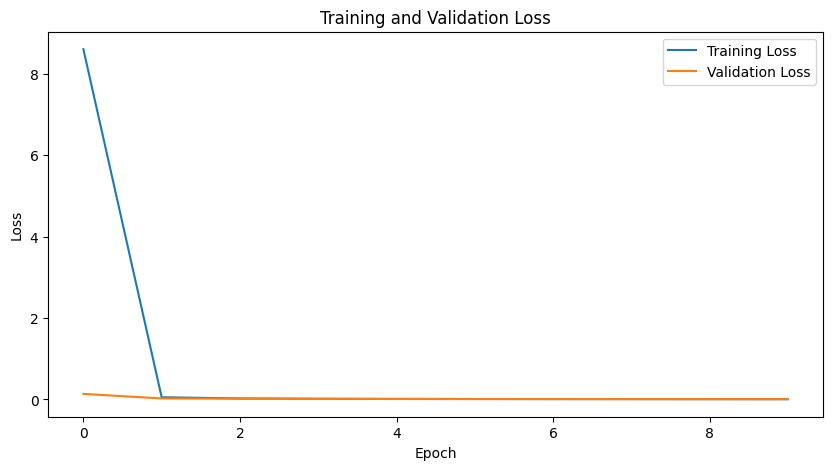

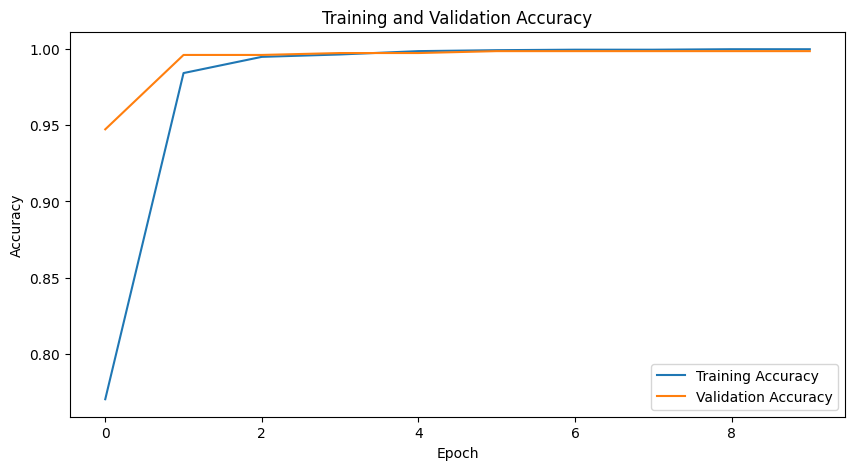

Epoch 1/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.63it/s]


train Loss: 3.1723 Acc: 0.8468


100%|██████████| 13/13 [00:03<00:00,  3.91it/s]


val Loss: 0.0294 Acc: 0.9862
Saving Best Model with Validation Accuracy:  0.9862155388471178
Epoch 2/10
----------


100%|██████████| 50/50 [00:09<00:00,  5.02it/s]


train Loss: 0.0178 Acc: 0.9925


100%|██████████| 13/13 [00:03<00:00,  4.18it/s]


val Loss: 0.0081 Acc: 0.9975
Saving Best Model with Validation Accuracy:  0.9974937343358395
Epoch 3/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.82it/s]


train Loss: 0.0080 Acc: 0.9966


100%|██████████| 13/13 [00:02<00:00,  4.66it/s]


val Loss: 0.0068 Acc: 0.9987
Saving Best Model with Validation Accuracy:  0.9987468671679197
Epoch 4/10
----------


100%|██████████| 50/50 [00:11<00:00,  4.52it/s]


train Loss: 0.0048 Acc: 0.9997


100%|██████████| 13/13 [00:02<00:00,  5.14it/s]


val Loss: 0.0061 Acc: 0.9987
Epoch 5/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.57it/s]


train Loss: 0.0033 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  5.19it/s]


val Loss: 0.0062 Acc: 0.9987
Epoch 6/10
----------


100%|██████████| 50/50 [00:11<00:00,  4.48it/s]


train Loss: 0.0028 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  5.11it/s]


val Loss: 0.0057 Acc: 0.9987
Epoch 7/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.58it/s]


train Loss: 0.0023 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  5.34it/s]


val Loss: 0.0055 Acc: 0.9987
Epoch 8/10
----------


100%|██████████| 50/50 [00:11<00:00,  4.51it/s]


train Loss: 0.0020 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  5.11it/s]


val Loss: 0.0055 Acc: 0.9987
Epoch 9/10
----------


100%|██████████| 50/50 [00:11<00:00,  4.51it/s]


train Loss: 0.0018 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  5.08it/s]


val Loss: 0.0053 Acc: 0.9987
Epoch 10/10
----------


100%|██████████| 50/50 [00:11<00:00,  4.53it/s]


train Loss: 0.0016 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  5.05it/s]


val Loss: 0.0052 Acc: 0.9987
Training complete in 2m 16s
Best Validation Accuracy: 0.9987


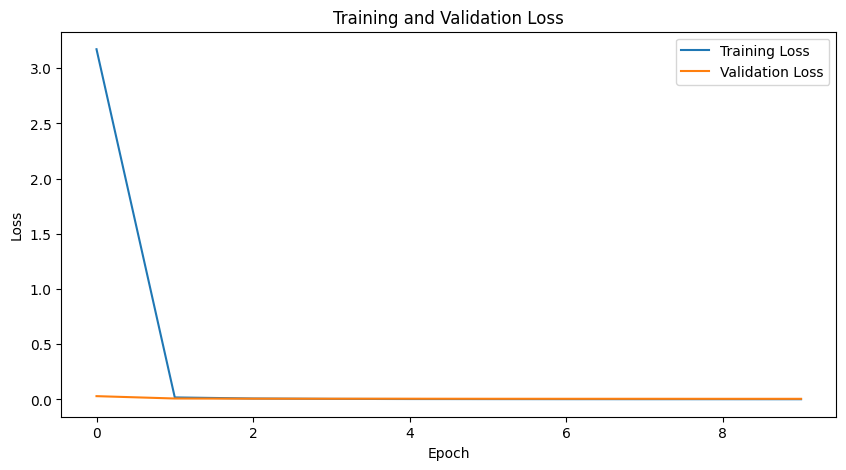

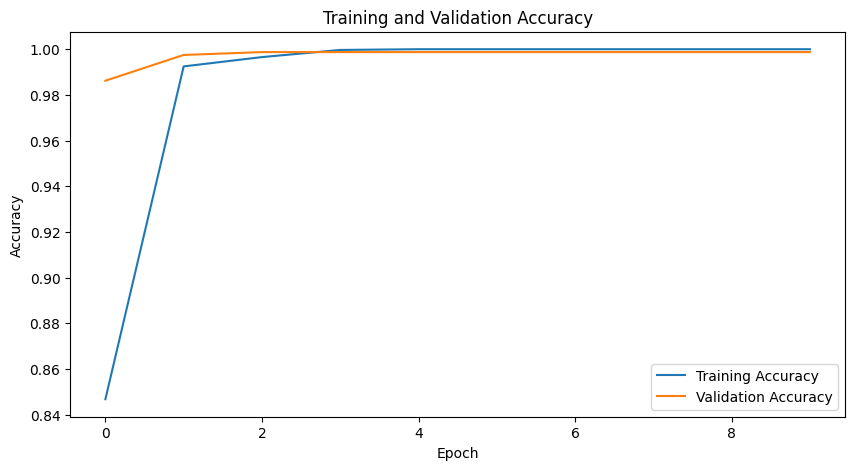

Epoch 1/10
----------


100%|██████████| 50/50 [00:11<00:00,  4.20it/s]


train Loss: 3.2956 Acc: 0.8537


100%|██████████| 13/13 [00:02<00:00,  5.41it/s]


val Loss: 0.0111 Acc: 0.9975
Saving Best Model with Validation Accuracy:  0.9974937343358395
Epoch 2/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.80it/s]


train Loss: 0.0167 Acc: 0.9947


100%|██████████| 13/13 [00:02<00:00,  4.49it/s]


val Loss: 0.0074 Acc: 0.9987
Saving Best Model with Validation Accuracy:  0.9987468671679197
Epoch 3/10
----------


100%|██████████| 50/50 [00:09<00:00,  5.18it/s]


train Loss: 0.0071 Acc: 0.9984


100%|██████████| 13/13 [00:03<00:00,  3.91it/s]


val Loss: 0.0054 Acc: 0.9975
Epoch 4/10
----------


100%|██████████| 50/50 [00:09<00:00,  5.30it/s]


train Loss: 0.0053 Acc: 0.9994


100%|██████████| 13/13 [00:02<00:00,  4.59it/s]


val Loss: 0.0049 Acc: 0.9987
Epoch 5/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.81it/s]


train Loss: 0.0040 Acc: 0.9997


100%|██████████| 13/13 [00:02<00:00,  5.15it/s]


val Loss: 0.0047 Acc: 0.9987
Epoch 6/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.55it/s]


train Loss: 0.0032 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  5.12it/s]


val Loss: 0.0040 Acc: 0.9975
Epoch 7/10
----------


100%|██████████| 50/50 [00:11<00:00,  4.53it/s]


train Loss: 0.0028 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  5.35it/s]


val Loss: 0.0046 Acc: 0.9987
Epoch 8/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.63it/s]


train Loss: 0.0023 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  5.42it/s]


val Loss: 0.0034 Acc: 0.9987
Epoch 9/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.59it/s]


train Loss: 0.0021 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  5.23it/s]


val Loss: 0.0033 Acc: 0.9987
Epoch 10/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.62it/s]


train Loss: 0.0018 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  5.14it/s]


val Loss: 0.0033 Acc: 0.9987
Training complete in 2m 13s
Best Validation Accuracy: 0.9987


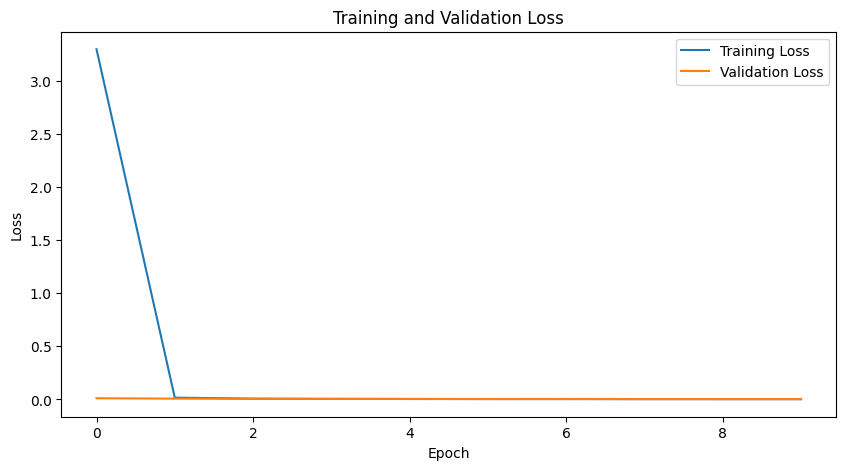

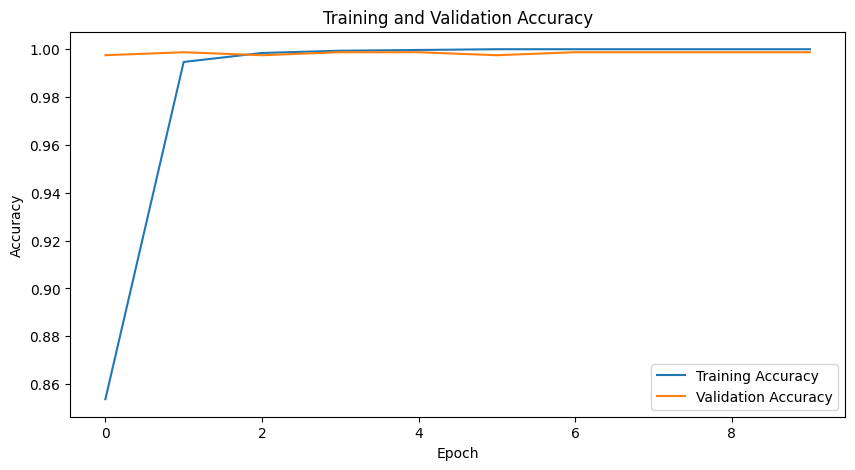

In [ ]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


# Define arguments
class Args:
    def __init__(self, seed):
        self.batch_size = 64 #16
        self.epochs = 10
        self.lr = 0.0001  # Lower the learning rate
        self.momentum = 0.9
        self.seed = seed
        self.regularizer_rate = 0.0
        #self.dropout_rate = 0.7

seeds = [1, 11, 111]

for seed in seeds:
    args = Args(seed)

    # Set random seed for reproducibility
    torch.manual_seed(args.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model, optimizer, and loss function
    model = AlexNet().to(device)
    initialize_weights(model)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=0.0005)
    criterion = nn.CrossEntropyLoss()  # Change to CrossEntropyLoss for multi-class classification

    model = train_model(model, dataloaders, criterion, optimizer, num_epochs=args.epochs, resume_training=False)
    pid = datetime.now().strftime('%Y%m%d%H%M%S')
    torch.save(model.state_dict(), os.path.join(dir_path, model_path, f"alexnet_mnist_wb_bg_cl0_cl2_{seed}" + "train.pt"))

### Foreground

In [ ]:
#Train
two_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits_wb/original/train/class_2'
zero_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits_wb/original/train/class_0_half_first' #first half
#two_fg_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits_wb/foreground/train/class_2'
zero_fg_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits_wb/foreground/train/class_0_half_second' #second half

#Test
test_two_fg_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/foreground/test/class_2'



# Create datasets for training and testing
dataset_two_org = MnistDataset(path=two_org_path, is_two=1, group_labels=[0] * len(os.listdir(two_org_path)))
dataset_zero_org = MnistDataset(path=zero_org_path, is_two=0, group_labels=[2] * len(os.listdir(zero_org_path)))
#dataset_two_fg = MnistDataset(path=two_fg_path, is_two=1, group_labels=[1] * len(os.listdir(two_fg_path)))
dataset_zero_fg = MnistDataset(path=zero_fg_path, is_two=0, group_labels=[3] * len(os.listdir(zero_fg_path)))
dataset_test_two_fg = MnistDataset(path=test_two_fg_path, is_two=1, group_labels=[1] * len(os.listdir(test_two_fg_path)))

# Concatenate the training datasets
complete_dataset = ConcatDataset((dataset_zero_org, dataset_zero_fg, dataset_two_org))

# Set the random seed for reproducibility
seed = 1
torch.manual_seed(seed)

# Split the dataset into training and validation sets (80% train, 20% val)
train_size = int(0.8 * len(complete_dataset))
val_size = len(complete_dataset) - train_size
train_dataset, val_dataset = random_split(complete_dataset, [train_size, val_size])

# Use the test dataset as is
test_dataset = dataset_test_two_fg

batch_size = 64

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Validate input data
#if not validate_inputs(train_loader):
#    print("Input data contains invalid values.")

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_val:", dataset_sizes['val'])
print("num_test:", dataset_sizes['test'])



num_train: 3192
num_val: 798
num_test: 1032


Epoch 1/10
----------


100%|██████████| 50/50 [00:12<00:00,  4.05it/s]


train Loss: 3.3231 Acc: 0.8377


100%|██████████| 13/13 [00:02<00:00,  4.86it/s]


val Loss: 0.0161 Acc: 0.9937
Saving Best Model with Validation Accuracy:  0.9937343358395989
Epoch 2/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.65it/s]


train Loss: 0.0209 Acc: 0.9928


100%|██████████| 13/13 [00:02<00:00,  5.40it/s]


val Loss: 0.0086 Acc: 0.9987
Saving Best Model with Validation Accuracy:  0.9987468671679197
Epoch 3/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.57it/s]


train Loss: 0.0116 Acc: 0.9959


100%|██████████| 13/13 [00:02<00:00,  5.55it/s]


val Loss: 0.0080 Acc: 0.9987
Epoch 4/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.59it/s]


train Loss: 0.0062 Acc: 0.9987


100%|██████████| 13/13 [00:02<00:00,  5.32it/s]


val Loss: 0.0069 Acc: 0.9987
Epoch 5/10
----------


100%|██████████| 50/50 [00:11<00:00,  4.50it/s]


train Loss: 0.0045 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  5.13it/s]


val Loss: 0.0067 Acc: 0.9987
Epoch 6/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.63it/s]


train Loss: 0.0036 Acc: 0.9997


100%|██████████| 13/13 [00:02<00:00,  4.94it/s]


val Loss: 0.0062 Acc: 0.9987
Epoch 7/10
----------


100%|██████████| 50/50 [00:09<00:00,  5.00it/s]


train Loss: 0.0029 Acc: 1.0000


100%|██████████| 13/13 [00:03<00:00,  4.14it/s]


val Loss: 0.0059 Acc: 0.9987
Epoch 8/10
----------


100%|██████████| 50/50 [00:09<00:00,  5.26it/s]


train Loss: 0.0029 Acc: 1.0000


100%|██████████| 13/13 [00:03<00:00,  4.13it/s]


val Loss: 0.0055 Acc: 0.9987
Epoch 9/10
----------


100%|██████████| 50/50 [00:09<00:00,  5.15it/s]


train Loss: 0.0022 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  4.56it/s]


val Loss: 0.0056 Acc: 0.9987
Epoch 10/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.71it/s]


train Loss: 0.0019 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  4.83it/s]


val Loss: 0.0057 Acc: 0.9987
Training complete in 2m 14s
Best Validation Accuracy: 0.9987


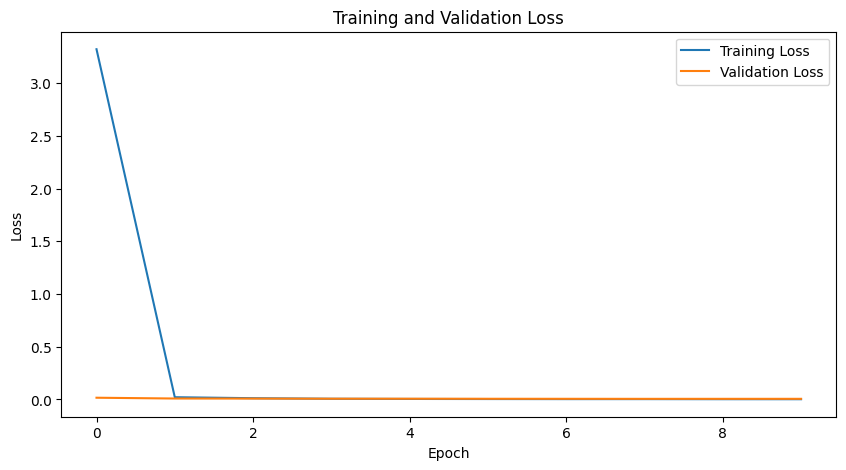

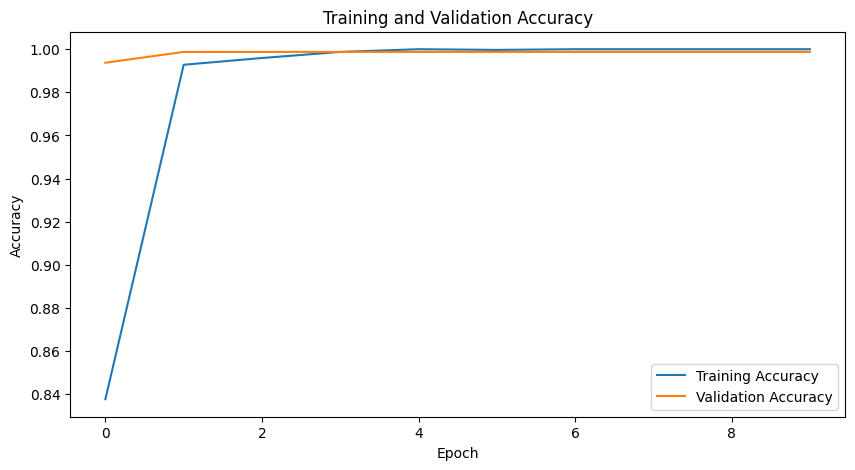

Epoch 1/10
----------


100%|██████████| 50/50 [00:11<00:00,  4.53it/s]


train Loss: 3.0056 Acc: 0.8518


100%|██████████| 13/13 [00:02<00:00,  4.72it/s]


val Loss: 0.0826 Acc: 0.9724
Saving Best Model with Validation Accuracy:  0.9724310776942355
Epoch 2/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.64it/s]


train Loss: 0.0198 Acc: 0.9912


100%|██████████| 13/13 [00:02<00:00,  5.16it/s]


val Loss: 0.0069 Acc: 0.9987
Saving Best Model with Validation Accuracy:  0.9987468671679197
Epoch 3/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.59it/s]


train Loss: 0.0079 Acc: 0.9966


100%|██████████| 13/13 [00:02<00:00,  5.20it/s]


val Loss: 0.0061 Acc: 0.9987
Epoch 4/10
----------


100%|██████████| 50/50 [00:11<00:00,  4.48it/s]


train Loss: 0.0043 Acc: 0.9997


100%|██████████| 13/13 [00:02<00:00,  5.28it/s]


val Loss: 0.0057 Acc: 0.9987
Epoch 5/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.60it/s]


train Loss: 0.0029 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  5.29it/s]


val Loss: 0.0055 Acc: 0.9987
Epoch 6/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.64it/s]


train Loss: 0.0025 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  5.17it/s]


val Loss: 0.0054 Acc: 0.9987
Epoch 7/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.62it/s]


train Loss: 0.0021 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  5.34it/s]


val Loss: 0.0052 Acc: 0.9987
Epoch 8/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.77it/s]


train Loss: 0.0018 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  5.20it/s]


val Loss: 0.0052 Acc: 0.9987
Epoch 9/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.94it/s]


train Loss: 0.0017 Acc: 1.0000


100%|██████████| 13/13 [00:03<00:00,  4.27it/s]


val Loss: 0.0050 Acc: 0.9987
Epoch 10/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.93it/s]


train Loss: 0.0015 Acc: 1.0000


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


val Loss: 0.0051 Acc: 0.9987
Training complete in 2m 14s
Best Validation Accuracy: 0.9987


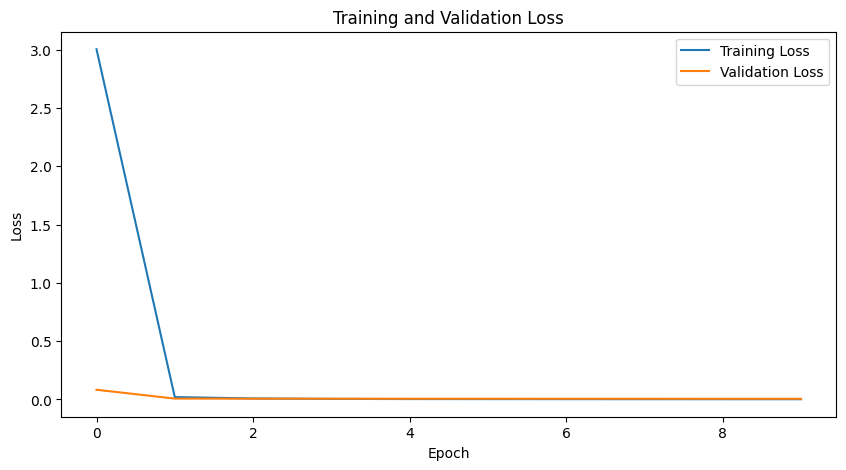

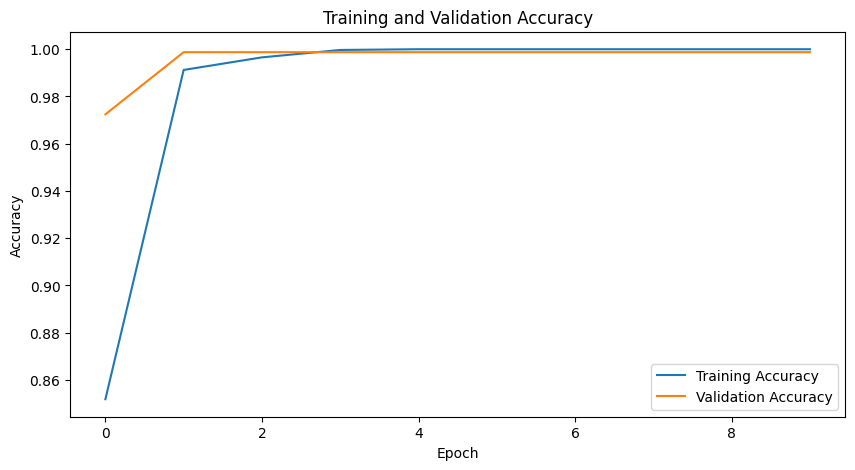

Epoch 1/10
----------


100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


train Loss: 3.3376 Acc: 0.8346


100%|██████████| 13/13 [00:03<00:00,  4.07it/s]


val Loss: 0.0177 Acc: 0.9925
Saving Best Model with Validation Accuracy:  0.9924812030075187
Epoch 2/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.92it/s]


train Loss: 0.0122 Acc: 0.9950


100%|██████████| 13/13 [00:03<00:00,  4.06it/s]


val Loss: 0.0069 Acc: 0.9975
Saving Best Model with Validation Accuracy:  0.9974937343358395
Epoch 3/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.91it/s]


train Loss: 0.0064 Acc: 0.9987


100%|██████████| 13/13 [00:03<00:00,  4.07it/s]


val Loss: 0.0050 Acc: 0.9975
Epoch 4/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.90it/s]


train Loss: 0.0049 Acc: 0.9997


100%|██████████| 13/13 [00:03<00:00,  4.31it/s]


val Loss: 0.0045 Acc: 0.9975
Epoch 5/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.78it/s]


train Loss: 0.0037 Acc: 0.9997


100%|██████████| 13/13 [00:02<00:00,  4.87it/s]


val Loss: 0.0046 Acc: 0.9987
Saving Best Model with Validation Accuracy:  0.9987468671679197
Epoch 6/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.74it/s]


train Loss: 0.0029 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  5.46it/s]


val Loss: 0.0039 Acc: 0.9975
Epoch 7/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.62it/s]


train Loss: 0.0025 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  5.37it/s]


val Loss: 0.0042 Acc: 0.9987
Epoch 8/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.70it/s]


train Loss: 0.0022 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  5.46it/s]


val Loss: 0.0035 Acc: 0.9975
Epoch 9/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.69it/s]


train Loss: 0.0019 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  5.32it/s]


val Loss: 0.0034 Acc: 0.9987
Epoch 10/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.66it/s]


train Loss: 0.0017 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  5.35it/s]


val Loss: 0.0033 Acc: 0.9987
Training complete in 2m 13s
Best Validation Accuracy: 0.9987


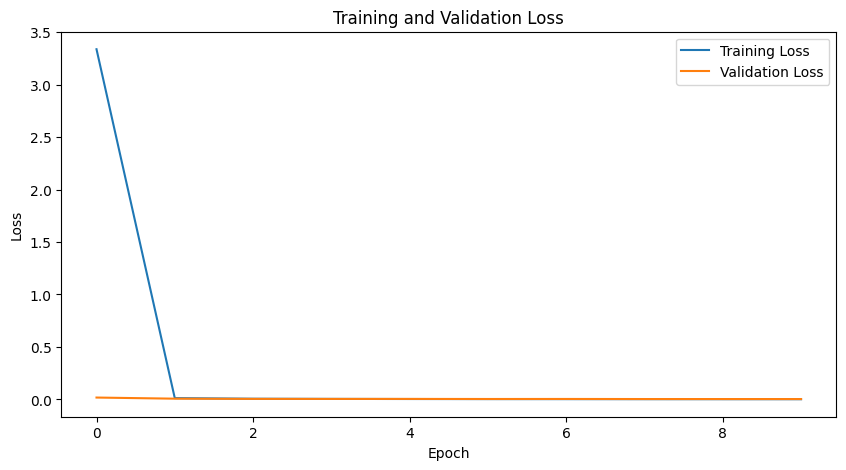

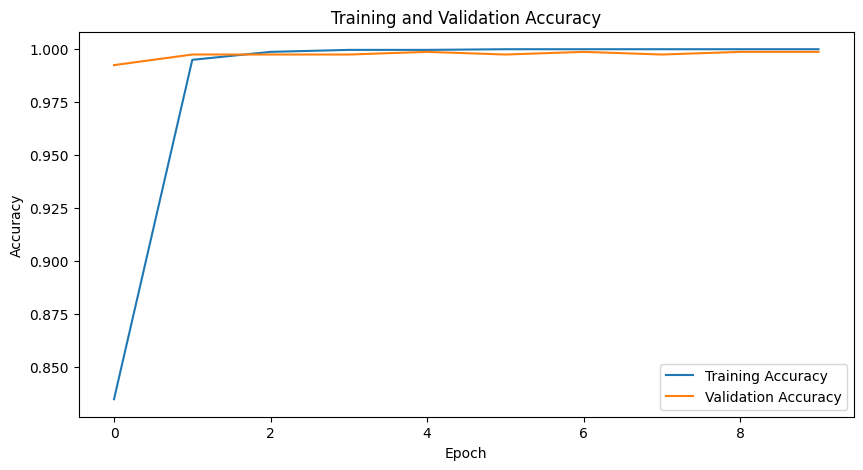

In [ ]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


class Args:
    def __init__(self, seed):
        self.batch_size = 64 #16
        self.epochs = 10
        self.lr = 0.0001  # Lower the learning rate
        self.momentum = 0.9
        self.seed = seed
        self.regularizer_rate = 0.0
        #self.dropout_rate = 0.7

seeds = [1, 11, 111]

for seed in seeds:
    args = Args(seed)

    # Set random seed for reproducibility
    torch.manual_seed(args.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model, optimizer, and loss function
    model = AlexNet().to(device)
    initialize_weights(model)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=0.0005)
    criterion = nn.CrossEntropyLoss()  # Change to CrossEntropyLoss for multi-class classification

    model = train_model(model, dataloaders, criterion, optimizer, num_epochs=args.epochs, resume_training=False)
    pid = datetime.now().strftime('%Y%m%d%H%M%S')
    torch.save(model.state_dict(), os.path.join(dir_path, model_path, f"alexnet_mnist_wb_fg_cl0_cl2_{seed}" + "train.pt"))

### Left Patch

In [ ]:
#Train
two_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits_wb/original/train/class_2'
zero_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits_wb/original/train/class_0_half_first'
#two_lp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_left/train/class_2'
zero_lp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits_wb/patches_left/train/class_0_half_second'

#Test
test_two_lp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_left/test/class_2'



# Create datasets for training and testing
dataset_two_org = MnistDataset(path=two_org_path, is_two=1, group_labels=[0] * len(os.listdir(two_org_path)))
dataset_zero_org = MnistDataset(path=zero_org_path, is_two=0, group_labels=[2] * len(os.listdir(zero_org_path)))
#dataset_two_lp = MnistDataset(path=two_lp_path, is_two=1, group_labels=[1] * len(os.listdir(two_lp_path)))
dataset_zero_lp = MnistDataset(path=zero_lp_path, is_two=0, group_labels=[3] * len(os.listdir(zero_lp_path)))
dataset_test_two_lp = MnistDataset(path=test_two_lp_path, is_two=1, group_labels=[1] * len(os.listdir(test_two_lp_path)))

# Concatenate the training datasets
complete_dataset = ConcatDataset((dataset_zero_org, dataset_zero_lp, dataset_two_org))

# Set the random seed for reproducibility
seed = 1
torch.manual_seed(seed)

# Split the dataset into training and validation sets (80% train, 20% val)
train_size = int(0.8 * len(complete_dataset))
val_size = len(complete_dataset) - train_size
train_dataset, val_dataset = random_split(complete_dataset, [train_size, val_size])

# Use the test dataset as is
test_dataset = dataset_test_two_lp

batch_size = 64

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Validate input data
#if not validate_inputs(train_loader):
#    print("Input data contains invalid values.")

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_val:", dataset_sizes['val'])
print("num_test:", dataset_sizes['test'])



num_train: 3192
num_val: 798
num_test: 1032


Epoch 1/10
----------


100%|██████████| 50/50 [00:12<00:00,  3.90it/s]


train Loss: 8.5645 Acc: 0.7813


100%|██████████| 13/13 [00:02<00:00,  4.97it/s]


val Loss: 0.1209 Acc: 0.9499
Saving Best Model with Validation Accuracy:  0.949874686716792
Epoch 2/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.78it/s]


train Loss: 0.0476 Acc: 0.9850


100%|██████████| 13/13 [00:02<00:00,  5.60it/s]


val Loss: 0.0235 Acc: 0.9950
Saving Best Model with Validation Accuracy:  0.9949874686716791
Epoch 3/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.74it/s]


train Loss: 0.0224 Acc: 0.9953


100%|██████████| 13/13 [00:02<00:00,  5.65it/s]


val Loss: 0.0181 Acc: 0.9975
Saving Best Model with Validation Accuracy:  0.9974937343358395
Epoch 4/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.63it/s]


train Loss: 0.0151 Acc: 0.9981


100%|██████████| 13/13 [00:02<00:00,  5.58it/s]


val Loss: 0.0137 Acc: 0.9975
Epoch 5/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.69it/s]


train Loss: 0.0113 Acc: 0.9991


100%|██████████| 13/13 [00:02<00:00,  5.35it/s]


val Loss: 0.0121 Acc: 0.9975
Epoch 6/10
----------


100%|██████████| 50/50 [00:09<00:00,  5.20it/s]


train Loss: 0.0089 Acc: 0.9997


100%|██████████| 13/13 [00:03<00:00,  3.96it/s]


val Loss: 0.0105 Acc: 0.9975
Epoch 7/10
----------


100%|██████████| 50/50 [00:09<00:00,  5.03it/s]


train Loss: 0.0072 Acc: 0.9997


100%|██████████| 13/13 [00:03<00:00,  4.00it/s]


val Loss: 0.0100 Acc: 0.9975
Epoch 8/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.98it/s]


train Loss: 0.0064 Acc: 0.9997


100%|██████████| 13/13 [00:03<00:00,  4.05it/s]


val Loss: 0.0088 Acc: 0.9975
Epoch 9/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.86it/s]


train Loss: 0.0051 Acc: 1.0000


100%|██████████| 13/13 [00:03<00:00,  4.32it/s]


val Loss: 0.0082 Acc: 0.9975
Epoch 10/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.81it/s]


train Loss: 0.0044 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  4.86it/s]


val Loss: 0.0078 Acc: 0.9975
Training complete in 2m 13s
Best Validation Accuracy: 0.9975


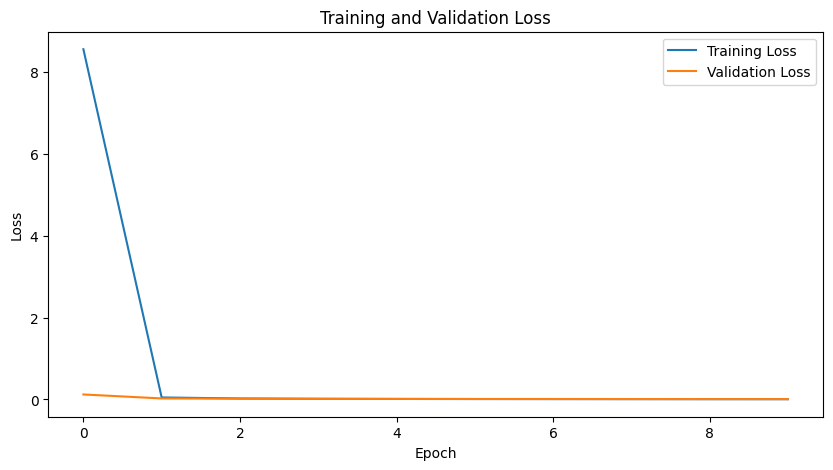

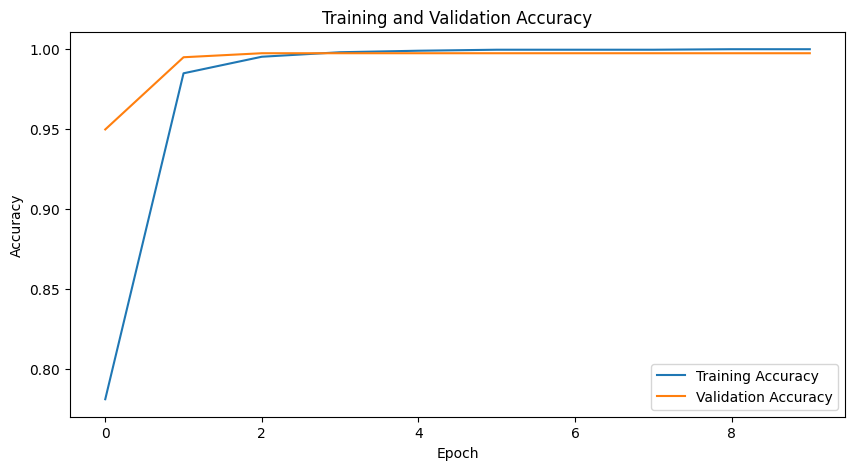

Epoch 1/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.68it/s]


train Loss: 3.2099 Acc: 0.8440


100%|██████████| 13/13 [00:02<00:00,  4.60it/s]


val Loss: 0.0261 Acc: 0.9862
Saving Best Model with Validation Accuracy:  0.9862155388471178
Epoch 2/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.84it/s]


train Loss: 0.0194 Acc: 0.9925


100%|██████████| 13/13 [00:02<00:00,  5.43it/s]


val Loss: 0.0079 Acc: 0.9987
Saving Best Model with Validation Accuracy:  0.9987468671679197
Epoch 3/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.70it/s]


train Loss: 0.0087 Acc: 0.9959


100%|██████████| 13/13 [00:02<00:00,  5.55it/s]


val Loss: 0.0067 Acc: 0.9987
Epoch 4/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.70it/s]


train Loss: 0.0047 Acc: 0.9991


100%|██████████| 13/13 [00:02<00:00,  5.59it/s]


val Loss: 0.0061 Acc: 0.9987
Epoch 5/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.75it/s]


train Loss: 0.0031 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  5.54it/s]


val Loss: 0.0061 Acc: 0.9987
Epoch 6/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.65it/s]


train Loss: 0.0027 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  5.42it/s]


val Loss: 0.0056 Acc: 0.9987
Epoch 7/10
----------


100%|██████████| 50/50 [00:09<00:00,  5.01it/s]


train Loss: 0.0022 Acc: 1.0000


100%|██████████| 13/13 [00:03<00:00,  4.26it/s]


val Loss: 0.0054 Acc: 0.9987
Epoch 8/10
----------


100%|██████████| 50/50 [00:09<00:00,  5.29it/s]


train Loss: 0.0019 Acc: 1.0000


100%|██████████| 13/13 [00:03<00:00,  3.97it/s]


val Loss: 0.0054 Acc: 0.9987
Epoch 9/10
----------


100%|██████████| 50/50 [00:09<00:00,  5.33it/s]


train Loss: 0.0017 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  4.58it/s]


val Loss: 0.0052 Acc: 0.9987
Epoch 10/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.93it/s]


train Loss: 0.0015 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  5.44it/s]


val Loss: 0.0051 Acc: 0.9987
Training complete in 2m 9s
Best Validation Accuracy: 0.9987


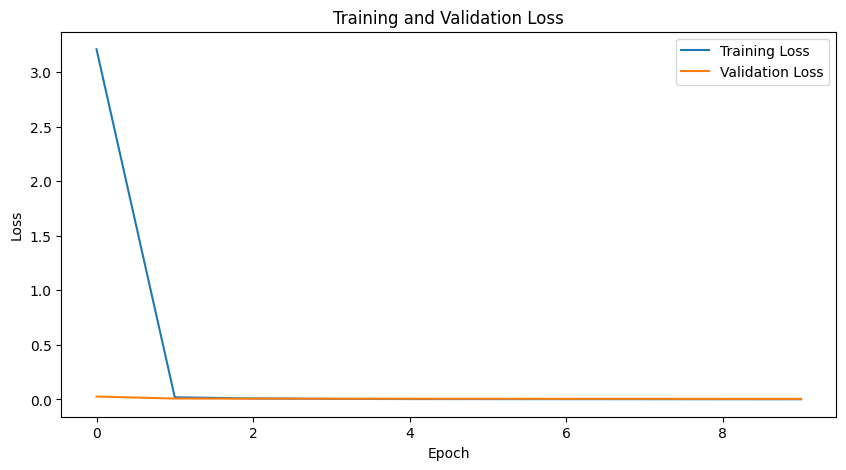

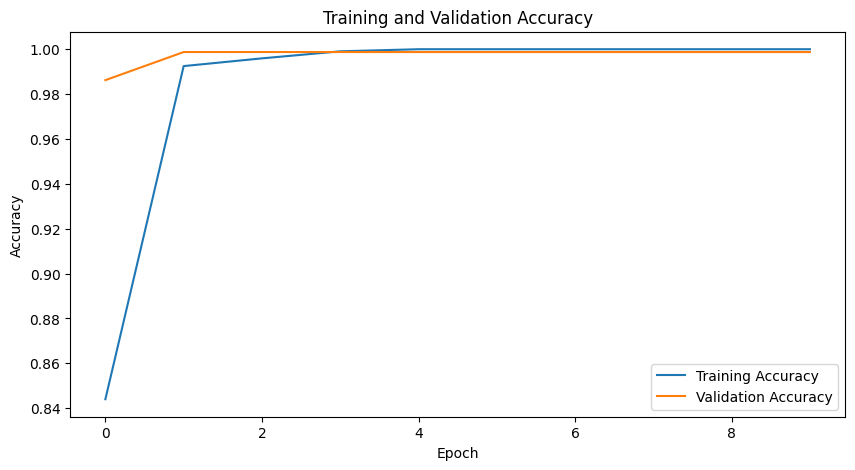

Epoch 1/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.62it/s]


train Loss: 3.6468 Acc: 0.8174


100%|██████████| 13/13 [00:02<00:00,  5.55it/s]


val Loss: 0.0627 Acc: 0.9737
Saving Best Model with Validation Accuracy:  0.9736842105263157
Epoch 2/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.62it/s]


train Loss: 0.0164 Acc: 0.9928


100%|██████████| 13/13 [00:02<00:00,  5.32it/s]


val Loss: 0.0086 Acc: 0.9962
Saving Best Model with Validation Accuracy:  0.9962406015037594
Epoch 3/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.69it/s]


train Loss: 0.0077 Acc: 0.9978


100%|██████████| 13/13 [00:02<00:00,  5.58it/s]


val Loss: 0.0066 Acc: 0.9962
Epoch 4/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.72it/s]


train Loss: 0.0056 Acc: 0.9997


100%|██████████| 13/13 [00:02<00:00,  5.26it/s]


val Loss: 0.0061 Acc: 0.9962
Epoch 5/10
----------


100%|██████████| 50/50 [00:11<00:00,  4.50it/s]


train Loss: 0.0042 Acc: 0.9997


100%|██████████| 13/13 [00:02<00:00,  5.06it/s]


val Loss: 0.0060 Acc: 0.9975
Saving Best Model with Validation Accuracy:  0.9974937343358395
Epoch 6/10
----------


100%|██████████| 50/50 [00:11<00:00,  4.50it/s]


train Loss: 0.0033 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  5.12it/s]


val Loss: 0.0049 Acc: 0.9962
Epoch 7/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.63it/s]


train Loss: 0.0030 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  5.04it/s]


val Loss: 0.0056 Acc: 0.9975
Epoch 8/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.89it/s]


train Loss: 0.0025 Acc: 1.0000


100%|██████████| 13/13 [00:03<00:00,  4.22it/s]


val Loss: 0.0044 Acc: 0.9975
Epoch 9/10
----------


100%|██████████| 50/50 [00:09<00:00,  5.24it/s]


train Loss: 0.0022 Acc: 1.0000


100%|██████████| 13/13 [00:03<00:00,  3.98it/s]


val Loss: 0.0046 Acc: 0.9975
Epoch 10/10
----------


100%|██████████| 50/50 [00:09<00:00,  5.34it/s]


train Loss: 0.0020 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  4.55it/s]


val Loss: 0.0042 Acc: 0.9975
Training complete in 2m 12s
Best Validation Accuracy: 0.9975


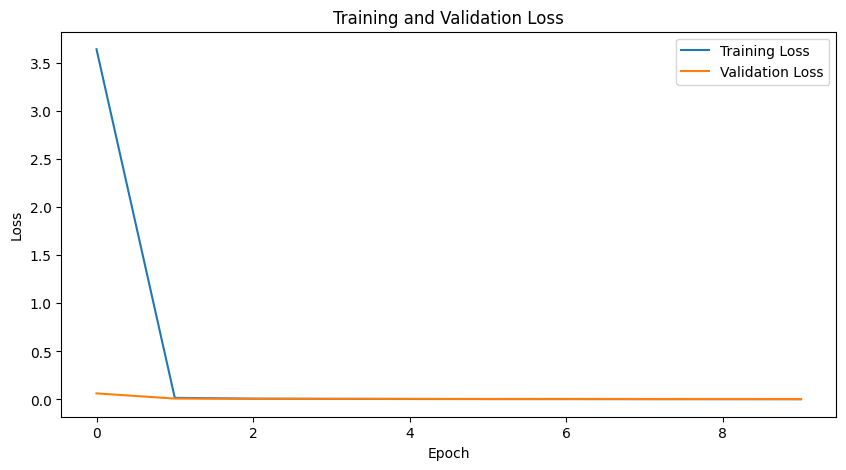

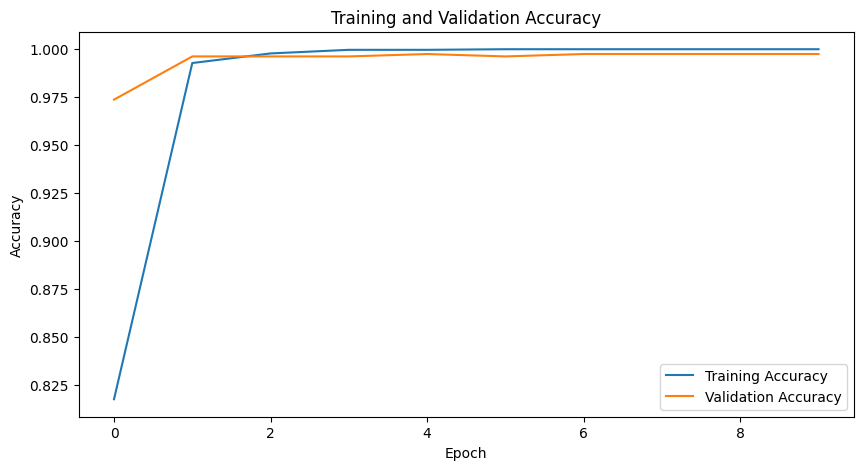

In [ ]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


# Define arguments
class Args:
    def __init__(self, seed):
        self.batch_size = 64 #16
        self.epochs = 10
        self.lr = 0.0001  # Lower the learning rate
        self.momentum = 0.9
        self.seed = seed
        self.regularizer_rate = 0.0
        #self.dropout_rate = 0.7

seeds = [1, 11, 111]

for seed in seeds:
    args = Args(seed)

    # Set random seed for reproducibility
    torch.manual_seed(args.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model, optimizer, and loss function
    model = AlexNet().to(device)
    initialize_weights(model)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=0.0005)
    criterion = nn.CrossEntropyLoss()  # Change to CrossEntropyLoss for multi-class classification

    model = train_model(model, dataloaders, criterion, optimizer, num_epochs=args.epochs, resume_training=False)
    pid = datetime.now().strftime('%Y%m%d%H%M%S')
    torch.save(model.state_dict(), os.path.join(dir_path, model_path, f"alexnet_mnist_wb_lp_cl0_cl2_{seed}" + "train.pt"))

### Center Patch

In [ ]:
#Train
two_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits_wb/original/train/class_2'
zero_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits_wb/original/train/class_0_half_first' #first half
#two_cp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_center/train/class_2'
zero_cp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits_wb/patches_center/train/class_0_half_second' #second half

#Test
test_two_cp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_center/test/class_2'



# Create datasets for training and testing
dataset_two_org = MnistDataset(path=two_org_path, is_two=1, group_labels=[0] * len(os.listdir(two_org_path)))
dataset_zero_org = MnistDataset(path=zero_org_path, is_two=0, group_labels=[2] * len(os.listdir(zero_org_path)))
#dataset_two_cp = MnistDataset(path=two_cp_path, is_two=1, group_labels=[1] * len(os.listdir(two_cp_path)))
dataset_zero_cp = MnistDataset(path=zero_cp_path, is_two=0, group_labels=[3] * len(os.listdir(zero_cp_path)))
dataset_test_two_cp = MnistDataset(path=test_two_cp_path, is_two=1, group_labels=[1] * len(os.listdir(test_two_cp_path)))

# Concatenate the training datasets
complete_dataset = ConcatDataset((dataset_zero_org, dataset_zero_cp, dataset_two_org))

# Set the random seed for reproducibility
seed = 1
torch.manual_seed(seed)

# Split the dataset into training and validation sets (80% train, 20% val)
train_size = int(0.8 * len(complete_dataset))
val_size = len(complete_dataset) - train_size
train_dataset, val_dataset = random_split(complete_dataset, [train_size, val_size])

# Use the test dataset as is
test_dataset = dataset_test_two_cp

batch_size = 64

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Validate input data
#if not validate_inputs(train_loader):
#    print("Input data contains invalid values.")

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_val:", dataset_sizes['val'])
print("num_test:", dataset_sizes['test'])



num_train: 3192
num_val: 798
num_test: 1032


Epoch 1/10
----------


100%|██████████| 50/50 [08:32<00:00, 10.25s/it]


train Loss: 8.5725 Acc: 0.7813


100%|██████████| 13/13 [02:11<00:00, 10.13s/it]


val Loss: 0.1267 Acc: 0.9486
Saving Best Model with Validation Accuracy:  0.9486215538847117
Epoch 2/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.69it/s]


train Loss: 0.0495 Acc: 0.9846


100%|██████████| 13/13 [00:02<00:00,  5.47it/s]


val Loss: 0.0260 Acc: 0.9950
Saving Best Model with Validation Accuracy:  0.9949874686716791
Epoch 3/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.60it/s]


train Loss: 0.0234 Acc: 0.9940


100%|██████████| 13/13 [00:02<00:00,  5.26it/s]


val Loss: 0.0207 Acc: 0.9950
Epoch 4/10
----------


100%|██████████| 50/50 [00:11<00:00,  4.48it/s]


train Loss: 0.0161 Acc: 0.9969


100%|██████████| 13/13 [00:02<00:00,  5.14it/s]


val Loss: 0.0164 Acc: 0.9975
Saving Best Model with Validation Accuracy:  0.9974937343358395
Epoch 5/10
----------


100%|██████████| 50/50 [00:11<00:00,  4.52it/s]


train Loss: 0.0123 Acc: 0.9987


100%|██████████| 13/13 [00:02<00:00,  5.14it/s]


val Loss: 0.0143 Acc: 0.9962
Epoch 6/10
----------


100%|██████████| 50/50 [00:11<00:00,  4.49it/s]


train Loss: 0.0097 Acc: 0.9994


100%|██████████| 13/13 [00:02<00:00,  5.01it/s]


val Loss: 0.0124 Acc: 0.9975
Epoch 7/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.56it/s]


train Loss: 0.0078 Acc: 0.9994


100%|██████████| 13/13 [00:02<00:00,  4.83it/s]


val Loss: 0.0121 Acc: 0.9975
Epoch 8/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.74it/s]


train Loss: 0.0070 Acc: 0.9994


100%|██████████| 13/13 [00:03<00:00,  4.28it/s]


val Loss: 0.0104 Acc: 0.9975
Epoch 9/10
----------


100%|██████████| 50/50 [00:10<00:00,  5.00it/s]


train Loss: 0.0055 Acc: 1.0000


100%|██████████| 13/13 [00:03<00:00,  4.04it/s]


val Loss: 0.0098 Acc: 0.9975
Epoch 10/10
----------


100%|██████████| 50/50 [00:09<00:00,  5.07it/s]


train Loss: 0.0048 Acc: 1.0000


100%|██████████| 13/13 [00:03<00:00,  4.32it/s]


val Loss: 0.0092 Acc: 0.9975
Training complete in 12m 45s
Best Validation Accuracy: 0.9975


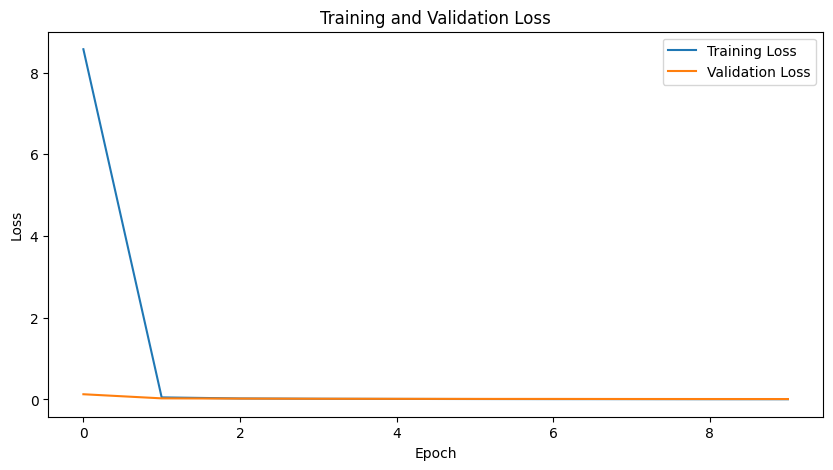

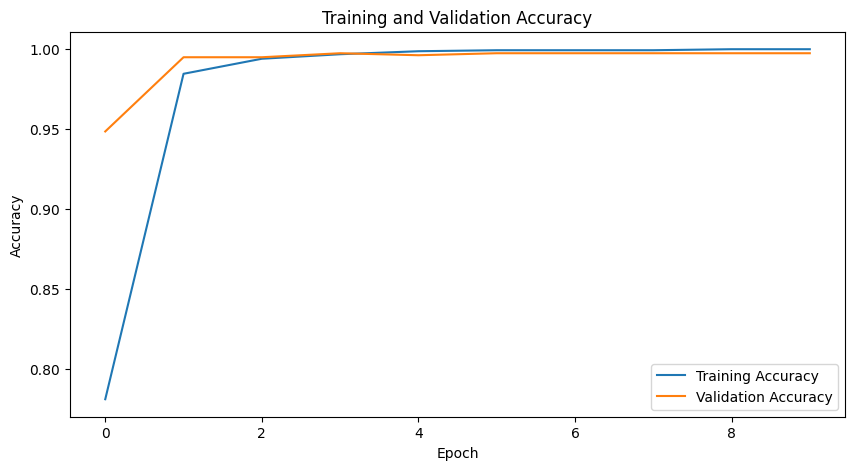

Epoch 1/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.55it/s]


train Loss: 3.2161 Acc: 0.8434


100%|██████████| 13/13 [00:02<00:00,  5.39it/s]


val Loss: 0.0324 Acc: 0.9850
Saving Best Model with Validation Accuracy:  0.9849624060150375
Epoch 2/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.70it/s]


train Loss: 0.0207 Acc: 0.9912


100%|██████████| 13/13 [00:02<00:00,  5.34it/s]


val Loss: 0.0074 Acc: 0.9987
Saving Best Model with Validation Accuracy:  0.9987468671679197
Epoch 3/10
----------


100%|██████████| 50/50 [00:09<00:00,  5.12it/s]


train Loss: 0.0088 Acc: 0.9966


100%|██████████| 13/13 [00:03<00:00,  4.16it/s]


val Loss: 0.0063 Acc: 0.9987
Epoch 4/10
----------


100%|██████████| 50/50 [00:09<00:00,  5.34it/s]


train Loss: 0.0051 Acc: 0.9994


100%|██████████| 13/13 [00:03<00:00,  4.09it/s]


val Loss: 0.0059 Acc: 0.9987
Epoch 5/10
----------


100%|██████████| 50/50 [00:09<00:00,  5.25it/s]


train Loss: 0.0035 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  4.95it/s]


val Loss: 0.0058 Acc: 0.9987
Epoch 6/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.79it/s]


train Loss: 0.0030 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  5.22it/s]


val Loss: 0.0057 Acc: 0.9987
Epoch 7/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.57it/s]


train Loss: 0.0024 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  5.34it/s]


val Loss: 0.0054 Acc: 0.9987
Epoch 8/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.66it/s]


train Loss: 0.0021 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  5.45it/s]


val Loss: 0.0055 Acc: 0.9987
Epoch 9/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.63it/s]


train Loss: 0.0019 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  5.37it/s]


val Loss: 0.0053 Acc: 0.9987
Epoch 10/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.67it/s]


train Loss: 0.0017 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  5.17it/s]


val Loss: 0.0053 Acc: 0.9987
Training complete in 2m 10s
Best Validation Accuracy: 0.9987


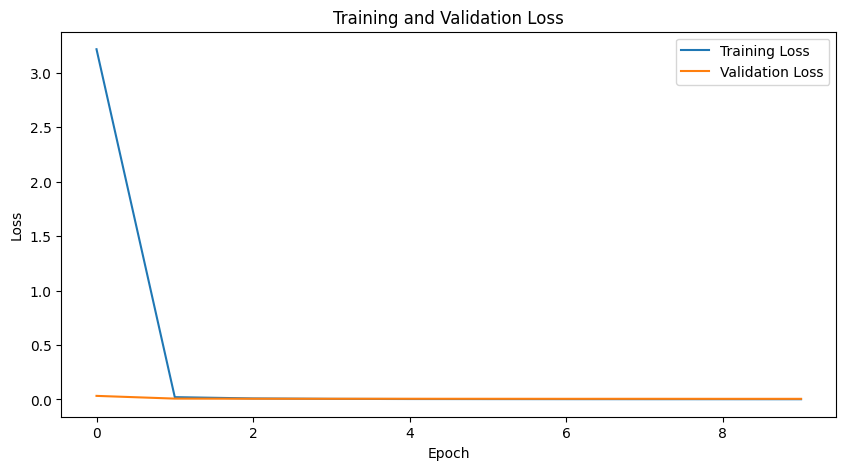

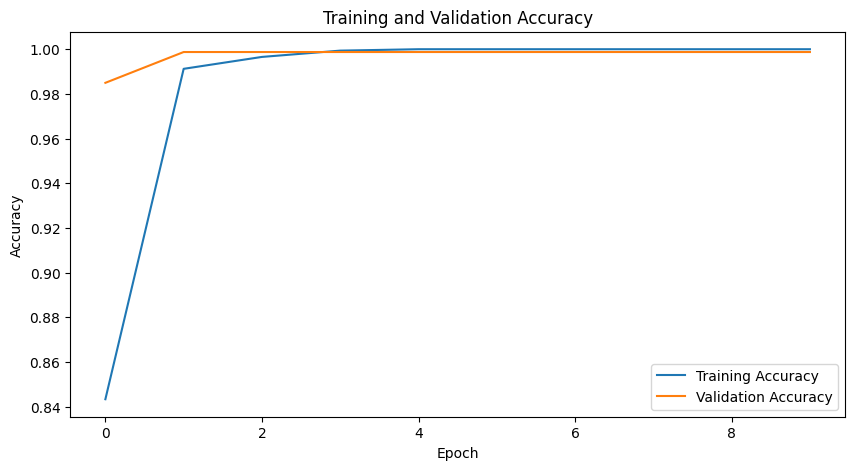

Epoch 1/10
----------


100%|██████████| 50/50 [00:11<00:00,  4.27it/s]


train Loss: 3.7539 Acc: 0.8145


100%|██████████| 13/13 [00:02<00:00,  5.19it/s]


val Loss: 0.0557 Acc: 0.9774
Saving Best Model with Validation Accuracy:  0.9774436090225563
Epoch 2/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.78it/s]


train Loss: 0.0193 Acc: 0.9922


100%|██████████| 13/13 [00:02<00:00,  4.82it/s]


val Loss: 0.0078 Acc: 0.9987
Saving Best Model with Validation Accuracy:  0.9987468671679197
Epoch 3/10
----------


100%|██████████| 50/50 [00:09<00:00,  5.09it/s]


train Loss: 0.0088 Acc: 0.9978


100%|██████████| 13/13 [00:03<00:00,  3.96it/s]


val Loss: 0.0052 Acc: 0.9987
Epoch 4/10
----------


100%|██████████| 50/50 [00:09<00:00,  5.35it/s]


train Loss: 0.0063 Acc: 0.9994


100%|██████████| 13/13 [00:02<00:00,  4.55it/s]


val Loss: 0.0047 Acc: 0.9987
Epoch 5/10
----------


100%|██████████| 50/50 [00:09<00:00,  5.05it/s]


train Loss: 0.0046 Acc: 0.9994


100%|██████████| 13/13 [00:02<00:00,  5.75it/s]


val Loss: 0.0047 Acc: 0.9987
Epoch 6/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.73it/s]


train Loss: 0.0036 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  5.23it/s]


val Loss: 0.0038 Acc: 0.9987
Epoch 7/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.68it/s]


train Loss: 0.0033 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  5.35it/s]


val Loss: 0.0042 Acc: 0.9987
Epoch 8/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.63it/s]


train Loss: 0.0027 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  5.53it/s]


val Loss: 0.0033 Acc: 0.9987
Epoch 9/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.70it/s]


train Loss: 0.0024 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  5.42it/s]


val Loss: 0.0034 Acc: 0.9987
Epoch 10/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.88it/s]


train Loss: 0.0021 Acc: 1.0000


100%|██████████| 13/13 [00:02<00:00,  5.14it/s]


val Loss: 0.0031 Acc: 0.9987
Training complete in 2m 10s
Best Validation Accuracy: 0.9987


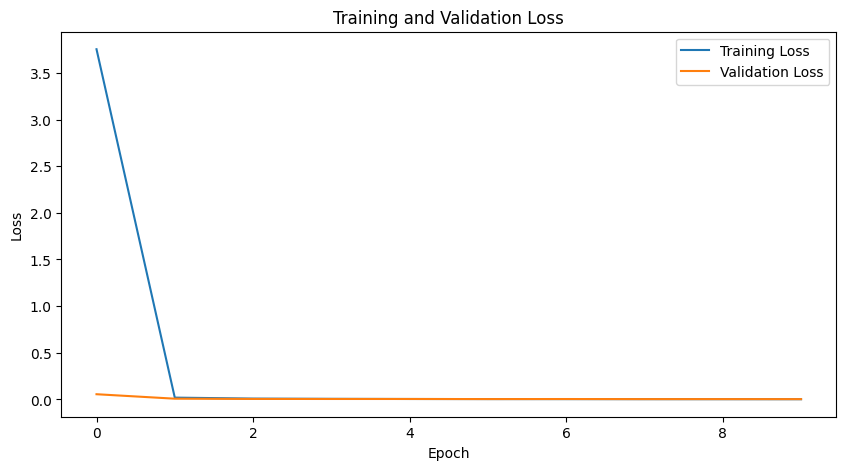

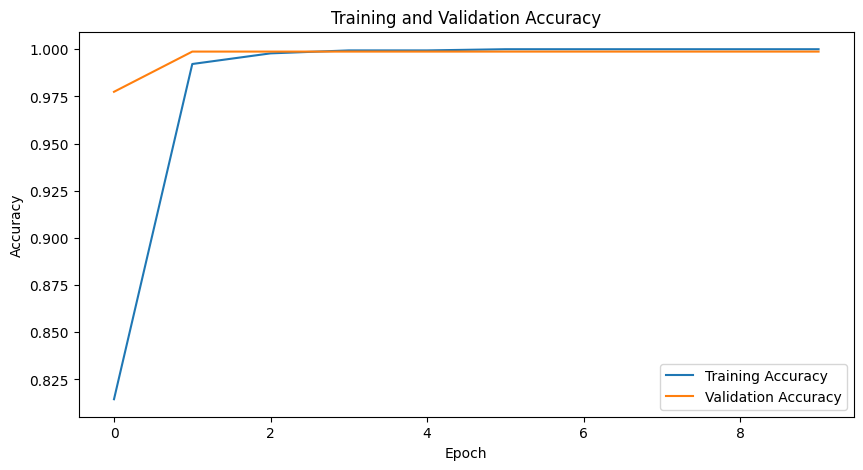

In [ ]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


# Define arguments
class Args:
    def __init__(self, seed):
        self.batch_size = 64 #16
        self.epochs = 10
        self.lr = 0.0001  # Lower the learning rate
        self.momentum = 0.9
        self.seed = seed
        self.regularizer_rate = 0.0
        #self.dropout_rate = 0.7

seeds = [1, 11, 111]

for seed in seeds:
    args = Args(seed)

    # Set random seed for reproducibility
    torch.manual_seed(args.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model, optimizer, and loss function
    model = AlexNet().to(device)
    initialize_weights(model)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=0.0005)
    criterion = nn.CrossEntropyLoss()  # Change to CrossEntropyLoss for multi-class classification

    model = train_model(model, dataloaders, criterion, optimizer, num_epochs=args.epochs, resume_training=False)
    pid = datetime.now().strftime('%Y%m%d%H%M%S')
    torch.save(model.state_dict(), os.path.join(dir_path, model_path, f"alexnet_mnist_wb_cp_cl0_cl2_{seed}" + "train.pt"))

### Left vs. Center Patch

In [ ]:
#Train
#two_cp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_center/train/class_2_half_first'
zero_cp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits_wb/patches_center/train/class_0_half_second'
two_lp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits_wb/patches_left/train/class_2'
zero_lp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits_wb/patches_left/train/class_0_half_first'

#Test
test_two_lp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_left/test/class_2'



# Create datasets for training and testing
#dataset_two_cp = MnistDataset(path=two_cp_path, is_two=1, group_labels=[0] * len(os.listdir(two_cp_path)))
dataset_zero_cp = MnistDataset(path=zero_cp_path, is_two=0, group_labels=[2] * len(os.listdir(zero_cp_path)))
dataset_two_lp = MnistDataset(path=two_lp_path, is_two=1, group_labels=[1] * len(os.listdir(two_lp_path)))
dataset_zero_lp = MnistDataset(path=zero_lp_path, is_two=0, group_labels=[3] * len(os.listdir(zero_lp_path)))
dataset_test_two_lp = MnistDataset(path=test_two_lp_path, is_two=1, group_labels=[1] * len(os.listdir(test_two_lp_path)))

# Concatenate the training datasets
complete_dataset = ConcatDataset((dataset_zero_cp, dataset_zero_lp, dataset_two_lp))

# Set the random seed for reproducibility
seed = 1
torch.manual_seed(seed)

# Split the dataset into training and validation sets (80% train, 20% val)
train_size = int(0.8 * len(complete_dataset))
val_size = len(complete_dataset) - train_size
train_dataset, val_dataset = random_split(complete_dataset, [train_size, val_size])

# Use the test dataset as is
test_dataset = dataset_test_two_lp

batch_size = 64

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Validate input data
#if not validate_inputs(train_loader):
#    print("Input data contains invalid values.")

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_val:", dataset_sizes['val'])
print("num_test:", dataset_sizes['test'])



num_train: 3192
num_val: 798
num_test: 1032


Epoch 1/10
----------


100%|██████████| 50/50 [07:53<00:00,  9.46s/it]


train Loss: 5.5102 Acc: 0.6748


100%|██████████| 13/13 [01:57<00:00,  9.02s/it]


val Loss: 0.5409 Acc: 0.7845
Saving Best Model with Validation Accuracy:  0.7844611528822054
Epoch 2/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.80it/s]


train Loss: 0.5435 Acc: 0.7779


100%|██████████| 13/13 [00:02<00:00,  5.77it/s]


val Loss: 0.5592 Acc: 0.7845
Epoch 3/10
----------


100%|██████████| 50/50 [00:09<00:00,  5.20it/s]


train Loss: 0.5244 Acc: 0.7798


100%|██████████| 13/13 [00:02<00:00,  4.43it/s]


val Loss: 0.5433 Acc: 0.7845
Epoch 4/10
----------


100%|██████████| 50/50 [00:09<00:00,  5.46it/s]


train Loss: 0.5389 Acc: 0.7751


100%|██████████| 13/13 [00:03<00:00,  4.05it/s]


val Loss: 0.5535 Acc: 0.7845
Epoch 5/10
----------


100%|██████████| 50/50 [00:09<00:00,  5.49it/s]


train Loss: 0.5100 Acc: 0.7804


100%|██████████| 13/13 [00:02<00:00,  4.82it/s]


val Loss: 0.5410 Acc: 0.7845
Epoch 6/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.96it/s]


train Loss: 0.5035 Acc: 0.7820


100%|██████████| 13/13 [00:02<00:00,  5.52it/s]


val Loss: 0.5505 Acc: 0.7794
Epoch 7/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.69it/s]


train Loss: 0.5086 Acc: 0.7807


100%|██████████| 13/13 [00:02<00:00,  5.41it/s]


val Loss: 0.5566 Acc: 0.7769
Epoch 8/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.68it/s]


train Loss: 0.4979 Acc: 0.7785


100%|██████████| 13/13 [00:02<00:00,  5.44it/s]


val Loss: 0.5676 Acc: 0.7832
Epoch 9/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.60it/s]


train Loss: 0.4888 Acc: 0.7810


100%|██████████| 13/13 [00:02<00:00,  5.43it/s]


val Loss: 0.5619 Acc: 0.7794
Epoch 10/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.61it/s]


train Loss: 0.4773 Acc: 0.7826


100%|██████████| 13/13 [00:02<00:00,  5.35it/s]


val Loss: 0.6479 Acc: 0.6153
Training complete in 11m 45s
Best Validation Accuracy: 0.7845


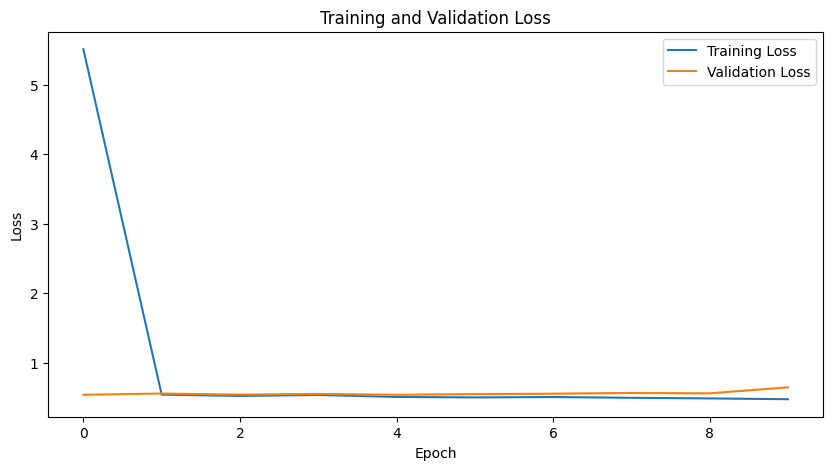

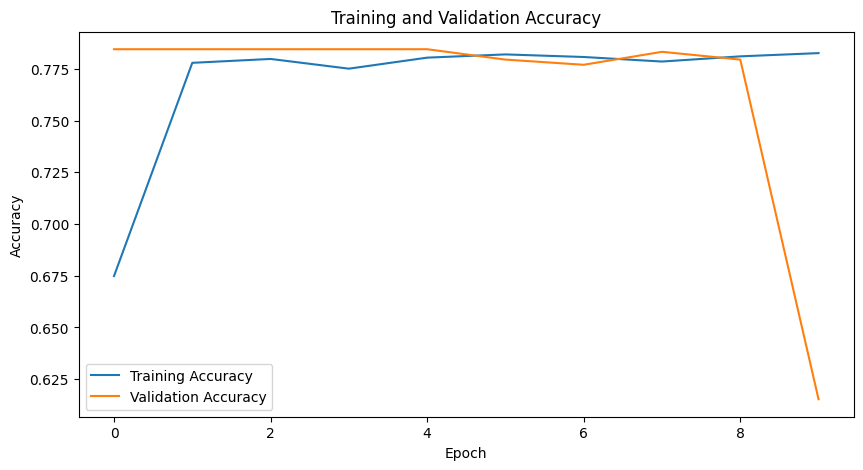

Epoch 1/10
----------


100%|██████████| 50/50 [00:11<00:00,  4.51it/s]


train Loss: 4.5846 Acc: 0.6654


100%|██████████| 13/13 [00:02<00:00,  5.52it/s]


val Loss: 0.5993 Acc: 0.7845
Saving Best Model with Validation Accuracy:  0.7844611528822054
Epoch 2/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.81it/s]


train Loss: 0.5324 Acc: 0.7801


100%|██████████| 13/13 [00:02<00:00,  5.39it/s]


val Loss: 0.5292 Acc: 0.7845
Epoch 3/10
----------


100%|██████████| 50/50 [00:09<00:00,  5.19it/s]


train Loss: 0.5249 Acc: 0.7801


100%|██████████| 13/13 [00:03<00:00,  3.96it/s]


val Loss: 0.5526 Acc: 0.7782
Epoch 4/10
----------


100%|██████████| 50/50 [00:09<00:00,  5.49it/s]


train Loss: 0.5110 Acc: 0.7813


100%|██████████| 13/13 [00:02<00:00,  4.36it/s]


val Loss: 0.5349 Acc: 0.7845
Epoch 5/10
----------


100%|██████████| 50/50 [00:09<00:00,  5.04it/s]


train Loss: 0.5036 Acc: 0.7810


100%|██████████| 13/13 [00:02<00:00,  4.99it/s]


val Loss: 0.5509 Acc: 0.7707
Epoch 6/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.64it/s]


train Loss: 0.4991 Acc: 0.7804


100%|██████████| 13/13 [00:02<00:00,  5.37it/s]


val Loss: 0.5428 Acc: 0.7832
Epoch 7/10
----------


100%|██████████| 50/50 [00:11<00:00,  4.53it/s]


train Loss: 0.4890 Acc: 0.7788


100%|██████████| 13/13 [00:02<00:00,  5.29it/s]


val Loss: 0.5549 Acc: 0.7807
Epoch 8/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.64it/s]


train Loss: 0.4922 Acc: 0.7779


100%|██████████| 13/13 [00:02<00:00,  5.41it/s]


val Loss: 0.5923 Acc: 0.7845
Epoch 9/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.62it/s]


train Loss: 0.4735 Acc: 0.7751


100%|██████████| 13/13 [00:02<00:00,  5.39it/s]


val Loss: 0.5719 Acc: 0.7732
Epoch 10/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.72it/s]


train Loss: 0.4736 Acc: 0.7791


100%|██████████| 13/13 [00:02<00:00,  5.27it/s]


val Loss: 0.5855 Acc: 0.7807
Training complete in 2m 10s
Best Validation Accuracy: 0.7845


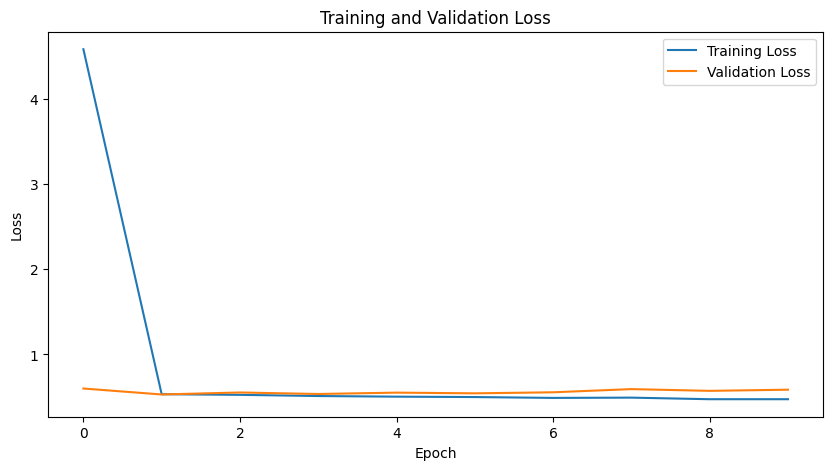

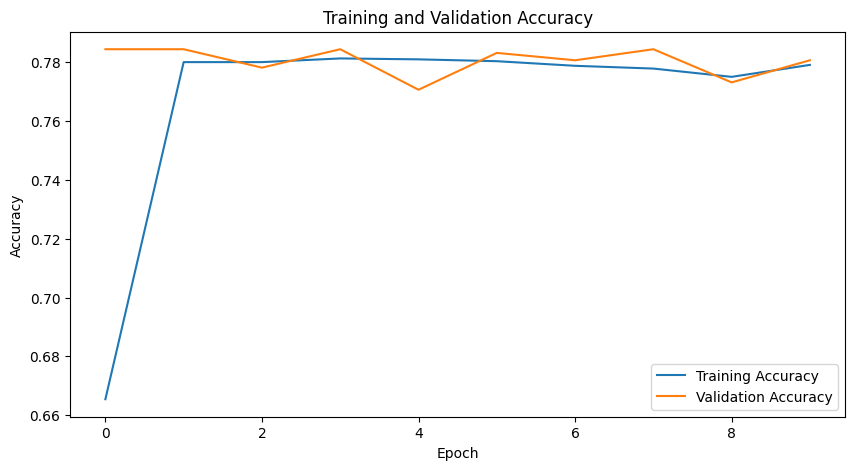

Epoch 1/10
----------


100%|██████████| 50/50 [00:11<00:00,  4.39it/s]


train Loss: 4.0766 Acc: 0.6754


100%|██████████| 13/13 [00:02<00:00,  5.42it/s]


val Loss: 0.5446 Acc: 0.7845
Saving Best Model with Validation Accuracy:  0.7844611528822054
Epoch 2/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.99it/s]


train Loss: 0.5516 Acc: 0.7785


100%|██████████| 13/13 [00:03<00:00,  4.25it/s]


val Loss: 0.5658 Acc: 0.7732
Epoch 3/10
----------


100%|██████████| 50/50 [00:09<00:00,  5.38it/s]


train Loss: 0.5258 Acc: 0.7798


100%|██████████| 13/13 [00:03<00:00,  4.09it/s]


val Loss: 0.5328 Acc: 0.7845
Epoch 4/10
----------


100%|██████████| 50/50 [00:09<00:00,  5.32it/s]


train Loss: 0.5135 Acc: 0.7785


100%|██████████| 13/13 [00:02<00:00,  4.65it/s]


val Loss: 0.5440 Acc: 0.7845
Epoch 5/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.95it/s]


train Loss: 0.5010 Acc: 0.7801


100%|██████████| 13/13 [00:02<00:00,  5.61it/s]


val Loss: 0.5476 Acc: 0.7845
Epoch 6/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.68it/s]


train Loss: 0.4963 Acc: 0.7807


100%|██████████| 13/13 [00:02<00:00,  5.60it/s]


val Loss: 0.5494 Acc: 0.7845
Epoch 7/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.75it/s]


train Loss: 0.4867 Acc: 0.7810


100%|██████████| 13/13 [00:02<00:00,  5.47it/s]


val Loss: 0.5733 Acc: 0.7845
Epoch 8/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.71it/s]


train Loss: 0.4826 Acc: 0.7788


100%|██████████| 13/13 [00:02<00:00,  5.56it/s]


val Loss: 0.5653 Acc: 0.7807
Epoch 9/10
----------


100%|██████████| 50/50 [00:10<00:00,  4.79it/s]


train Loss: 0.4917 Acc: 0.7801


100%|██████████| 13/13 [00:02<00:00,  5.53it/s]


val Loss: 0.5746 Acc: 0.7632
Epoch 10/10
----------


100%|██████████| 50/50 [00:09<00:00,  5.14it/s]


train Loss: 0.4669 Acc: 0.7798


100%|██████████| 13/13 [00:03<00:00,  4.18it/s]


val Loss: 0.5742 Acc: 0.7657
Training complete in 2m 9s
Best Validation Accuracy: 0.7845


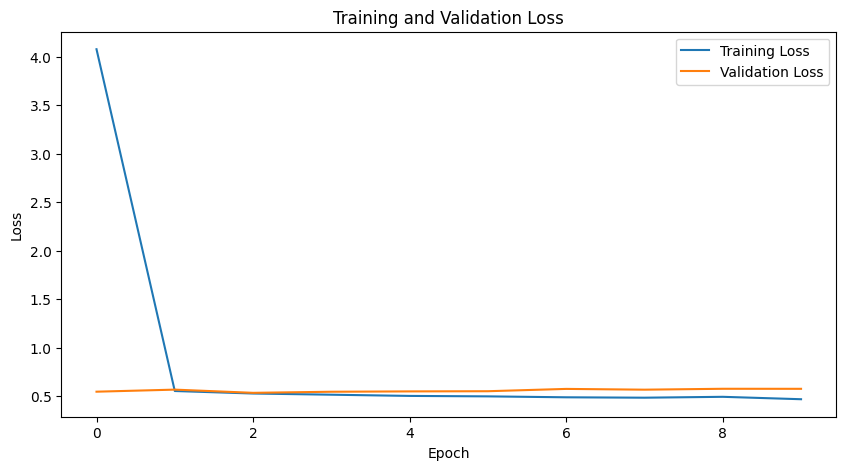

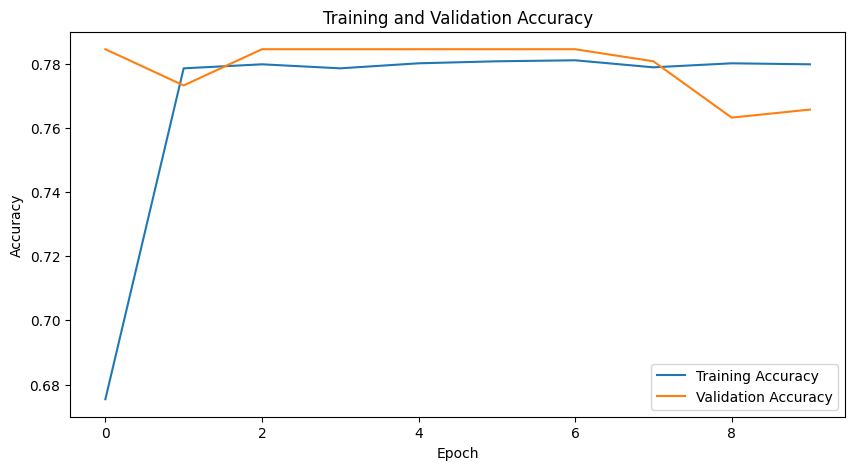

In [ ]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


class Args:
    def __init__(self, seed):
        self.batch_size = 64 #16
        self.epochs = 10
        self.lr = 0.0001  # Lower the learning rate
        self.momentum = 0.9
        self.seed = seed
        self.regularizer_rate = 0.0
        #self.dropout_rate = 0.7

seeds = [1, 11, 111]

for seed in seeds:
    args = Args(seed)

    # Set random seed for reproducibility
    torch.manual_seed(args.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model, optimizer, and loss function
    model = AlexNet().to(device)
    initialize_weights(model)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=0.0005)
    criterion = nn.CrossEntropyLoss()  # Change to CrossEntropyLoss for multi-class classification

    model = train_model(model, dataloaders, criterion, optimizer, num_epochs=args.epochs, resume_training=False)
    pid = datetime.now().strftime('%Y%m%d%H%M%S')
    torch.save(model.state_dict(), os.path.join(dir_path, model_path, f"alexnet_mnist_wb_cp_lp_cl0_cl2_{seed}" + "train.pt"))

## Activation extraction

### Original vs. Colored BG

#### Correlation

Computing activations and saving to activations.npy


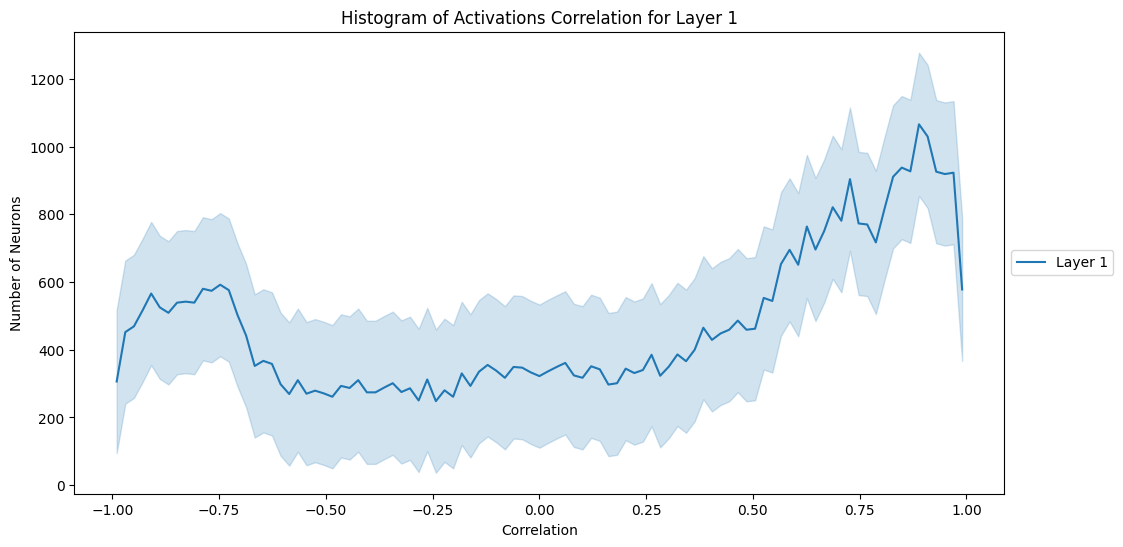

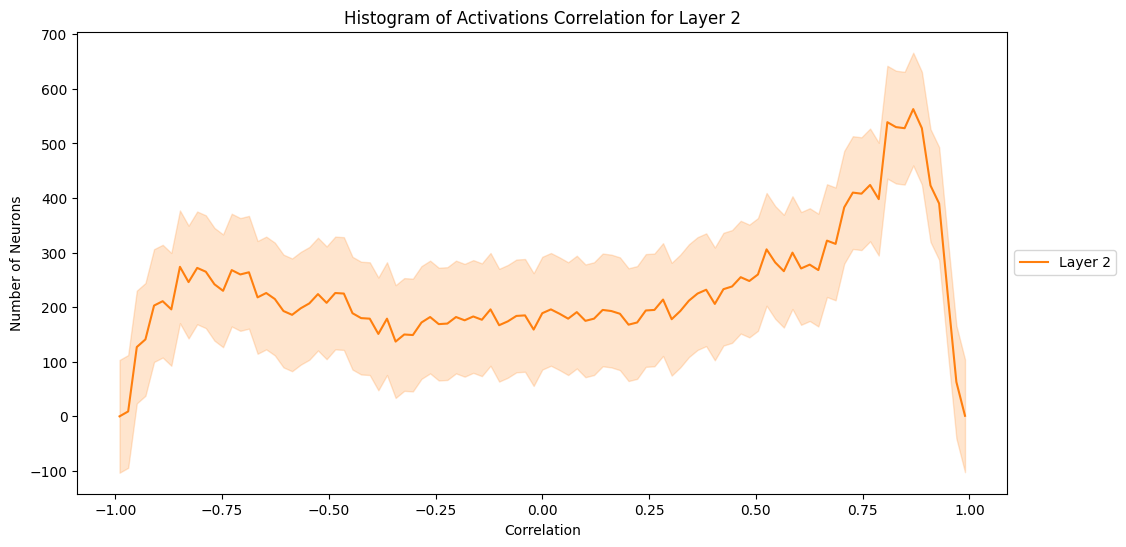

<ipython-input-12-a2744998f7bd>:190: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])


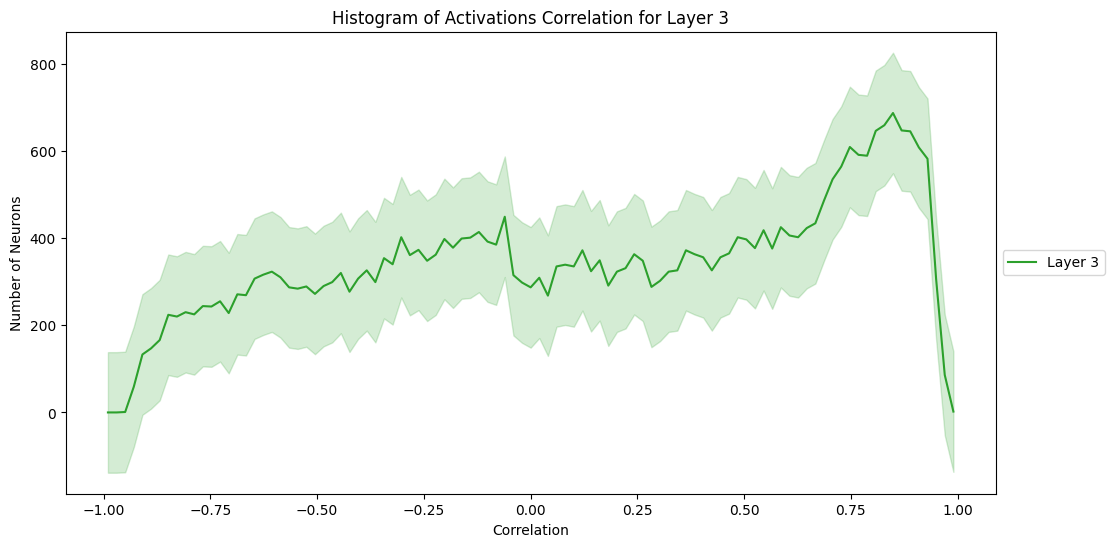

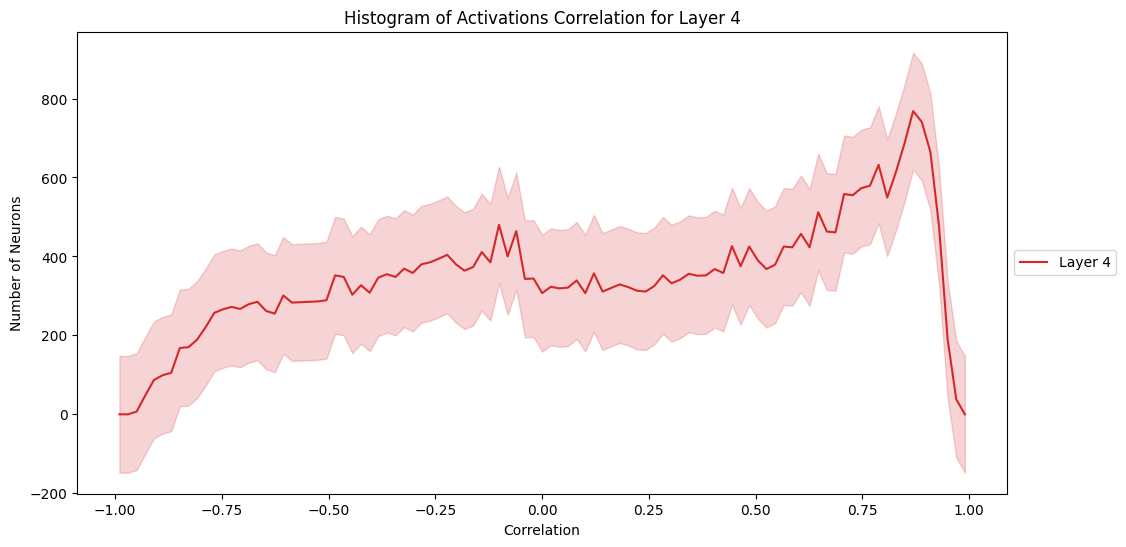

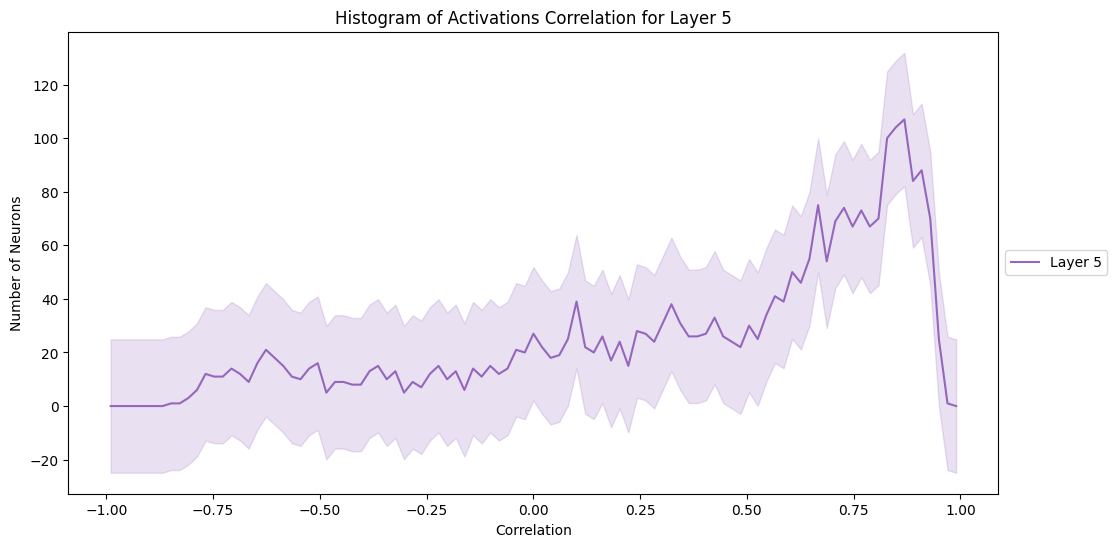

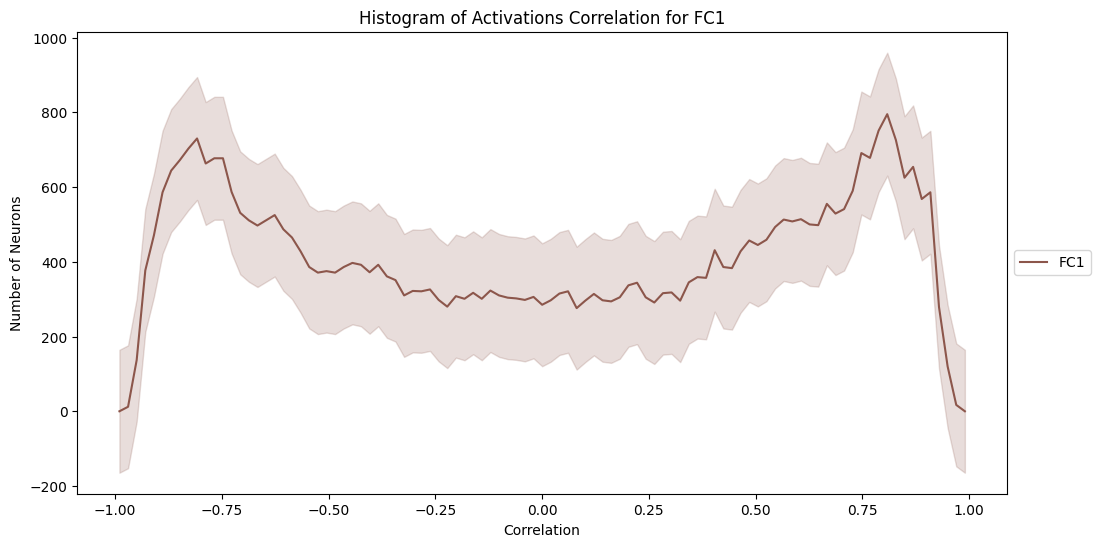

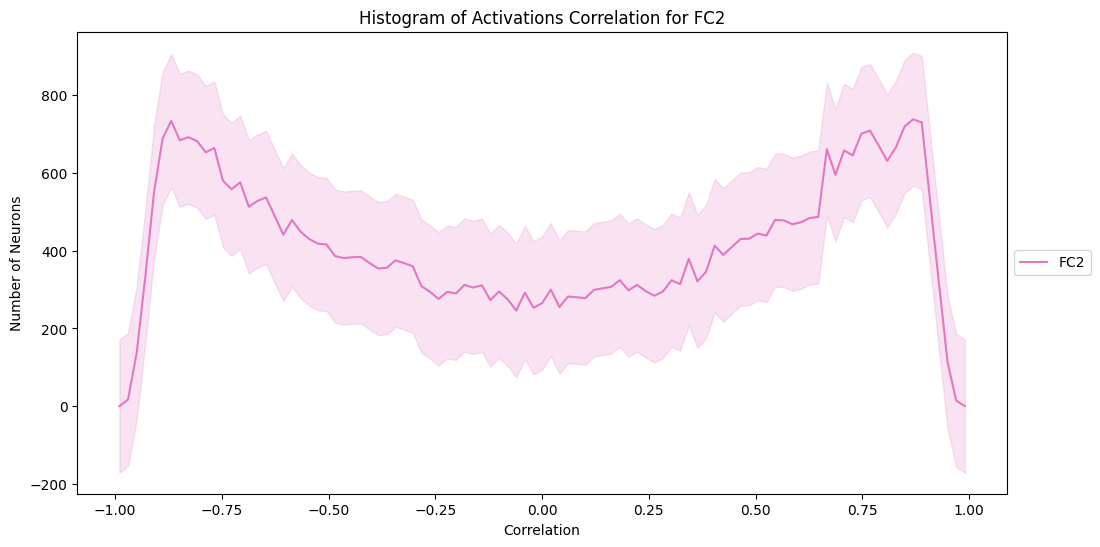

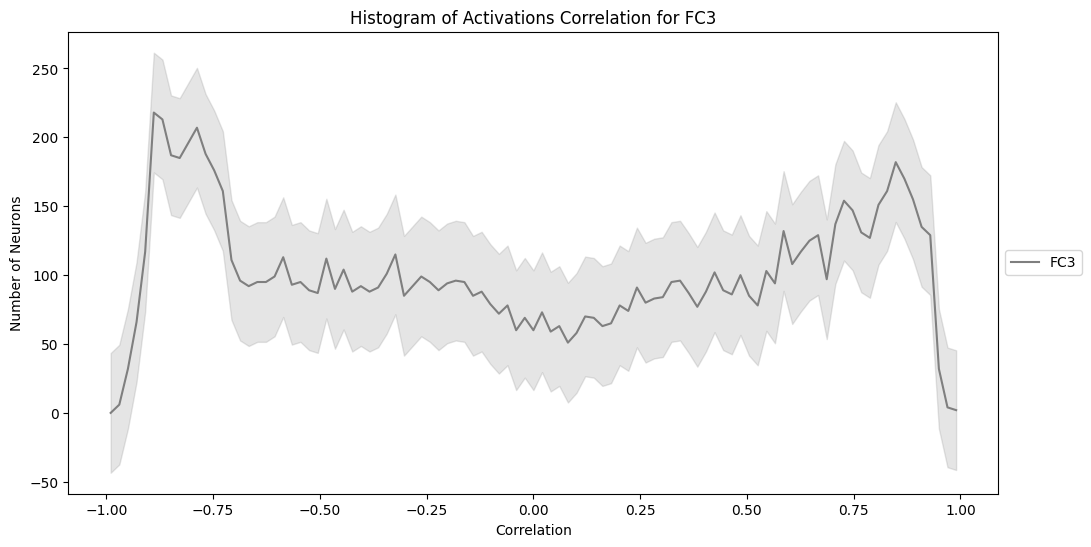

<ipython-input-12-a2744998f7bd>:228: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])


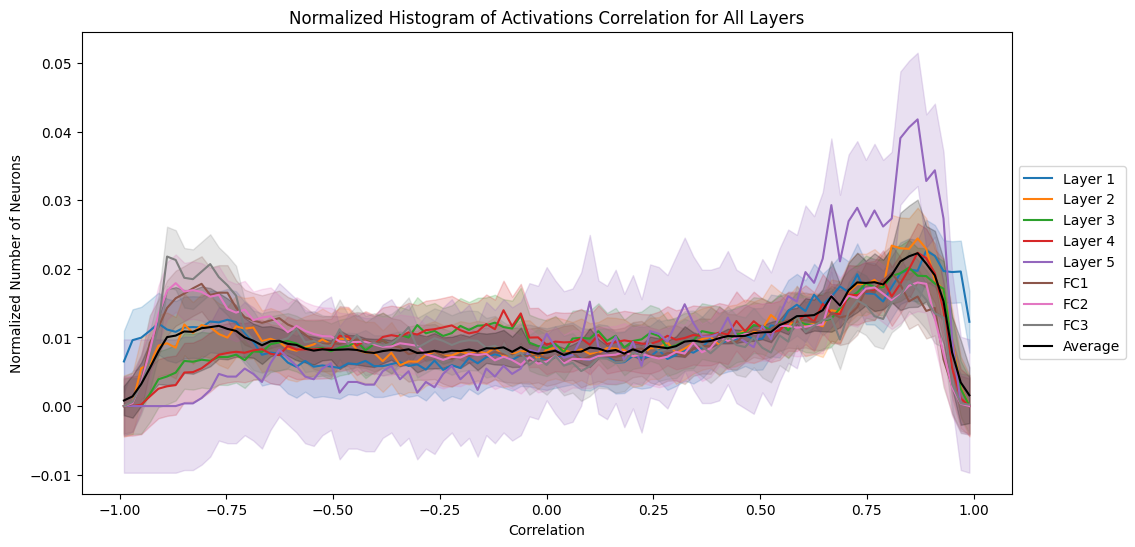

In [ ]:
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import gc
from scipy.stats import pearsonr
from torch.utils.data import DataLoader, Dataset

def load_model(model_path):
    model = AlexNet()
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocessing function
preprocess = transforms.Compose([
    transforms.Resize((64, 64)),  # Match the resize shape in MnistDataset
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Match the normalization values in MnistDataset
])


class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image


def preprocess_and_extract_activations(model, dataloader, layer):
    activations = []
    with torch.no_grad():
        for image_tensor in dataloader:
            image_tensor = image_tensor.to(device)

            # Extract activations according to the AlexNet model's structure
            if layer == 0:  # After Layer 1
                tensor = model.layer1(image_tensor)
            elif layer == 1:  # After Layer 2
                tensor = model.layer2(model.layer1(image_tensor))
            elif layer == 2:  # After Layer 3
                tensor = model.layer3(model.layer2(model.layer1(image_tensor)))
            elif layer == 3:  # After Layer 4
                tensor = model.layer4(model.layer3(model.layer2(model.layer1(image_tensor))))
            elif layer == 4:  # After Layer 5
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
            elif layer == 5:  # After FC1
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc1(tensor)
            elif layer == 6:  # After FC2
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc2(model.fc1(tensor))
            elif layer == 7:  # After FC3 (Output)
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc3(model.fc2(model.fc1(tensor)))

            activation = tensor.cpu().numpy()
            activations.append(activation)

            # Clear memory
            del tensor
            torch.cuda.empty_cache()
            gc.collect()

    return activations


def process_images_in_folder(model, folder_path, layer, batch_size=10):
    all_layer_activations = []

    image_paths = [os.path.join(root, file)
                   for root, dirs, files in os.walk(folder_path)
                   for file in files if file.endswith('.png')]

    dataset = ImageDataset(image_paths=image_paths, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Process in smaller batches to avoid memory issues
    for i, batch in enumerate(dataloader):
        batch_activations = preprocess_and_extract_activations(model, [batch], layer)
        all_layer_activations.extend(batch_activations)
        torch.cuda.empty_cache()
        gc.collect()

    return all_layer_activations

def flatten_and_align_activations(activations_list):
    # Flatten activations and find the maximum length
    flat_activations = [act.flatten() for act in activations_list]
    max_length = max(len(act) for act in flat_activations)

    # Pad or truncate activations to the maximum length
    aligned_activations = []
    for activation in flat_activations:
        if len(activation) < max_length:
            padded_activation = np.pad(activation, (0, max_length - len(activation)), 'constant')
        else:
            padded_activation = activation[:max_length]
        aligned_activations.append(padded_activation)
    return np.vstack(aligned_activations)

def save_activations(all_layer_activations, folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_wb/{folder_name}/{filename}'
    os.makedirs(os.path.dirname(drive_path), exist_ok=True)
    np.save(drive_path, all_layer_activations)

def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_wb/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

def compute_activations_for_layers(model_paths, patch_folder, no_patch_folder, layers, activations_file='activations.npy'):
    if os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_wb/original/{activations_file}') and \
       os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_wb/background/{activations_file}'):
        print(f"Loading activations from {activations_file}")
        wp_activations = load_activations('background', activations_file)
        wo_activations = load_activations('original', activations_file)
        return {layer: {'wp': wp_activations[layer], 'wo': wo_activations[layer]} for layer in layers}

    print(f"Computing activations and saving to {activations_file}")
    all_layer_activations = {layer: {'wp': [], 'wo': []} for layer in layers}

    for model_path in model_paths:
        model = load_model(model_path)
        for layer in layers:
            wp_activations = process_images_in_folder(model, patch_folder, layer)
            wo_activations = process_images_in_folder(model, no_patch_folder, layer)
            all_layer_activations[layer]['wp'].append(flatten_and_align_activations(wp_activations))
            all_layer_activations[layer]['wo'].append(flatten_and_align_activations(wo_activations))
        del model  # Free model resources after use
        torch.cuda.empty_cache()
        gc.collect()

    for layer in layers:
        save_activations(all_layer_activations[layer]['wp'], 'background', f'{activations_file}_{layer}.npy')
        save_activations(all_layer_activations[layer]['wo'], 'original', f'{activations_file}_{layer}.npy')

    return all_layer_activations

def compute_avg_std_activations(all_layer_activations, layers):
    layer_avg_std = {layer: {'wp_avg': None, 'wo_avg': None, 'wp_std': None, 'wo_std': None} for layer in layers}

    for layer in layers:
        wp_all_models_layer_activations = np.stack(all_layer_activations[layer]['wp'], axis=0)
        wo_all_models_layer_activations = np.stack(all_layer_activations[layer]['wo'], axis=0)

        wp_avg = np.mean(wp_all_models_layer_activations, axis=0)
        wo_avg = np.mean(wo_all_models_layer_activations, axis=0)
        wp_std = np.std(wp_all_models_layer_activations, axis=0)
        wo_std = np.std(wo_all_models_layer_activations, axis=0)

        layer_avg_std[layer]['wp_avg'] = wp_avg
        layer_avg_std[layer]['wo_avg'] = wo_avg
        layer_avg_std[layer]['wp_std'] = wp_std
        layer_avg_std[layer]['wo_std'] = wo_std

    return layer_avg_std

def plot_histogram_for_layer(layer_avg_std, layer, layer_name, color):
    wp_avg = layer_avg_std[layer]['wp_avg']
    wo_avg = layer_avg_std[layer]['wo_avg']
    wp_std = layer_avg_std[layer]['wp_std']
    wo_std = layer_avg_std[layer]['wo_std']

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
    combined_activations = np.vstack((wo_avg, wp_avg))

    A = []
    for ii in range(combined_activations.shape[1]):
        A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

    B = np.histogram(A, bins=x)

    bin_means = B[0]
    bin_stds = np.std(bin_means)

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(xaxis, bin_means, '-', color=color, label=layer_name)
    ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=color, alpha=0.2)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Histogram of Activations Correlation for {layer_name}')
    plt.xlabel('Correlation')
    plt.ylabel('Number of Neurons')
    plt.show()

def plot_combined_histogram(layer_avg_std, layer_names, colors):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    all_layer_bin_means = []

    for idx, (layer, layer_name) in enumerate(layer_names.items()):
        wp_avg = layer_avg_std[layer]['wp_avg']
        wo_avg = layer_avg_std[layer]['wo_avg']
        wp_std = layer_avg_std[layer]['wp_std']
        wo_std = layer_avg_std[layer]['wo_std']

        patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
        combined_activations = np.vstack((wo_avg, wp_avg))

        A = []
        for ii in range(combined_activations.shape[1]):
            A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

        B = np.histogram(A, bins=x)

        bin_means = B[0] / np.sum(B[0])  # Normalize the bin counts
        bin_stds = np.std(bin_means)

        all_layer_bin_means.append(bin_means)

        ax.plot(xaxis, bin_means, '-', color=colors[idx], label=layer_name)
        ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=colors[idx], alpha=0.2)

    # Compute average and standard deviation of the normalized histograms across layers
    all_layer_bin_means = np.array(all_layer_bin_means)
    avg_bin_means = np.mean(all_layer_bin_means, axis=0)
    std_bin_means = np.std(all_layer_bin_means, axis=0)

    ax.plot(xaxis, avg_bin_means, '-', color='black', label='Average')
    ax.fill_between(xaxis, avg_bin_means - std_bin_means, avg_bin_means + std_bin_means, color='black', alpha=0.2)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Normalized Histogram of Activations Correlation for All Layers')
    plt.xlabel('Correlation')
    plt.ylabel('Normalized Number of Neurons')
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]  # Adjusted to match the custom model layers
layer_names = {
    0: "Layer 1",
    1: "Layer 2",
    2: "Layer 3",
    3: "Layer 4",
    4: "Layer 5",
    5: "FC1",
    6: "FC2",
    7: "FC3"
}
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']

bg_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/background/test/class_2'
org_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_2'

model_paths = [
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_wb_bg_cl0_cl2_1train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_wb_bg_cl0_cl2_11train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_wb_bg_cl0_cl2_111train.pt"
]

all_layer_activations = compute_activations_for_layers(model_paths, bg_mnist_folder_path, org_mnist_folder_path, layers_of_interest)
layer_avg_std = compute_avg_std_activations(all_layer_activations, layers_of_interest)

# Plot histograms for each layer
for idx, (layer, layer_name) in enumerate(layer_names.items()):
    plot_histogram_for_layer(layer_avg_std, layer, layer_name, colors[idx])

# Plot combined histogram for all layers
plot_combined_histogram(layer_avg_std, layer_names, colors)


#### Two sample t-test

Layer 0:
  WP Activations:
    Mean: 2.2222
  WO Activations:
    Mean: 1.8569
  T-Test:
    T-statistic: 2.2378
    P-value: 0.0515
    Percentage of neurons with p-value <= 0.05: 87.27%
    Percentage of neurons with p-value <= 0.02: 85.19%
--------------------------------------------------
Layer 1:
  WP Activations:
    Mean: 1.9407
  WO Activations:
    Mean: 1.6533
  T-Test:
    T-statistic: 1.4585
    P-value: 0.0886
    Percentage of neurons with p-value <= 0.05: 79.10%
    Percentage of neurons with p-value <= 0.02: 75.82%
--------------------------------------------------
Layer 2:
  WP Activations:
    Mean: 0.7468
  WO Activations:
    Mean: 0.5633
  T-Test:
    T-statistic: nan
    P-value: nan
    Percentage of neurons with p-value <= 0.05: 78.59%
    Percentage of neurons with p-value <= 0.02: 75.01%
--------------------------------------------------
Layer 3:
  WP Activations:
    Mean: 0.4209
  WO Activations:
    Mean: 0.2993
  T-Test:
    T-statistic: nan
    P-value: n

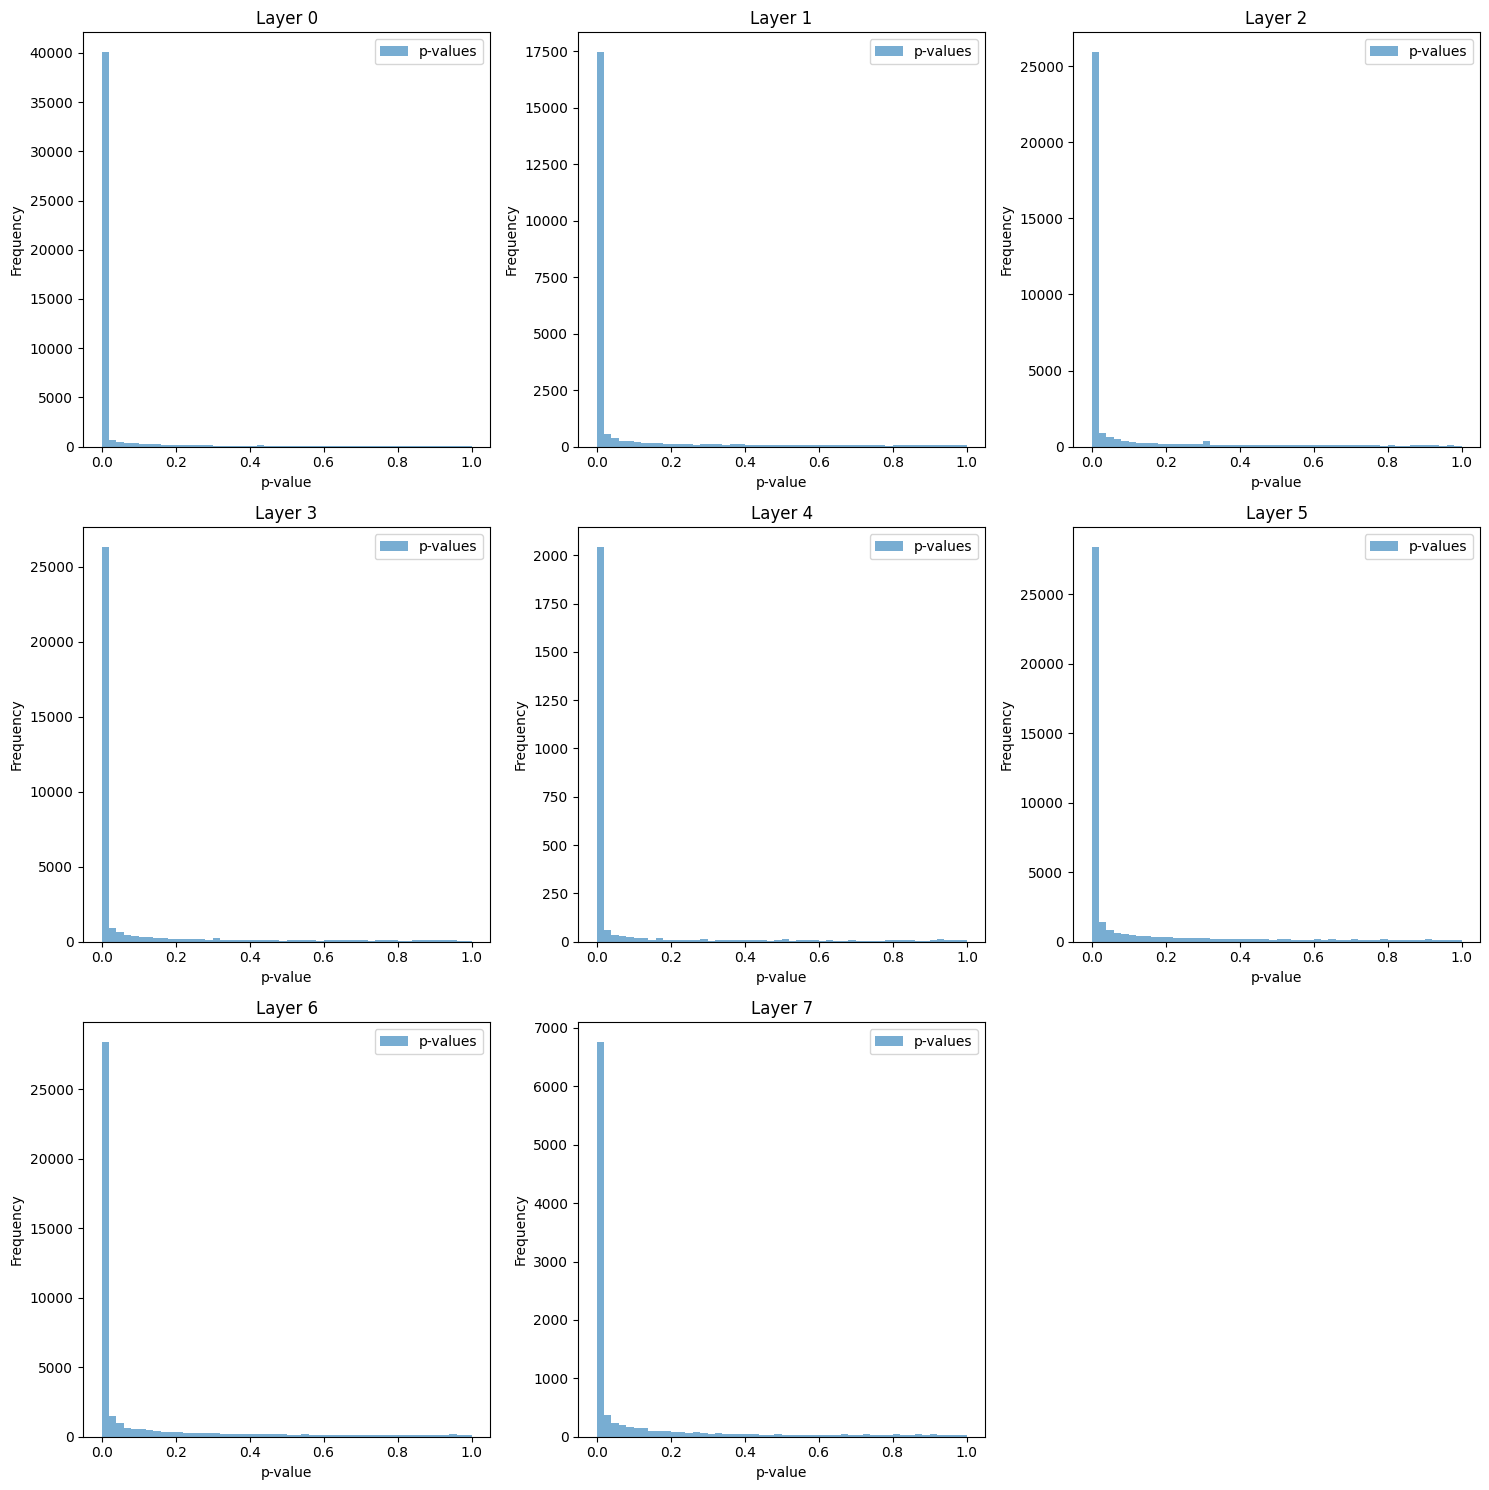

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Load activations
def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_wb/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True)

# Perform two-sample t-tests comparing neuron activations
def perform_two_sample_t_tests(background_activations, original_activations):
    t_test_results = {}
    for layer in background_activations.keys():
        wp_activations = np.vstack(background_activations[layer])
        wo_activations = np.vstack(original_activations[layer])

        # Perform two-sample t-test for each neuron
        ttest_result = ttest_ind(wp_activations, wo_activations, axis=0)

        t_test_results[layer] = {
            'ttest': ttest_result,
            'wp_means': np.mean(wp_activations, axis=0),
            'wo_means': np.mean(wo_activations, axis=0)
        }
    return t_test_results

# Print t-test results with percentages of neurons below or equal to specific p-values
def print_t_test_results(t_test_results):
    for layer, results in t_test_results.items():
        wp_means = results['wp_means']
        wo_means = results['wo_means']
        ttest = results['ttest']

        # Calculate the percentage of neurons below or equal to specific p-value thresholds
        p_values = ttest.pvalue
        below_or_equal_0_05 = np.mean(p_values <= 0.05) * 100
        below_or_equal_0_02 = np.mean(p_values <= 0.02) * 100

        print(f"Layer {layer}:")
        print("  WP Activations:")
        print(f"    Mean: {wp_means.mean():.4f}")
        print("  WO Activations:")
        print(f"    Mean: {wo_means.mean():.4f}")
        print("  T-Test:")
        print(f"    T-statistic: {ttest.statistic.mean():.4f}")
        print(f"    P-value: {ttest.pvalue.mean():.4f}")
        print(f"    Percentage of neurons with p-value <= 0.05: {below_or_equal_0_05:.2f}%")
        print(f"    Percentage of neurons with p-value <= 0.02: {below_or_equal_0_02:.2f}%")
        print("-" * 50)

# Plot the p-values to visualize significance
def plot_p_values(t_test_results):
    num_layers = len(t_test_results)
    num_cols = 3
    num_rows = (num_layers + num_cols - 1) // num_cols

    plt.figure(figsize=(15, 5 * num_rows))
    for idx, (layer, results) in enumerate(t_test_results.items()):
        p_values = results['ttest'].pvalue

        ax = plt.subplot(num_rows, num_cols, idx + 1)
        ax.hist(p_values, bins=50, alpha=0.6, label='p-values')
        ax.set_title(f'Layer {layer}')
        ax.set_xlabel('p-value')
        ax.set_ylabel('Frequency')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]  # Adjusted to match the custom model layers

# Load activations for both background and original conditions
background_activations = {layer: load_activations('background', f'activations.npy_{layer}.npy') for layer in layers_of_interest}
original_activations = {layer: load_activations('original', f'activations.npy_{layer}.npy') for layer in layers_of_interest}

# Perform two-sample t-tests
t_test_results = perform_two_sample_t_tests(background_activations, original_activations)

# Print t-test results
print_t_test_results(t_test_results)

# Plot p-values
plot_p_values(t_test_results)


### Original vs. colored Digit

#### Correlation

Computing activations and saving to activations.npy


<ipython-input-14-6ce7408a3f23>:191: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])


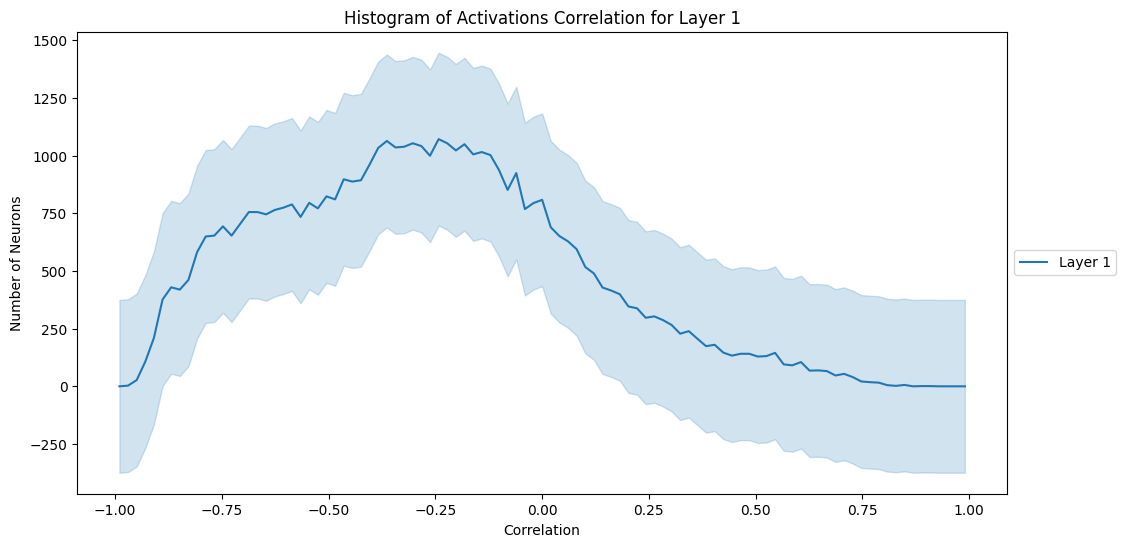

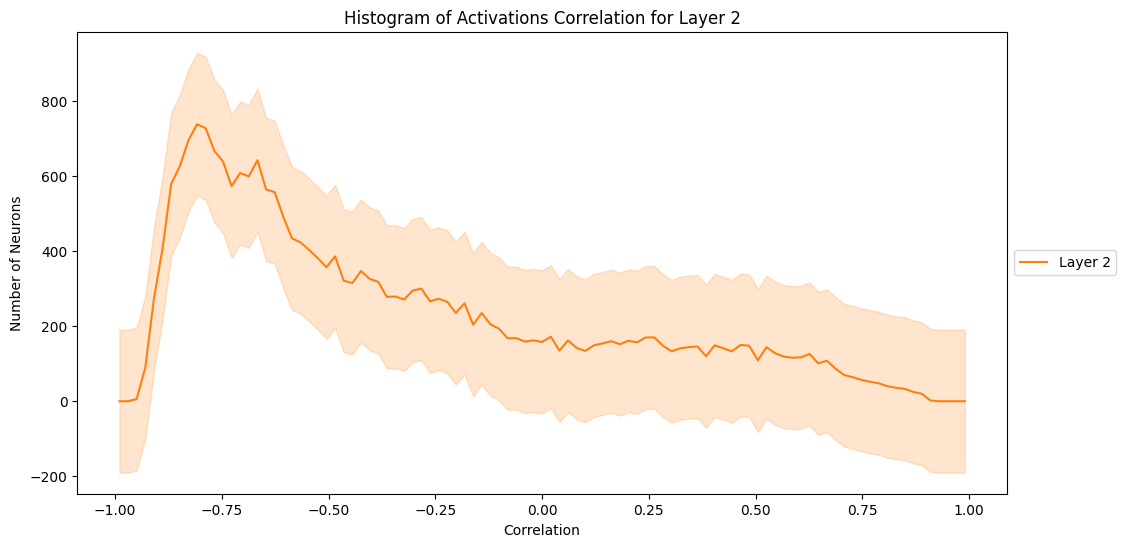

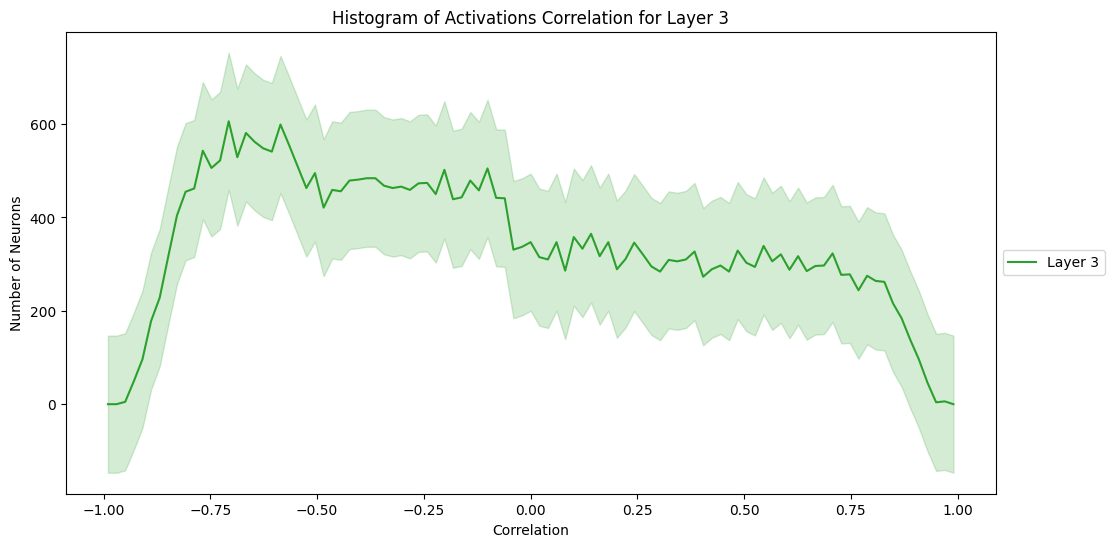

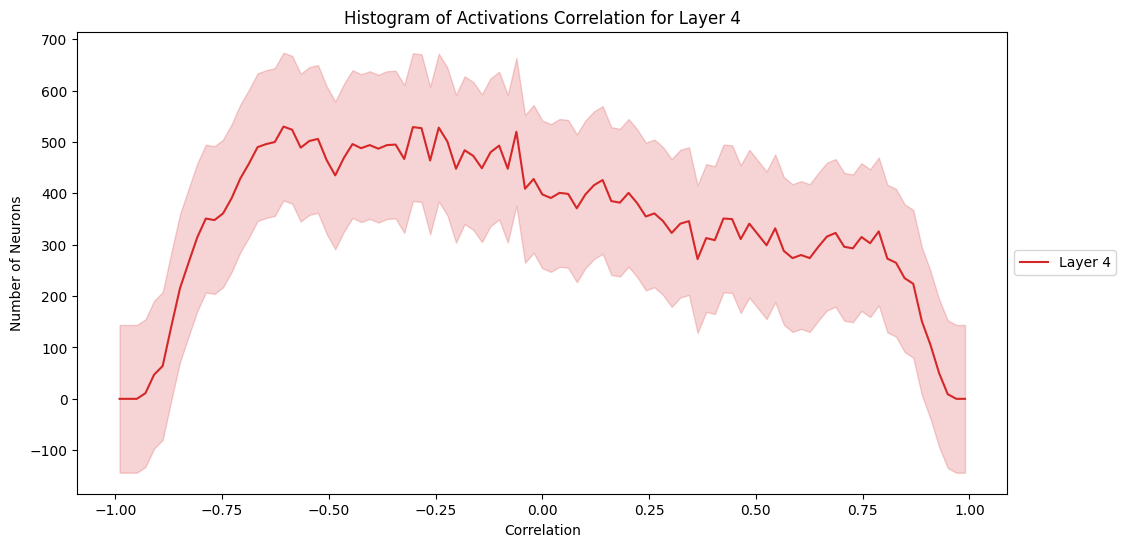

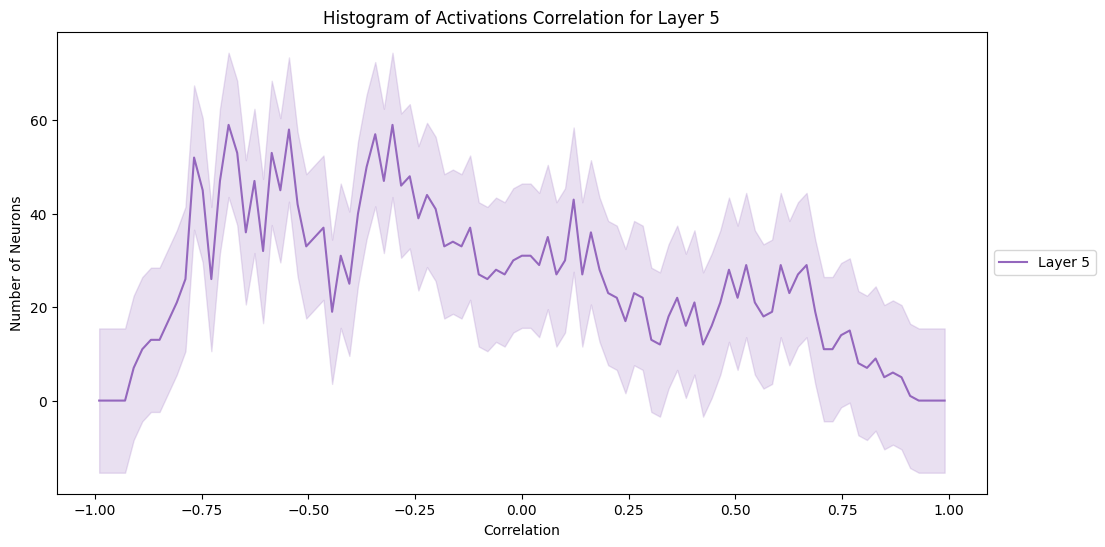

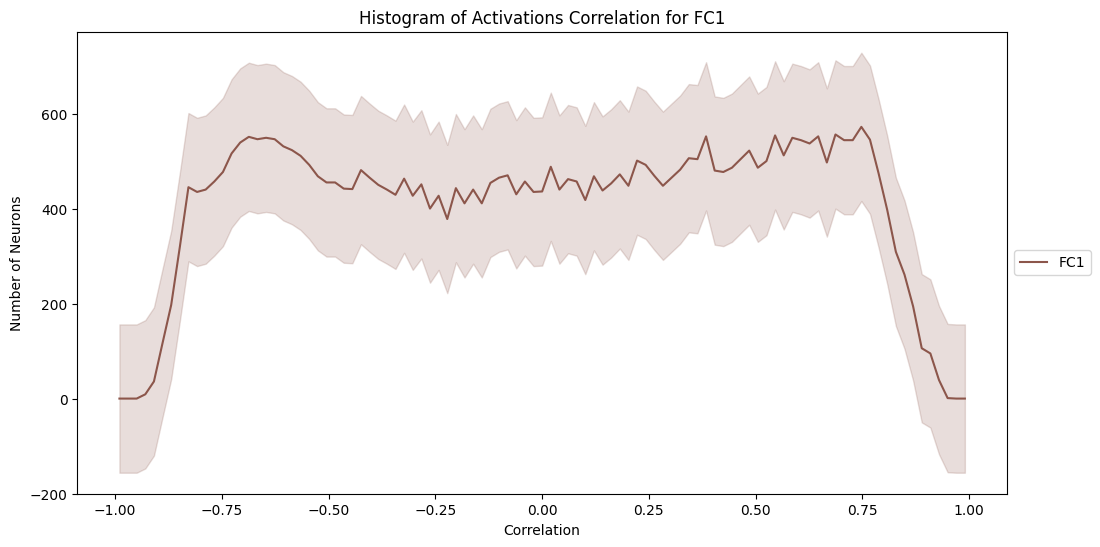

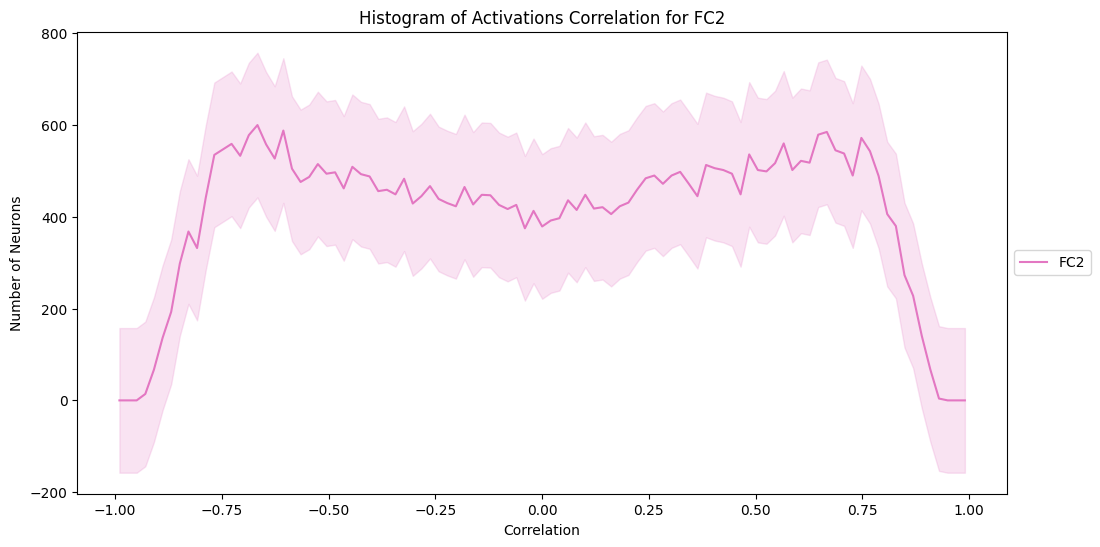

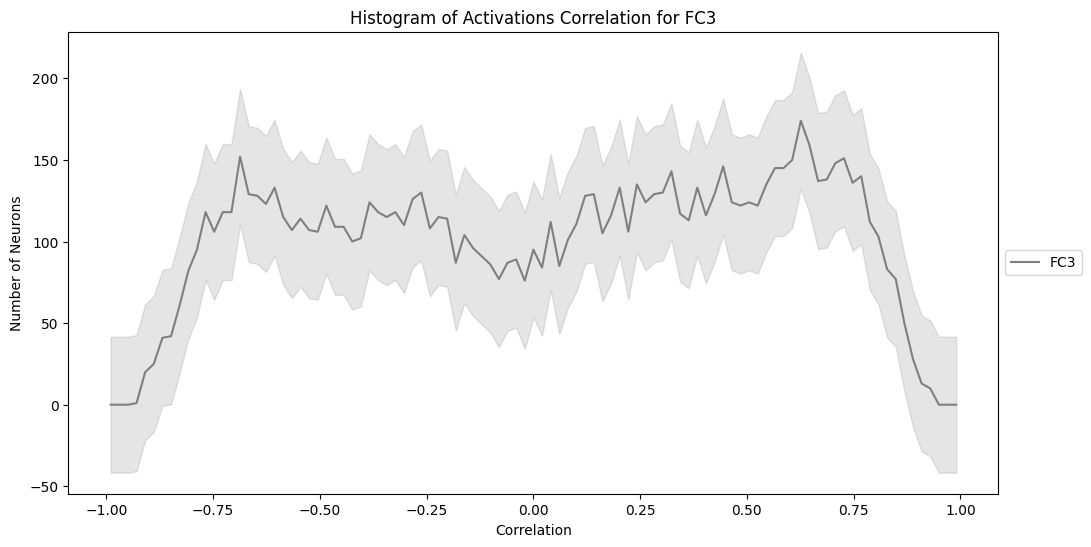

<ipython-input-14-6ce7408a3f23>:229: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])


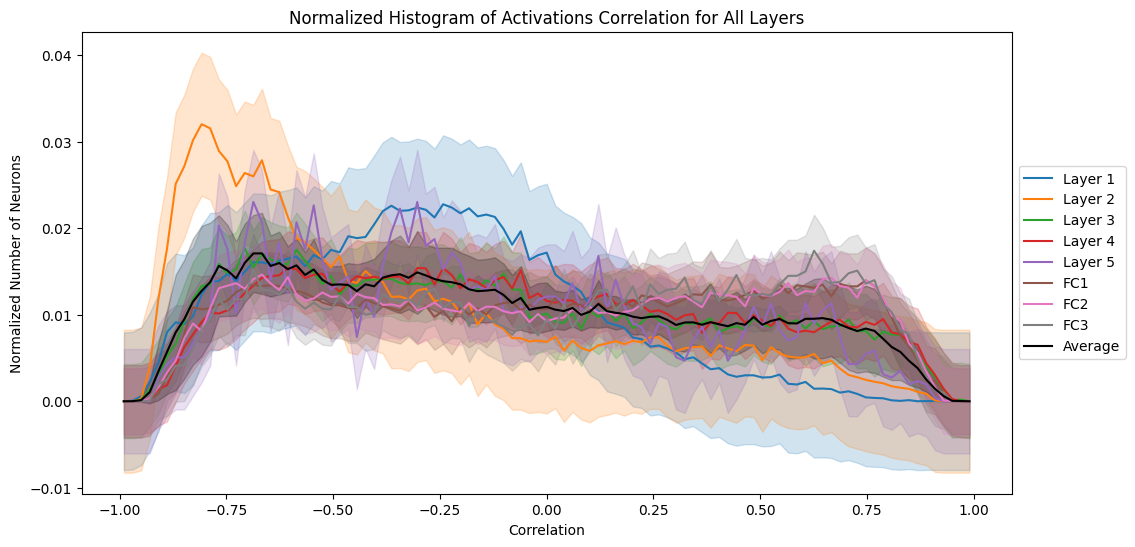

In [ ]:
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import gc
from scipy.stats import pearsonr
from torch.utils.data import DataLoader, Dataset

def load_model(model_path):
    model = AlexNet()
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocessing function
preprocess = transforms.Compose([
    transforms.Resize((64, 64)),  # Match the resize shape in MnistDataset
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Match the normalization values in MnistDataset
])


class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image


def preprocess_and_extract_activations(model, dataloader, layer):
    activations = []
    with torch.no_grad():
        for image_tensor in dataloader:
            image_tensor = image_tensor.to(device)

            # Extract activations according to the AlexNet model's structure
            if layer == 0:  # After Layer 1
                tensor = model.layer1(image_tensor)
            elif layer == 1:  # After Layer 2
                tensor = model.layer2(model.layer1(image_tensor))
            elif layer == 2:  # After Layer 3
                tensor = model.layer3(model.layer2(model.layer1(image_tensor)))
            elif layer == 3:  # After Layer 4
                tensor = model.layer4(model.layer3(model.layer2(model.layer1(image_tensor))))
            elif layer == 4:  # After Layer 5
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
            elif layer == 5:  # After FC1
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc1(tensor)
            elif layer == 6:  # After FC2
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc2(model.fc1(tensor))
            elif layer == 7:  # After FC3 (Output)
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc3(model.fc2(model.fc1(tensor)))

            activation = tensor.cpu().numpy()
            activations.append(activation)

            # Clear memory
            del tensor
            torch.cuda.empty_cache()
            gc.collect()

    return activations



def process_images_in_folder(model, folder_path, layer, batch_size=10):
    all_layer_activations = []

    image_paths = [os.path.join(root, file)
                   for root, dirs, files in os.walk(folder_path)
                   for file in files if file.endswith('.png')]

    dataset = ImageDataset(image_paths=image_paths, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Process in smaller batches to avoid memory issues
    for i, batch in enumerate(dataloader):
        batch_activations = preprocess_and_extract_activations(model, [batch], layer)
        all_layer_activations.extend(batch_activations)
        torch.cuda.empty_cache()
        gc.collect()

    return all_layer_activations

def flatten_and_align_activations(activations_list):
    # Flatten activations and find the maximum length
    flat_activations = [act.flatten() for act in activations_list]
    max_length = max(len(act) for act in flat_activations)

    # Pad or truncate activations to the maximum length
    aligned_activations = []
    for activation in flat_activations:
        if len(activation) < max_length:
            padded_activation = np.pad(activation, (0, max_length - len(activation)), 'constant')
        else:
            padded_activation = activation[:max_length]
        aligned_activations.append(padded_activation)
    return np.vstack(aligned_activations)

def save_activations(all_layer_activations, folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_wb/{folder_name}/{filename}'
    os.makedirs(os.path.dirname(drive_path), exist_ok=True)
    np.save(drive_path, all_layer_activations)

def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_wb/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

def compute_activations_for_layers(model_paths, patch_folder, no_patch_folder, layers, activations_file='activations.npy'):
    if os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_wb/original/{activations_file}') and \
       os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_wb/foreground/{activations_file}'):
        print(f"Loading activations from {activations_file}")
        wp_activations = load_activations('foreground', activations_file)
        wo_activations = load_activations('original', activations_file)
        return {layer: {'wp': wp_activations[layer], 'wo': wo_activations[layer]} for layer in layers}

    print(f"Computing activations and saving to {activations_file}")
    all_layer_activations = {layer: {'wp': [], 'wo': []} for layer in layers}

    for model_path in model_paths:
        model = load_model(model_path)
        for layer in layers:
            wp_activations = process_images_in_folder(model, patch_folder, layer)
            wo_activations = process_images_in_folder(model, no_patch_folder, layer)
            all_layer_activations[layer]['wp'].append(flatten_and_align_activations(wp_activations))
            all_layer_activations[layer]['wo'].append(flatten_and_align_activations(wo_activations))
        del model  # Free model resources after use
        torch.cuda.empty_cache()
        gc.collect()

    for layer in layers:
        save_activations(all_layer_activations[layer]['wp'], 'foreground', f'{activations_file}_{layer}.npy')
        save_activations(all_layer_activations[layer]['wo'], 'original', f'{activations_file}_{layer}.npy')

    return all_layer_activations

def compute_avg_std_activations(all_layer_activations, layers):
    layer_avg_std = {layer: {'wp_avg': None, 'wo_avg': None, 'wp_std': None, 'wo_std': None} for layer in layers}

    for layer in layers:
        wp_all_models_layer_activations = np.stack(all_layer_activations[layer]['wp'], axis=0)
        wo_all_models_layer_activations = np.stack(all_layer_activations[layer]['wo'], axis=0)

        wp_avg = np.mean(wp_all_models_layer_activations, axis=0)
        wo_avg = np.mean(wo_all_models_layer_activations, axis=0)
        wp_std = np.std(wp_all_models_layer_activations, axis=0)
        wo_std = np.std(wo_all_models_layer_activations, axis=0)

        layer_avg_std[layer]['wp_avg'] = wp_avg
        layer_avg_std[layer]['wo_avg'] = wo_avg
        layer_avg_std[layer]['wp_std'] = wp_std
        layer_avg_std[layer]['wo_std'] = wo_std

    return layer_avg_std

def plot_histogram_for_layer(layer_avg_std, layer, layer_name, color):
    wp_avg = layer_avg_std[layer]['wp_avg']
    wo_avg = layer_avg_std[layer]['wo_avg']
    wp_std = layer_avg_std[layer]['wp_std']
    wo_std = layer_avg_std[layer]['wo_std']

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
    combined_activations = np.vstack((wo_avg, wp_avg))

    A = []
    for ii in range(combined_activations.shape[1]):
        A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

    B = np.histogram(A, bins=x)

    bin_means = B[0]
    bin_stds = np.std(bin_means)

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(xaxis, bin_means, '-', color=color, label=layer_name)
    ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=color, alpha=0.2)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Histogram of Activations Correlation for {layer_name}')
    plt.xlabel('Correlation')
    plt.ylabel('Number of Neurons')
    plt.show()

def plot_combined_histogram(layer_avg_std, layer_names, colors):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    all_layer_bin_means = []

    for idx, (layer, layer_name) in enumerate(layer_names.items()):
        wp_avg = layer_avg_std[layer]['wp_avg']
        wo_avg = layer_avg_std[layer]['wo_avg']
        wp_std = layer_avg_std[layer]['wp_std']
        wo_std = layer_avg_std[layer]['wo_std']

        patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
        combined_activations = np.vstack((wo_avg, wp_avg))

        A = []
        for ii in range(combined_activations.shape[1]):
            A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

        B = np.histogram(A, bins=x)

        bin_means = B[0] / np.sum(B[0])  # Normalize the bin counts
        bin_stds = np.std(bin_means)

        all_layer_bin_means.append(bin_means)

        ax.plot(xaxis, bin_means, '-', color=colors[idx], label=layer_name)
        ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=colors[idx], alpha=0.2)

    # Compute average and standard deviation of the normalized histograms across layers
    all_layer_bin_means = np.array(all_layer_bin_means)
    avg_bin_means = np.mean(all_layer_bin_means, axis=0)
    std_bin_means = np.std(all_layer_bin_means, axis=0)

    ax.plot(xaxis, avg_bin_means, '-', color='black', label='Average')
    ax.fill_between(xaxis, avg_bin_means - std_bin_means, avg_bin_means + std_bin_means, color='black', alpha=0.2)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Normalized Histogram of Activations Correlation for All Layers')
    plt.xlabel('Correlation')
    plt.ylabel('Normalized Number of Neurons')
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]  # Adjusted to match the custom model layers
layer_names = {
    0: "Layer 1",
    1: "Layer 2",
    2: "Layer 3",
    3: "Layer 4",
    4: "Layer 5",
    5: "FC1",
    6: "FC2",
    7: "FC3"
}
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']

fg_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/foreground/test/class_2'
org_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_2'

model_paths = [
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_wb_fg_cl0_cl2_1train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_wb_fg_cl0_cl2_11train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_wb_fg_cl0_cl2_111train.pt"
]

all_layer_activations = compute_activations_for_layers(model_paths, fg_mnist_folder_path, org_mnist_folder_path, layers_of_interest)
layer_avg_std = compute_avg_std_activations(all_layer_activations, layers_of_interest)

# Plot histograms for each layer
for idx, (layer, layer_name) in enumerate(layer_names.items()):
    plot_histogram_for_layer(layer_avg_std, layer, layer_name, colors[idx])

# Plot combined histogram for all layers
plot_combined_histogram(layer_avg_std, layer_names, colors)


#### Two sample t-test

Layer 0:
  WP Activations:
    Mean: 1.4250
  WO Activations:
    Mean: 1.9180
  T-Test:
    T-statistic: nan
    P-value: nan
    Percentage of neurons with p-value <= 0.05: 69.07%
    Percentage of neurons with p-value <= 0.02: 64.96%
--------------------------------------------------
Layer 1:
  WP Activations:
    Mean: 1.4460
  WO Activations:
    Mean: 1.9640
  T-Test:
    T-statistic: -4.6828
    P-value: 0.0795
    Percentage of neurons with p-value <= 0.05: 79.62%
    Percentage of neurons with p-value <= 0.02: 75.48%
--------------------------------------------------
Layer 2:
  WP Activations:
    Mean: 0.5865
  WO Activations:
    Mean: 0.7043
  T-Test:
    T-statistic: nan
    P-value: nan
    Percentage of neurons with p-value <= 0.05: 75.86%
    Percentage of neurons with p-value <= 0.02: 71.57%
--------------------------------------------------
Layer 3:
  WP Activations:
    Mean: 0.3470
  WO Activations:
    Mean: 0.3858
  T-Test:
    T-statistic: nan
    P-value: nan
  

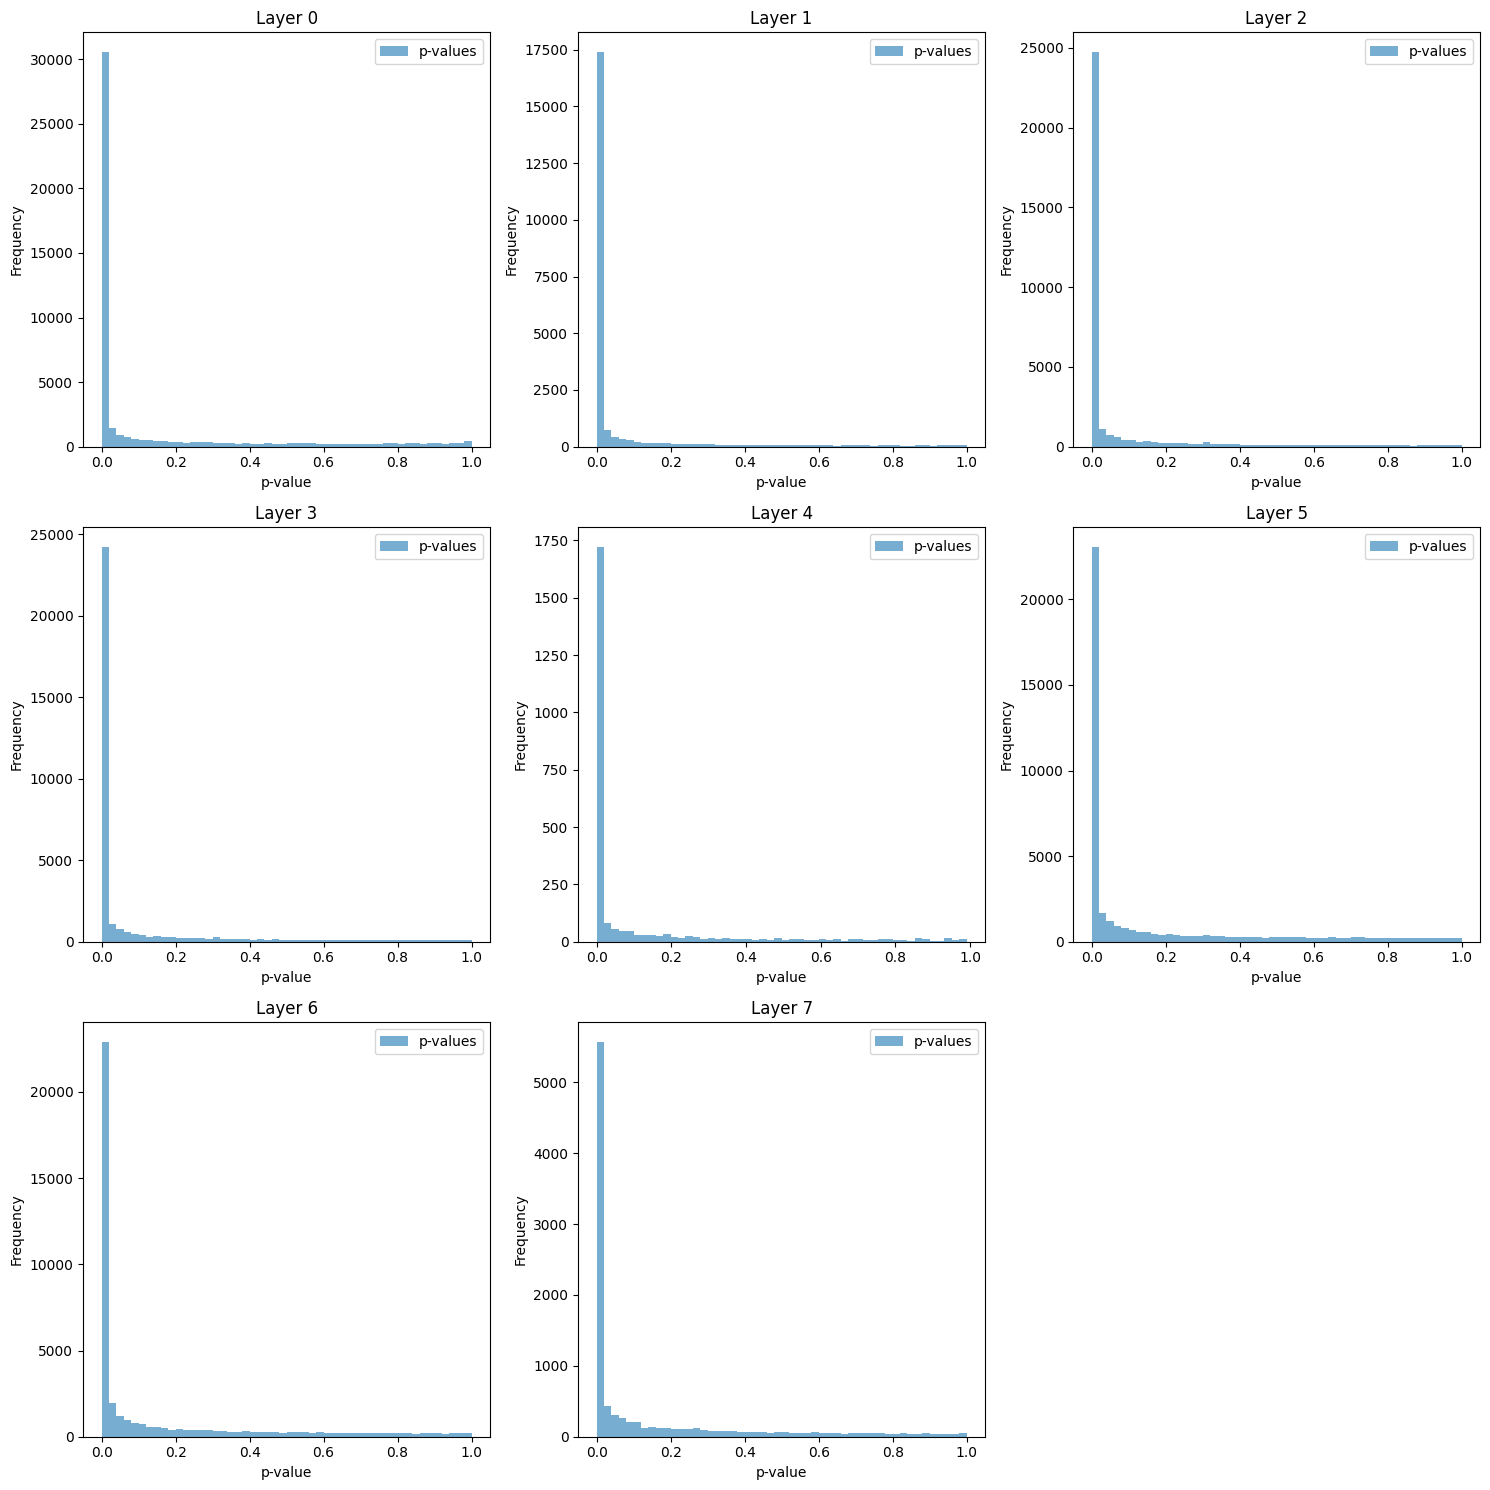

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Load activations
def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_wb/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True)

# Perform two-sample t-tests comparing neuron activations
def perform_two_sample_t_tests(background_activations, original_activations):
    t_test_results = {}
    for layer in background_activations.keys():
        wp_activations = np.vstack(background_activations[layer])
        wo_activations = np.vstack(original_activations[layer])

        # Perform two-sample t-test for each neuron
        ttest_result = ttest_ind(wp_activations, wo_activations, axis=0)

        t_test_results[layer] = {
            'ttest': ttest_result,
            'wp_means': np.mean(wp_activations, axis=0),
            'wo_means': np.mean(wo_activations, axis=0)
        }
    return t_test_results

# Print t-test results with percentages of neurons below or equal to specific p-values
def print_t_test_results(t_test_results):
    for layer, results in t_test_results.items():
        wp_means = results['wp_means']
        wo_means = results['wo_means']
        ttest = results['ttest']

        # Calculate the percentage of neurons below or equal to specific p-value thresholds
        p_values = ttest.pvalue
        below_or_equal_0_05 = np.mean(p_values <= 0.05) * 100
        below_or_equal_0_02 = np.mean(p_values <= 0.02) * 100

        print(f"Layer {layer}:")
        print("  WP Activations:")
        print(f"    Mean: {wp_means.mean():.4f}")
        print("  WO Activations:")
        print(f"    Mean: {wo_means.mean():.4f}")
        print("  T-Test:")
        print(f"    T-statistic: {ttest.statistic.mean():.4f}")
        print(f"    P-value: {ttest.pvalue.mean():.4f}")
        print(f"    Percentage of neurons with p-value <= 0.05: {below_or_equal_0_05:.2f}%")
        print(f"    Percentage of neurons with p-value <= 0.02: {below_or_equal_0_02:.2f}%")
        print("-" * 50)

# Plot the p-values to visualize significance
def plot_p_values(t_test_results):
    num_layers = len(t_test_results)
    num_cols = 3
    num_rows = (num_layers + num_cols - 1) // num_cols

    plt.figure(figsize=(15, 5 * num_rows))
    for idx, (layer, results) in enumerate(t_test_results.items()):
        p_values = results['ttest'].pvalue

        ax = plt.subplot(num_rows, num_cols, idx + 1)
        ax.hist(p_values, bins=50, alpha=0.6, label='p-values')
        ax.set_title(f'Layer {layer}')
        ax.set_xlabel('p-value')
        ax.set_ylabel('Frequency')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]  # Adjusted to match the custom model layers

# Load activations for both foreground and original conditions
foreground_activations = {layer: load_activations('foreground', f'activations.npy_{layer}.npy') for layer in layers_of_interest}
original_activations = {layer: load_activations('original', f'activations.npy_{layer}.npy') for layer in layers_of_interest}

# Perform two-sample t-tests
t_test_results = perform_two_sample_t_tests(foreground_activations, original_activations)

# Print t-test results
print_t_test_results(t_test_results)

# Plot p-values
plot_p_values(t_test_results)


### Original vs. Left Patch

#### Correlation

Computing activations and saving to activations.npy


<ipython-input-16-a9033c653446>:191: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])


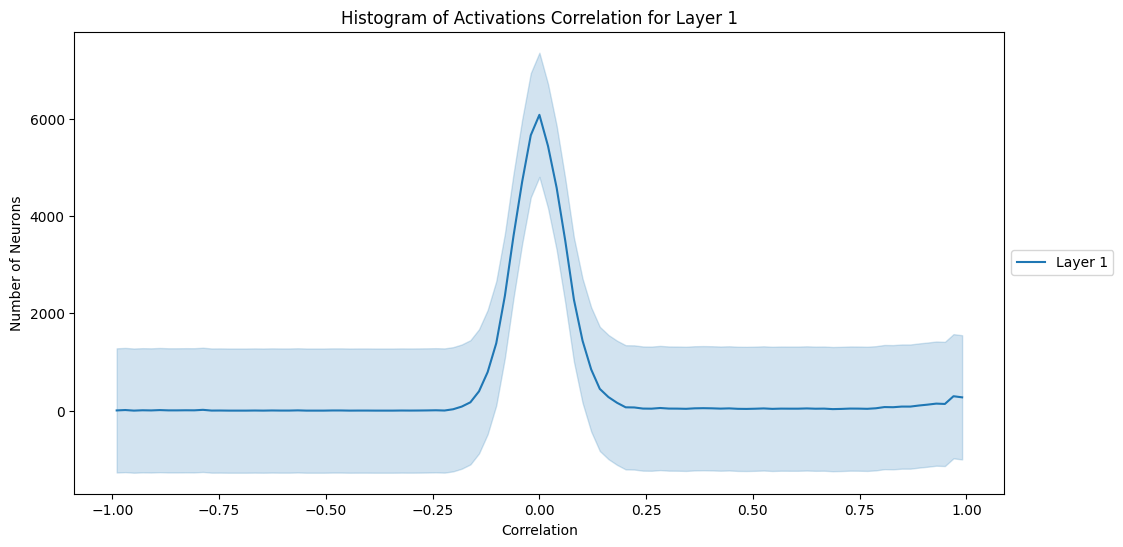

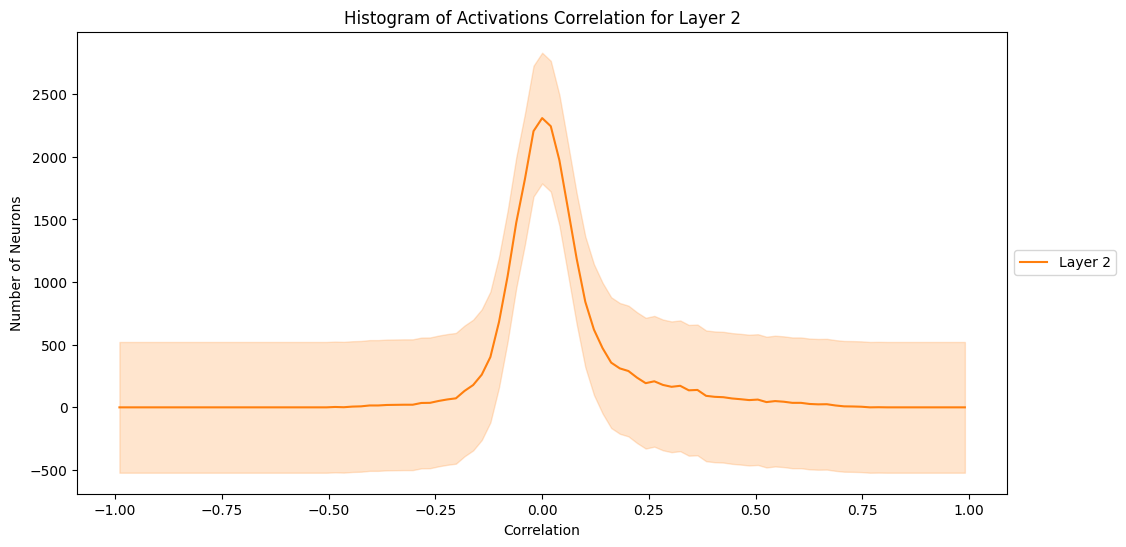

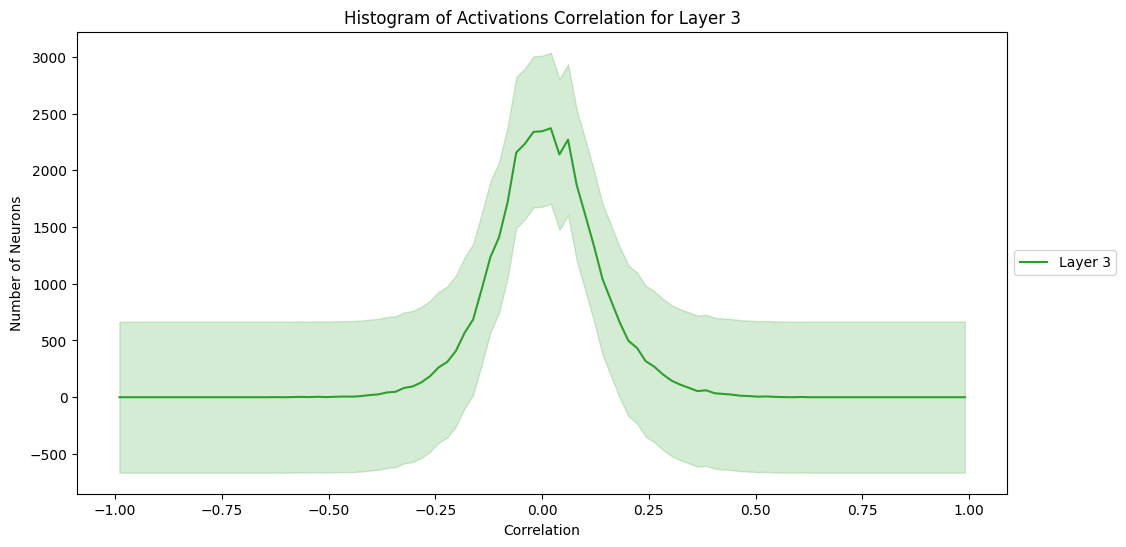

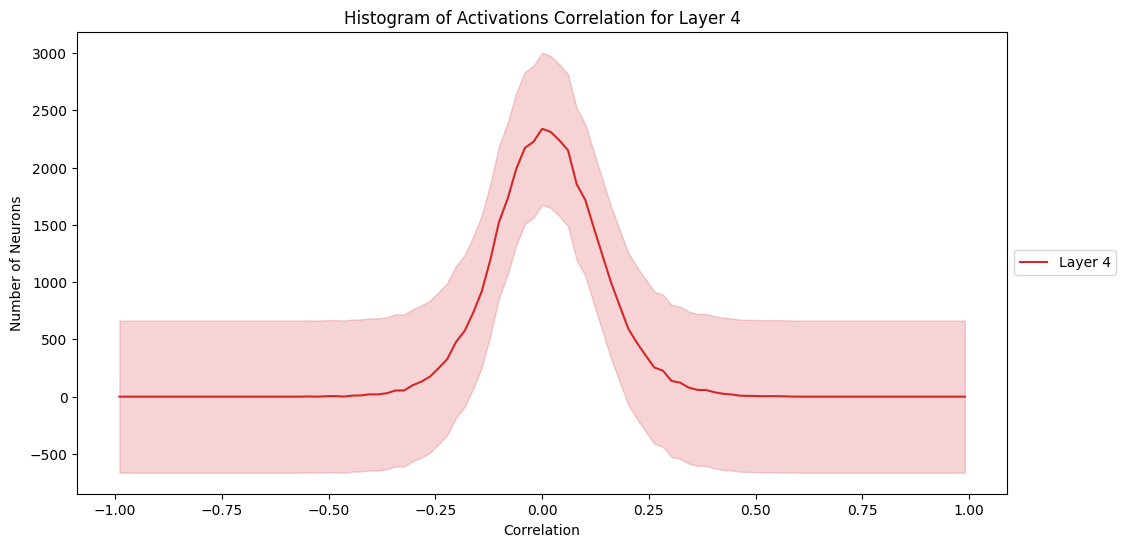

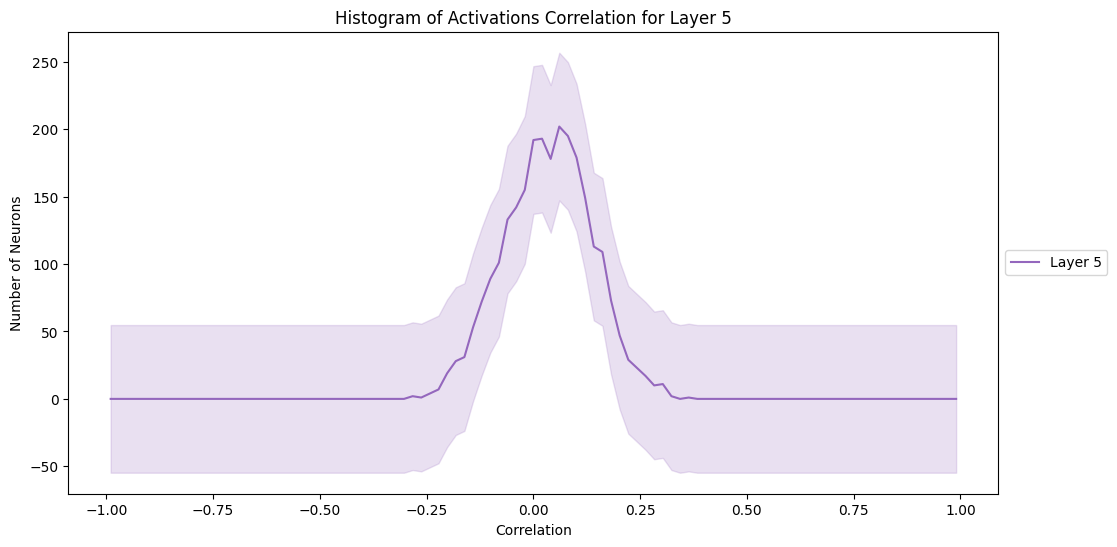

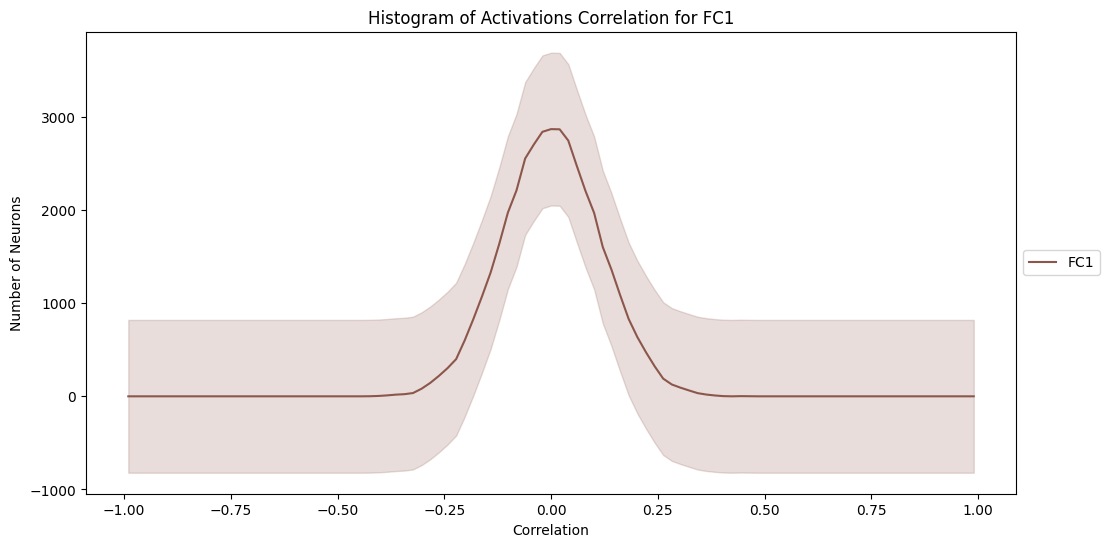

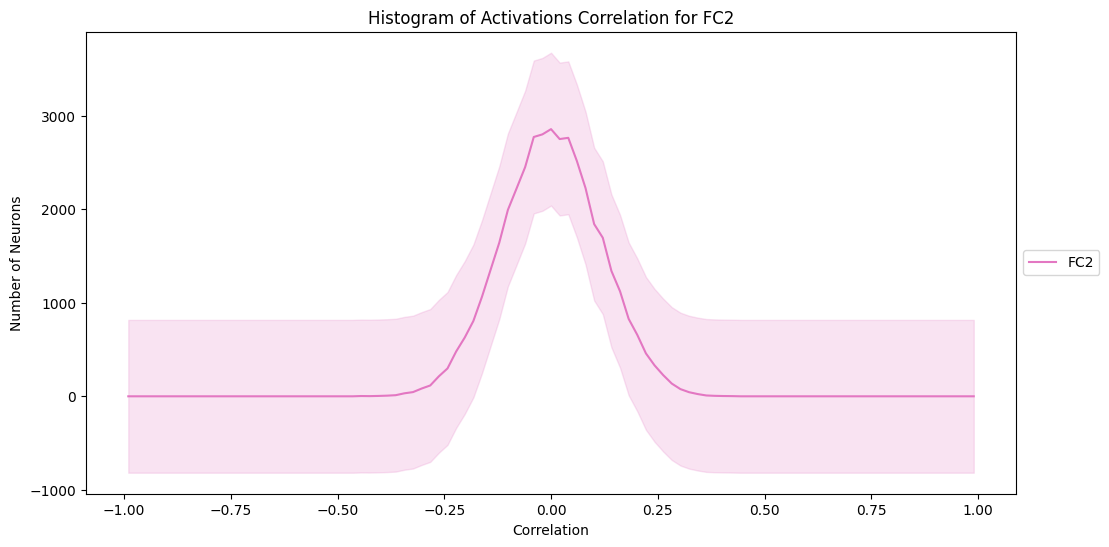

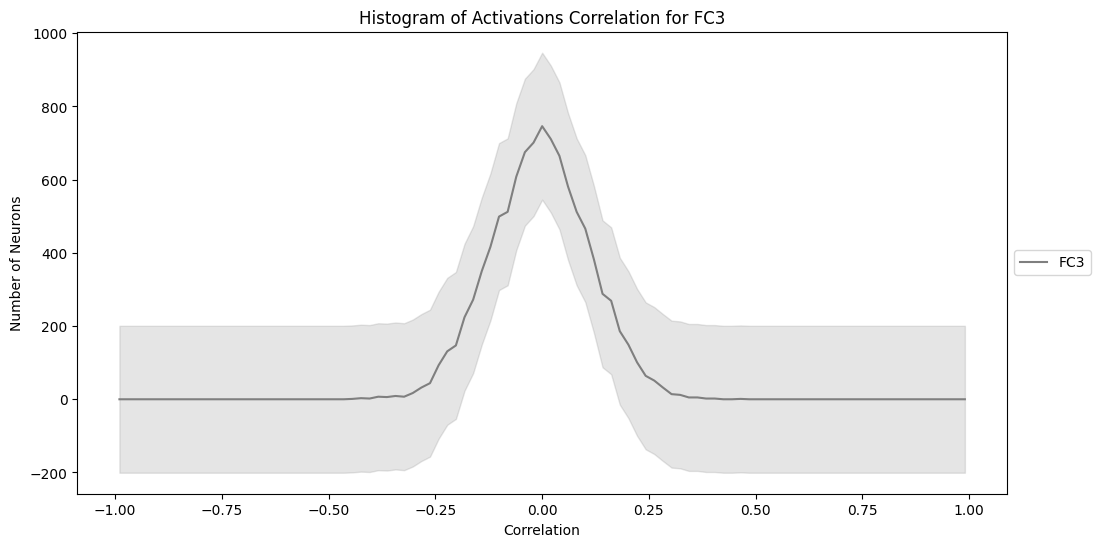

<ipython-input-16-a9033c653446>:229: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])


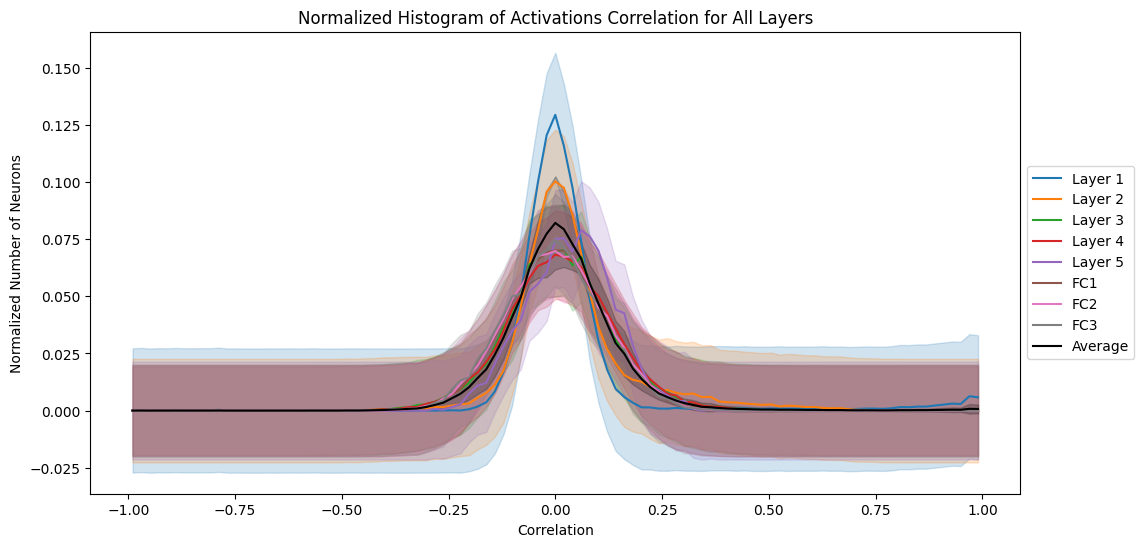

In [ ]:
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import gc
from scipy.stats import pearsonr
from torch.utils.data import DataLoader, Dataset

def load_model(model_path):
    model = AlexNet()
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocessing function
preprocess = transforms.Compose([
    transforms.Resize((64, 64)),  # Match the resize shape in MnistDataset
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Match the normalization values in MnistDataset
])


class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image


def preprocess_and_extract_activations(model, dataloader, layer):
    activations = []
    with torch.no_grad():
        for image_tensor in dataloader:
            image_tensor = image_tensor.to(device)

            # Extract activations according to the AlexNet model's structure
            if layer == 0:  # After Layer 1
                tensor = model.layer1(image_tensor)
            elif layer == 1:  # After Layer 2
                tensor = model.layer2(model.layer1(image_tensor))
            elif layer == 2:  # After Layer 3
                tensor = model.layer3(model.layer2(model.layer1(image_tensor)))
            elif layer == 3:  # After Layer 4
                tensor = model.layer4(model.layer3(model.layer2(model.layer1(image_tensor))))
            elif layer == 4:  # After Layer 5
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
            elif layer == 5:  # After FC1
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc1(tensor)
            elif layer == 6:  # After FC2
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc2(model.fc1(tensor))
            elif layer == 7:  # After FC3 (Output)
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc3(model.fc2(model.fc1(tensor)))

            activation = tensor.cpu().numpy()
            activations.append(activation)

            # Clear memory
            del tensor
            torch.cuda.empty_cache()
            gc.collect()

    return activations



def process_images_in_folder(model, folder_path, layer, batch_size=10):
    all_layer_activations = []

    image_paths = [os.path.join(root, file)
                   for root, dirs, files in os.walk(folder_path)
                   for file in files if file.endswith('.png')]

    dataset = ImageDataset(image_paths=image_paths, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Process in smaller batches to avoid memory issues
    for i, batch in enumerate(dataloader):
        batch_activations = preprocess_and_extract_activations(model, [batch], layer)
        all_layer_activations.extend(batch_activations)
        torch.cuda.empty_cache()
        gc.collect()

    return all_layer_activations

def flatten_and_align_activations(activations_list):
    # Flatten activations and find the maximum length
    flat_activations = [act.flatten() for act in activations_list]
    max_length = max(len(act) for act in flat_activations)

    # Pad or truncate activations to the maximum length
    aligned_activations = []
    for activation in flat_activations:
        if len(activation) < max_length:
            padded_activation = np.pad(activation, (0, max_length - len(activation)), 'constant')
        else:
            padded_activation = activation[:max_length]
        aligned_activations.append(padded_activation)
    return np.vstack(aligned_activations)

def save_activations(all_layer_activations, folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_wb/{folder_name}/{filename}'
    os.makedirs(os.path.dirname(drive_path), exist_ok=True)
    np.save(drive_path, all_layer_activations)

def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_wb/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

def compute_activations_for_layers(model_paths, patch_folder, no_patch_folder, layers, activations_file='activations.npy'):
    if os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_wb/original/{activations_file}') and \
       os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_wb/left_patch/{activations_file}'):
        print(f"Loading activations from {activations_file}")
        wp_activations = load_activations('left_patch', activations_file)
        wo_activations = load_activations('original', activations_file)
        return {layer: {'wp': wp_activations[layer], 'wo': wo_activations[layer]} for layer in layers}

    print(f"Computing activations and saving to {activations_file}")
    all_layer_activations = {layer: {'wp': [], 'wo': []} for layer in layers}

    for model_path in model_paths:
        model = load_model(model_path)
        for layer in layers:
            wp_activations = process_images_in_folder(model, patch_folder, layer)
            wo_activations = process_images_in_folder(model, no_patch_folder, layer)
            all_layer_activations[layer]['wp'].append(flatten_and_align_activations(wp_activations))
            all_layer_activations[layer]['wo'].append(flatten_and_align_activations(wo_activations))
        del model  # Free model resources after use
        torch.cuda.empty_cache()
        gc.collect()

    for layer in layers:
        save_activations(all_layer_activations[layer]['wp'], 'left_patch', f'{activations_file}_{layer}.npy')
        save_activations(all_layer_activations[layer]['wo'], 'original', f'{activations_file}_{layer}.npy')

    return all_layer_activations

def compute_avg_std_activations(all_layer_activations, layers):
    layer_avg_std = {layer: {'wp_avg': None, 'wo_avg': None, 'wp_std': None, 'wo_std': None} for layer in layers}

    for layer in layers:
        wp_all_models_layer_activations = np.stack(all_layer_activations[layer]['wp'], axis=0)
        wo_all_models_layer_activations = np.stack(all_layer_activations[layer]['wo'], axis=0)

        wp_avg = np.mean(wp_all_models_layer_activations, axis=0)
        wo_avg = np.mean(wo_all_models_layer_activations, axis=0)
        wp_std = np.std(wp_all_models_layer_activations, axis=0)
        wo_std = np.std(wo_all_models_layer_activations, axis=0)

        layer_avg_std[layer]['wp_avg'] = wp_avg
        layer_avg_std[layer]['wo_avg'] = wo_avg
        layer_avg_std[layer]['wp_std'] = wp_std
        layer_avg_std[layer]['wo_std'] = wo_std

    return layer_avg_std

def plot_histogram_for_layer(layer_avg_std, layer, layer_name, color):
    wp_avg = layer_avg_std[layer]['wp_avg']
    wo_avg = layer_avg_std[layer]['wo_avg']
    wp_std = layer_avg_std[layer]['wp_std']
    wo_std = layer_avg_std[layer]['wo_std']

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
    combined_activations = np.vstack((wo_avg, wp_avg))

    A = []
    for ii in range(combined_activations.shape[1]):
        A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

    B = np.histogram(A, bins=x)

    bin_means = B[0]
    bin_stds = np.std(bin_means)

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(xaxis, bin_means, '-', color=color, label=layer_name)
    ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=color, alpha=0.2)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Histogram of Activations Correlation for {layer_name}')
    plt.xlabel('Correlation')
    plt.ylabel('Number of Neurons')
    plt.show()

def plot_combined_histogram(layer_avg_std, layer_names, colors):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    all_layer_bin_means = []

    for idx, (layer, layer_name) in enumerate(layer_names.items()):
        wp_avg = layer_avg_std[layer]['wp_avg']
        wo_avg = layer_avg_std[layer]['wo_avg']
        wp_std = layer_avg_std[layer]['wp_std']
        wo_std = layer_avg_std[layer]['wo_std']

        patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
        combined_activations = np.vstack((wo_avg, wp_avg))

        A = []
        for ii in range(combined_activations.shape[1]):
            A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

        B = np.histogram(A, bins=x)

        bin_means = B[0] / np.sum(B[0])  # Normalize the bin counts
        bin_stds = np.std(bin_means)

        all_layer_bin_means.append(bin_means)

        ax.plot(xaxis, bin_means, '-', color=colors[idx], label=layer_name)
        ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=colors[idx], alpha=0.2)

    # Compute average and standard deviation of the normalized histograms across layers
    all_layer_bin_means = np.array(all_layer_bin_means)
    avg_bin_means = np.mean(all_layer_bin_means, axis=0)
    std_bin_means = np.std(all_layer_bin_means, axis=0)

    ax.plot(xaxis, avg_bin_means, '-', color='black', label='Average')
    ax.fill_between(xaxis, avg_bin_means - std_bin_means, avg_bin_means + std_bin_means, color='black', alpha=0.2)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Normalized Histogram of Activations Correlation for All Layers')
    plt.xlabel('Correlation')
    plt.ylabel('Normalized Number of Neurons')
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]  # Adjusted to match the custom model layers
layer_names = {
    0: "Layer 1",
    1: "Layer 2",
    2: "Layer 3",
    3: "Layer 4",
    4: "Layer 5",
    5: "FC1",
    6: "FC2",
    7: "FC3"
}
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']

olp_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_left/test/class_2'
org_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_2'

model_paths = [
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_wb_lp_cl0_cl2_1train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_wb_lp_cl0_cl2_11train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_wb_lp_cl0_cl2_111train.pt"
]

all_layer_activations = compute_activations_for_layers(model_paths, olp_mnist_folder_path, org_mnist_folder_path, layers_of_interest)
layer_avg_std = compute_avg_std_activations(all_layer_activations, layers_of_interest)

# Plot histograms for each layer
for idx, (layer, layer_name) in enumerate(layer_names.items()):
    plot_histogram_for_layer(layer_avg_std, layer, layer_name, colors[idx])

# Plot combined histogram for all layers
plot_combined_histogram(layer_avg_std, layer_names, colors)


#### Two sample t-test

Layer 0:
  WP Activations:
    Mean: 1.9027
  WO Activations:
    Mean: 1.8472
  T-Test:
    T-statistic: nan
    P-value: nan
    Percentage of neurons with p-value <= 0.05: 8.86%
    Percentage of neurons with p-value <= 0.02: 6.98%
--------------------------------------------------
Layer 1:
  WP Activations:
    Mean: 1.6476
  WO Activations:
    Mean: 1.6071
  T-Test:
    T-statistic: 0.3735
    P-value: 0.5744
    Percentage of neurons with p-value <= 0.05: 10.46%
    Percentage of neurons with p-value <= 0.02: 8.19%
--------------------------------------------------
Layer 2:
  WP Activations:
    Mean: 0.5361
  WO Activations:
    Mean: 0.5303
  T-Test:
    T-statistic: nan
    P-value: nan
    Percentage of neurons with p-value <= 0.05: 12.44%
    Percentage of neurons with p-value <= 0.02: 7.86%
--------------------------------------------------
Layer 3:
  WP Activations:
    Mean: 0.2816
  WO Activations:
    Mean: 0.2771
  T-Test:
    T-statistic: nan
    P-value: nan
    Per

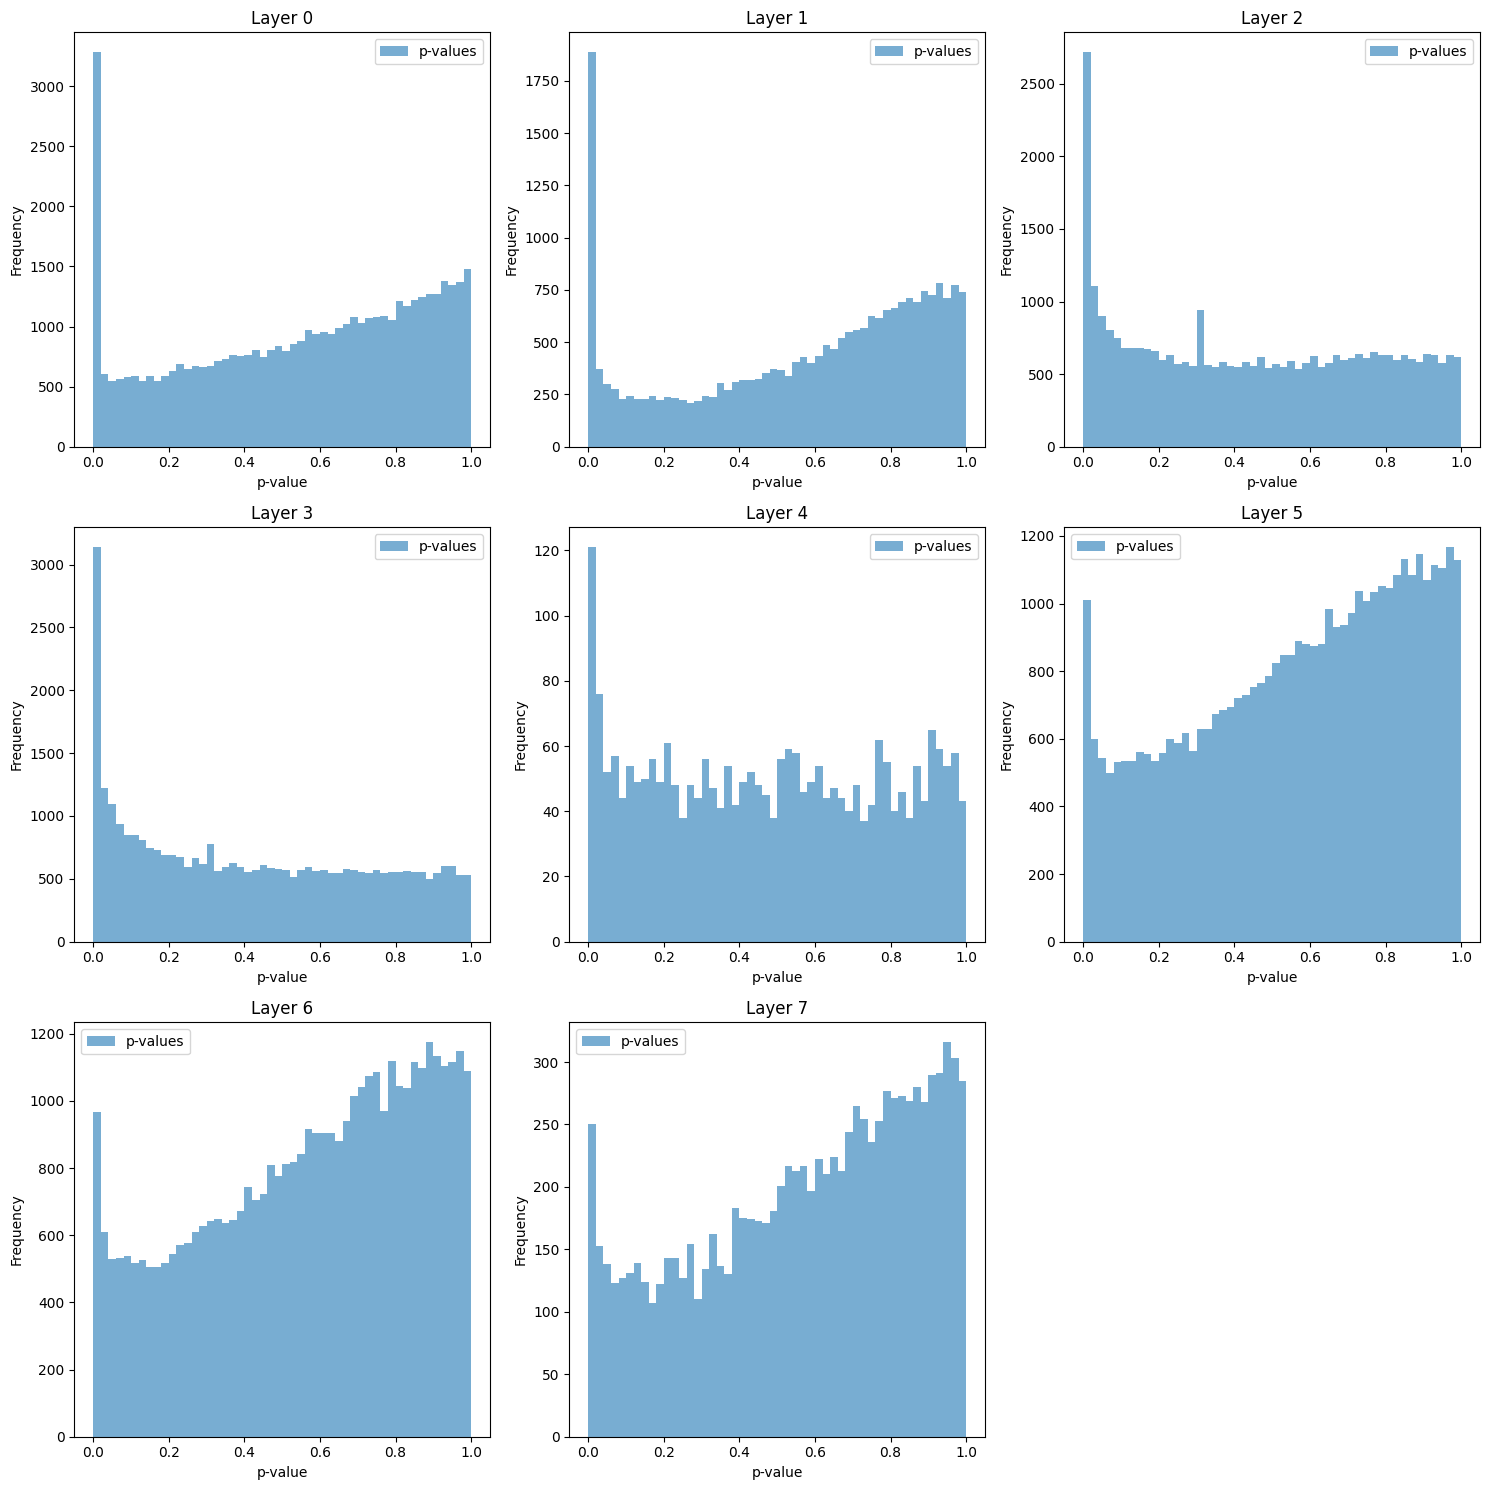

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Load activations
def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_wb/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True)

# Perform two-sample t-tests comparing neuron activations
def perform_two_sample_t_tests(background_activations, original_activations):
    t_test_results = {}
    for layer in background_activations.keys():
        wp_activations = np.vstack(background_activations[layer])
        wo_activations = np.vstack(original_activations[layer])

        # Perform two-sample t-test for each neuron
        ttest_result = ttest_ind(wp_activations, wo_activations, axis=0)

        t_test_results[layer] = {
            'ttest': ttest_result,
            'wp_means': np.mean(wp_activations, axis=0),
            'wo_means': np.mean(wo_activations, axis=0)
        }
    return t_test_results

# Print t-test results with percentages of neurons below or equal to specific p-values
def print_t_test_results(t_test_results):
    for layer, results in t_test_results.items():
        wp_means = results['wp_means']
        wo_means = results['wo_means']
        ttest = results['ttest']

        # Calculate the percentage of neurons below or equal to specific p-value thresholds
        p_values = ttest.pvalue
        below_or_equal_0_05 = np.mean(p_values <= 0.05) * 100
        below_or_equal_0_02 = np.mean(p_values <= 0.02) * 100

        print(f"Layer {layer}:")
        print("  WP Activations:")
        print(f"    Mean: {wp_means.mean():.4f}")
        print("  WO Activations:")
        print(f"    Mean: {wo_means.mean():.4f}")
        print("  T-Test:")
        print(f"    T-statistic: {ttest.statistic.mean():.4f}")
        print(f"    P-value: {ttest.pvalue.mean():.4f}")
        print(f"    Percentage of neurons with p-value <= 0.05: {below_or_equal_0_05:.2f}%")
        print(f"    Percentage of neurons with p-value <= 0.02: {below_or_equal_0_02:.2f}%")
        print("-" * 50)

# Plot the p-values to visualize significance
def plot_p_values(t_test_results):
    num_layers = len(t_test_results)
    num_cols = 3
    num_rows = (num_layers + num_cols - 1) // num_cols

    plt.figure(figsize=(15, 5 * num_rows))
    for idx, (layer, results) in enumerate(t_test_results.items()):
        p_values = results['ttest'].pvalue

        ax = plt.subplot(num_rows, num_cols, idx + 1)
        ax.hist(p_values, bins=50, alpha=0.6, label='p-values')
        ax.set_title(f'Layer {layer}')
        ax.set_xlabel('p-value')
        ax.set_ylabel('Frequency')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]  # Adjusted to match the custom model layers

# Load activations for both left_patch and original conditions
left_patch_activations = {layer: load_activations('left_patch', f'activations.npy_{layer}.npy') for layer in layers_of_interest}
original_activations = {layer: load_activations('original', f'activations.npy_{layer}.npy') for layer in layers_of_interest}

# Perform two-sample t-tests
t_test_results = perform_two_sample_t_tests(left_patch_activations, original_activations)

# Print t-test results
print_t_test_results(t_test_results)

# Plot p-values
plot_p_values(t_test_results)


### Original vs. Center Patch

#### Correlation

Computing activations and saving to activations.npy


<ipython-input-18-f451af16ce4a>:191: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])


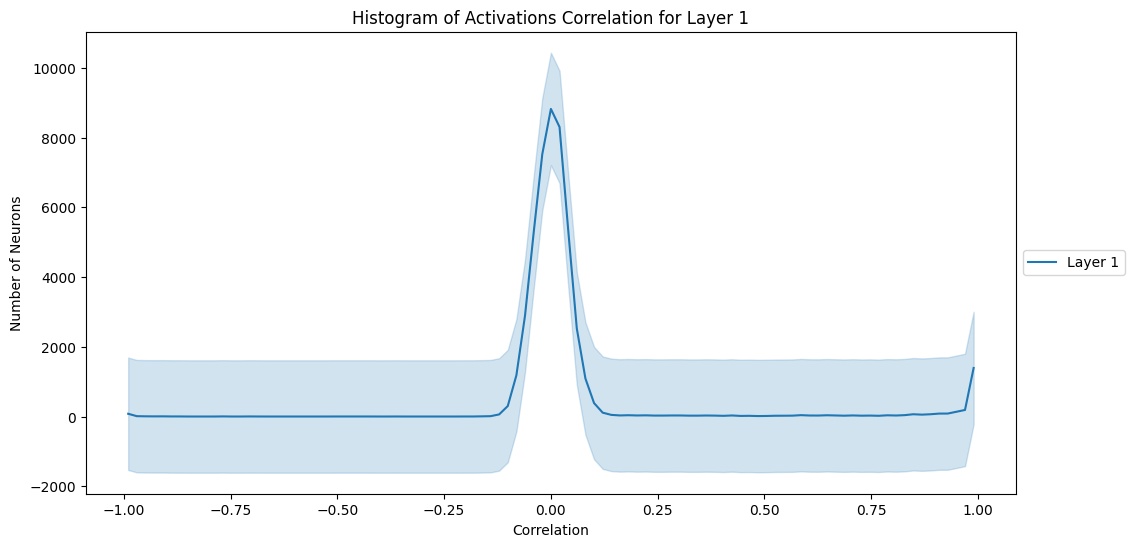

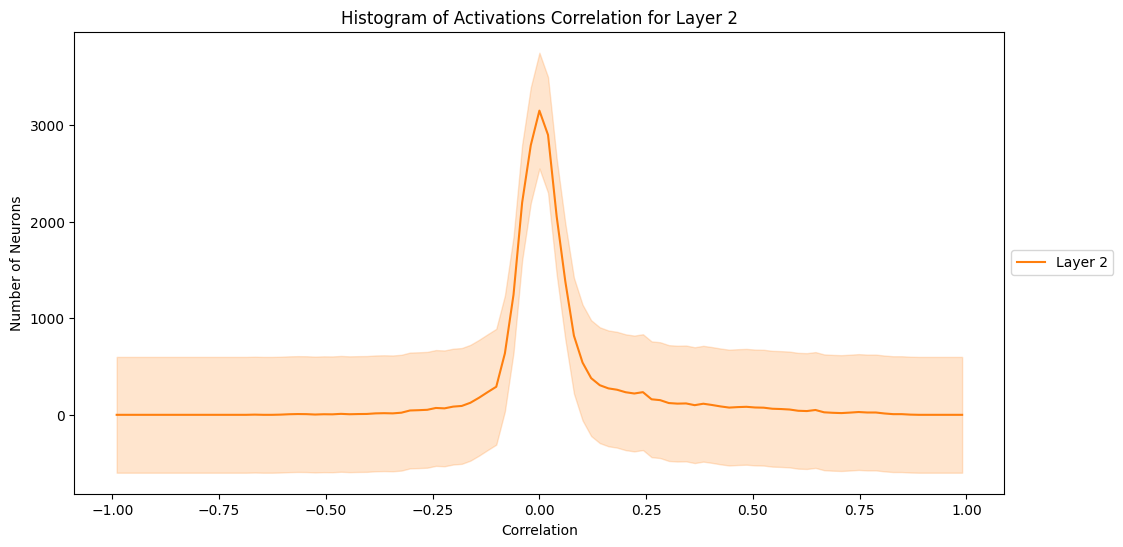

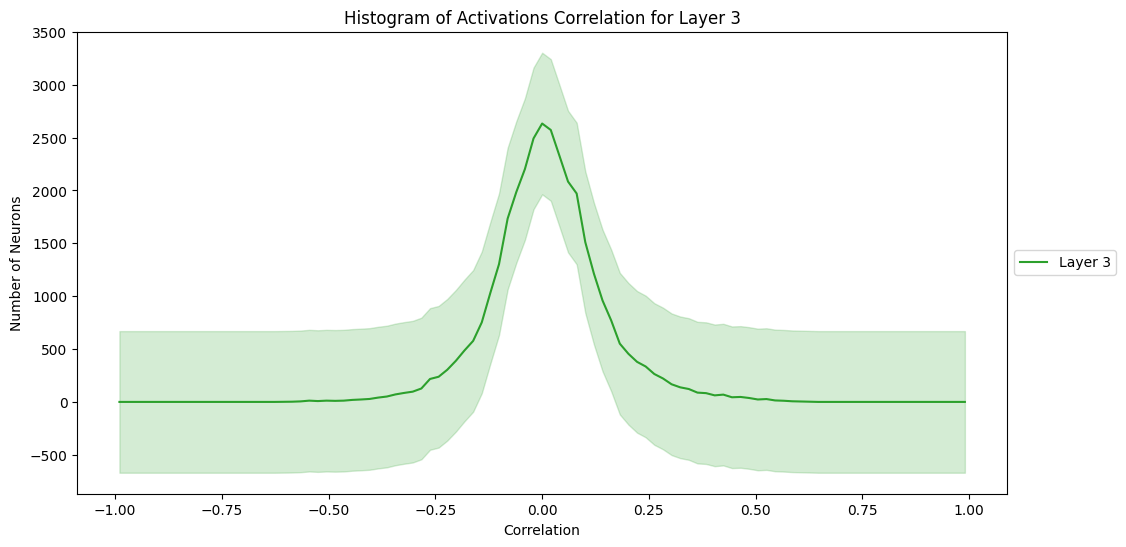

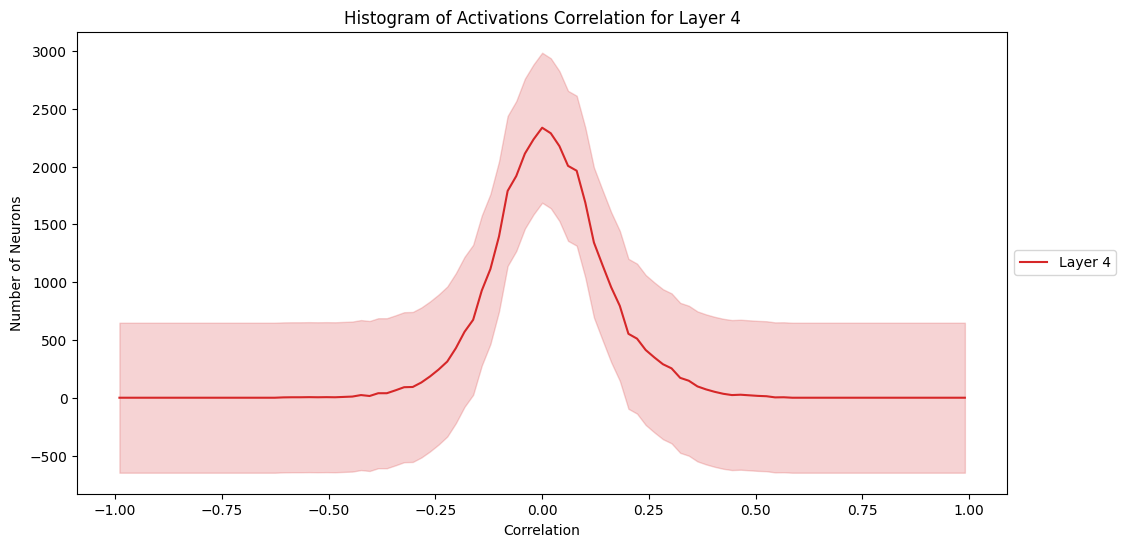

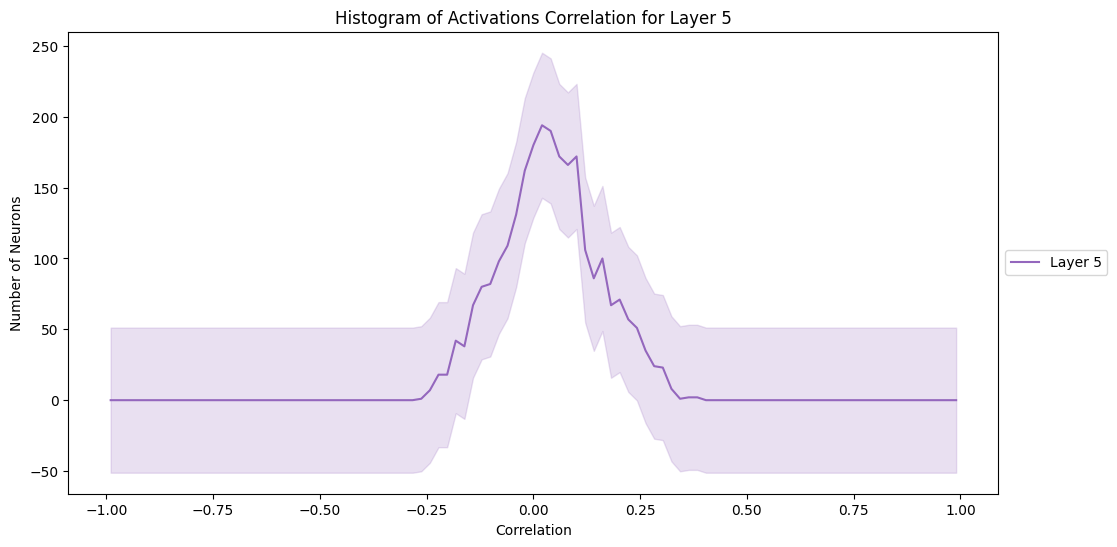

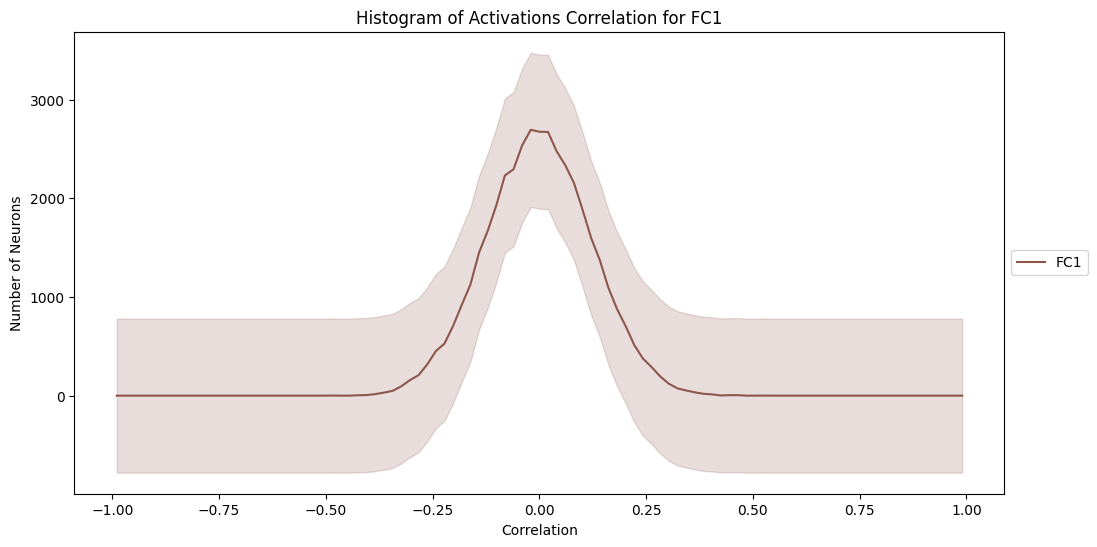

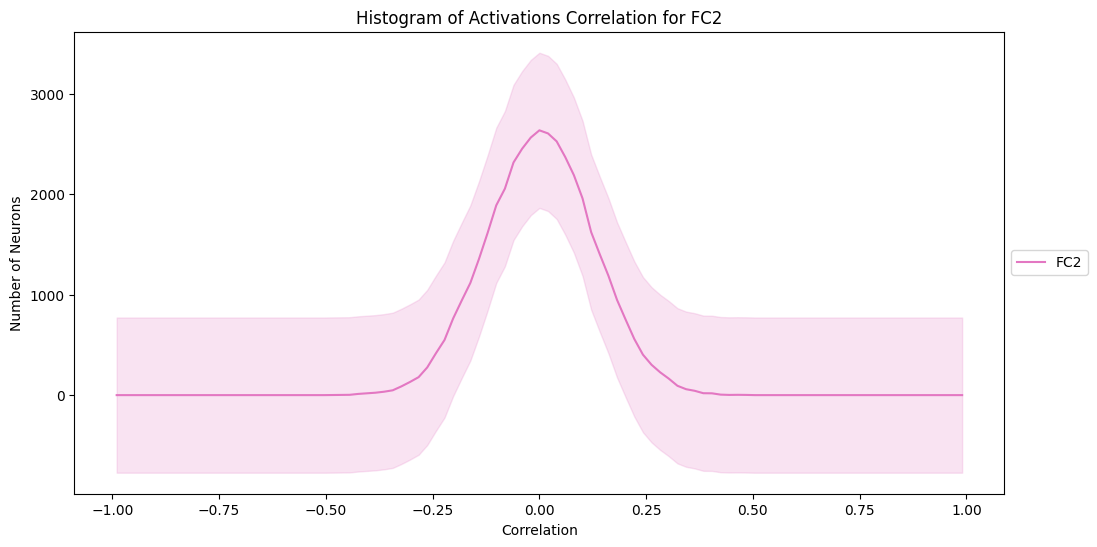

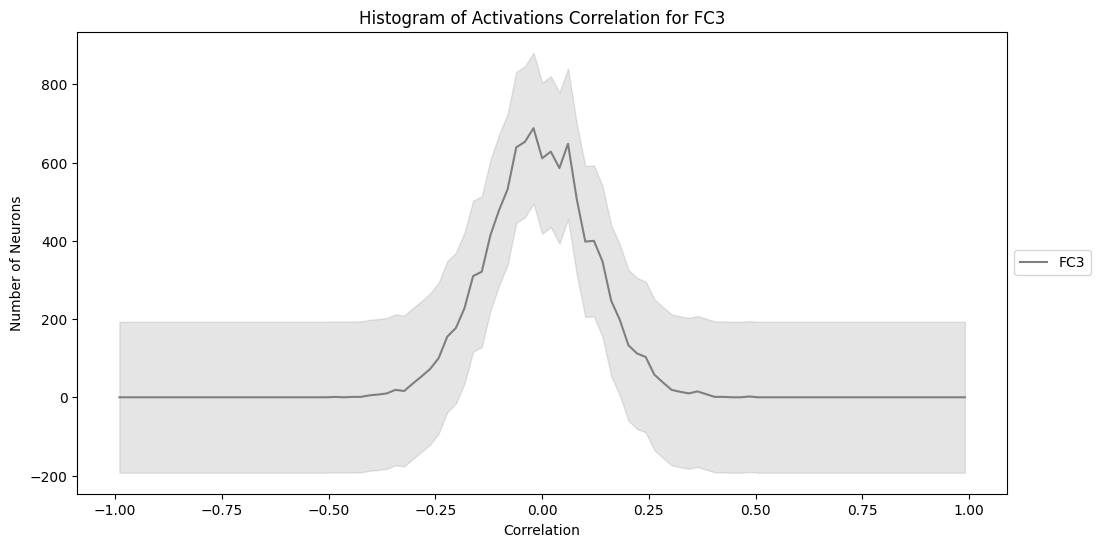

<ipython-input-18-f451af16ce4a>:229: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])


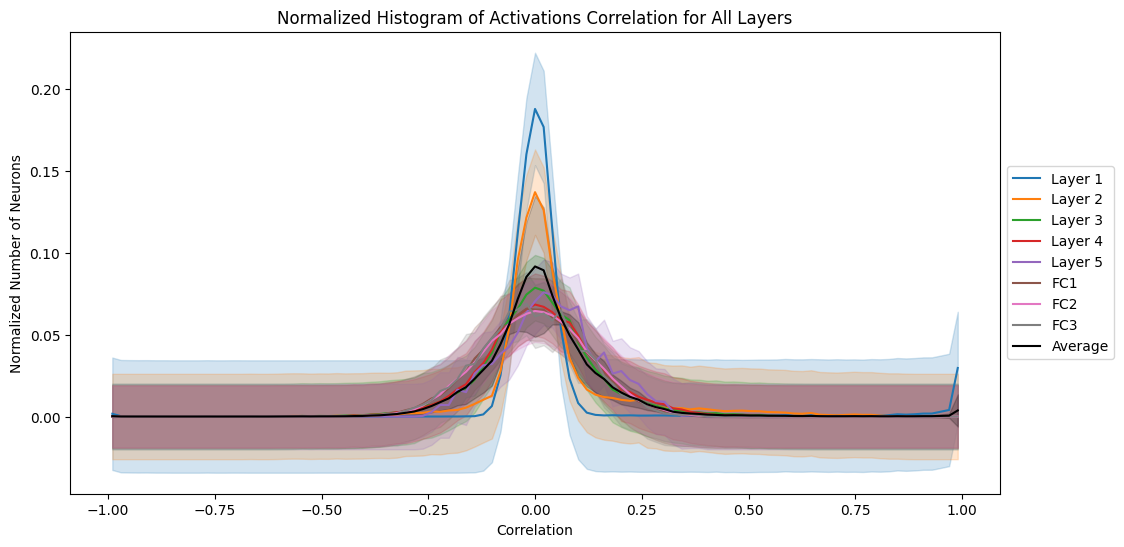

In [ ]:
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import gc
from scipy.stats import pearsonr
from torch.utils.data import DataLoader, Dataset

def load_model(model_path):
    model = AlexNet()
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocessing function
preprocess = transforms.Compose([
    transforms.Resize((64, 64)),  # Match the resize shape in MnistDataset
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Match the normalization values in MnistDataset
])


class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image


def preprocess_and_extract_activations(model, dataloader, layer):
    activations = []
    with torch.no_grad():
        for image_tensor in dataloader:
            image_tensor = image_tensor.to(device)

            # Extract activations according to the AlexNet model's structure
            if layer == 0:  # After Layer 1
                tensor = model.layer1(image_tensor)
            elif layer == 1:  # After Layer 2
                tensor = model.layer2(model.layer1(image_tensor))
            elif layer == 2:  # After Layer 3
                tensor = model.layer3(model.layer2(model.layer1(image_tensor)))
            elif layer == 3:  # After Layer 4
                tensor = model.layer4(model.layer3(model.layer2(model.layer1(image_tensor))))
            elif layer == 4:  # After Layer 5
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
            elif layer == 5:  # After FC1
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc1(tensor)
            elif layer == 6:  # After FC2
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc2(model.fc1(tensor))
            elif layer == 7:  # After FC3 (Output)
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc3(model.fc2(model.fc1(tensor)))

            activation = tensor.cpu().numpy()
            activations.append(activation)

            # Clear memory
            del tensor
            torch.cuda.empty_cache()
            gc.collect()

    return activations



def process_images_in_folder(model, folder_path, layer, batch_size=10):
    all_layer_activations = []

    image_paths = [os.path.join(root, file)
                   for root, dirs, files in os.walk(folder_path)
                   for file in files if file.endswith('.png')]

    dataset = ImageDataset(image_paths=image_paths, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Process in smaller batches to avoid memory issues
    for i, batch in enumerate(dataloader):
        batch_activations = preprocess_and_extract_activations(model, [batch], layer)
        all_layer_activations.extend(batch_activations)
        torch.cuda.empty_cache()
        gc.collect()

    return all_layer_activations

def flatten_and_align_activations(activations_list):
    # Flatten activations and find the maximum length
    flat_activations = [act.flatten() for act in activations_list]
    max_length = max(len(act) for act in flat_activations)

    # Pad or truncate activations to the maximum length
    aligned_activations = []
    for activation in flat_activations:
        if len(activation) < max_length:
            padded_activation = np.pad(activation, (0, max_length - len(activation)), 'constant')
        else:
            padded_activation = activation[:max_length]
        aligned_activations.append(padded_activation)
    return np.vstack(aligned_activations)

def save_activations(all_layer_activations, folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_wb/{folder_name}/{filename}'
    os.makedirs(os.path.dirname(drive_path), exist_ok=True)
    np.save(drive_path, all_layer_activations)

def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_wb/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

def compute_activations_for_layers(model_paths, patch_folder, no_patch_folder, layers, activations_file='activations.npy'):
    if os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_wb/center_patch/{activations_file}') and \
       os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_wb/original/{activations_file}'):
        print(f"Loading activations from {activations_file}")
        wp_activations = load_activations('center_patch', activations_file)
        wo_activations = load_activations('original', activations_file)
        return {layer: {'wp': wp_activations[layer], 'wo': wo_activations[layer]} for layer in layers}

    print(f"Computing activations and saving to {activations_file}")
    all_layer_activations = {layer: {'wp': [], 'wo': []} for layer in layers}

    for model_path in model_paths:
        model = load_model(model_path)
        for layer in layers:
            wp_activations = process_images_in_folder(model, patch_folder, layer)
            wo_activations = process_images_in_folder(model, no_patch_folder, layer)
            all_layer_activations[layer]['wp'].append(flatten_and_align_activations(wp_activations))
            all_layer_activations[layer]['wo'].append(flatten_and_align_activations(wo_activations))
        del model  # Free model resources after use
        torch.cuda.empty_cache()
        gc.collect()

    for layer in layers:
        save_activations(all_layer_activations[layer]['wp'], 'center_patch', f'{activations_file}_{layer}.npy')
        save_activations(all_layer_activations[layer]['wo'], 'original', f'{activations_file}_{layer}.npy')

    return all_layer_activations

def compute_avg_std_activations(all_layer_activations, layers):
    layer_avg_std = {layer: {'wp_avg': None, 'wo_avg': None, 'wp_std': None, 'wo_std': None} for layer in layers}

    for layer in layers:
        wp_all_models_layer_activations = np.stack(all_layer_activations[layer]['wp'], axis=0)
        wo_all_models_layer_activations = np.stack(all_layer_activations[layer]['wo'], axis=0)

        wp_avg = np.mean(wp_all_models_layer_activations, axis=0)
        wo_avg = np.mean(wo_all_models_layer_activations, axis=0)
        wp_std = np.std(wp_all_models_layer_activations, axis=0)
        wo_std = np.std(wo_all_models_layer_activations, axis=0)

        layer_avg_std[layer]['wp_avg'] = wp_avg
        layer_avg_std[layer]['wo_avg'] = wo_avg
        layer_avg_std[layer]['wp_std'] = wp_std
        layer_avg_std[layer]['wo_std'] = wo_std

    return layer_avg_std

def plot_histogram_for_layer(layer_avg_std, layer, layer_name, color):
    wp_avg = layer_avg_std[layer]['wp_avg']
    wo_avg = layer_avg_std[layer]['wo_avg']
    wp_std = layer_avg_std[layer]['wp_std']
    wo_std = layer_avg_std[layer]['wo_std']

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
    combined_activations = np.vstack((wo_avg, wp_avg))

    A = []
    for ii in range(combined_activations.shape[1]):
        A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

    B = np.histogram(A, bins=x)

    bin_means = B[0]
    bin_stds = np.std(bin_means)

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(xaxis, bin_means, '-', color=color, label=layer_name)
    ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=color, alpha=0.2)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Histogram of Activations Correlation for {layer_name}')
    plt.xlabel('Correlation')
    plt.ylabel('Number of Neurons')
    plt.show()

def plot_combined_histogram(layer_avg_std, layer_names, colors):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    all_layer_bin_means = []

    for idx, (layer, layer_name) in enumerate(layer_names.items()):
        wp_avg = layer_avg_std[layer]['wp_avg']
        wo_avg = layer_avg_std[layer]['wo_avg']
        wp_std = layer_avg_std[layer]['wp_std']
        wo_std = layer_avg_std[layer]['wo_std']

        patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
        combined_activations = np.vstack((wo_avg, wp_avg))

        A = []
        for ii in range(combined_activations.shape[1]):
            A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

        B = np.histogram(A, bins=x)

        bin_means = B[0] / np.sum(B[0])  # Normalize the bin counts
        bin_stds = np.std(bin_means)

        all_layer_bin_means.append(bin_means)

        ax.plot(xaxis, bin_means, '-', color=colors[idx], label=layer_name)
        ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=colors[idx], alpha=0.2)

    # Compute average and standard deviation of the normalized histograms across layers
    all_layer_bin_means = np.array(all_layer_bin_means)
    avg_bin_means = np.mean(all_layer_bin_means, axis=0)
    std_bin_means = np.std(all_layer_bin_means, axis=0)

    ax.plot(xaxis, avg_bin_means, '-', color='black', label='Average')
    ax.fill_between(xaxis, avg_bin_means - std_bin_means, avg_bin_means + std_bin_means, color='black', alpha=0.2)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Normalized Histogram of Activations Correlation for All Layers')
    plt.xlabel('Correlation')
    plt.ylabel('Normalized Number of Neurons')
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]  # Adjusted to match the custom model layers
layer_names = {
    0: "Layer 1",
    1: "Layer 2",
    2: "Layer 3",
    3: "Layer 4",
    4: "Layer 5",
    5: "FC1",
    6: "FC2",
    7: "FC3"
}
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']

org_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_left/test/class_0'
cp_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_0'

model_paths = [
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_wb_cp_cl0_cl2_1train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_wb_cp_cl0_cl2_11train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_wb_cp_cl0_cl2_111train.pt"
]

all_layer_activations = compute_activations_for_layers(model_paths, org_mnist_folder_path, cp_mnist_folder_path, layers_of_interest)
layer_avg_std = compute_avg_std_activations(all_layer_activations, layers_of_interest)

# Plot histograms for each layer
for idx, (layer, layer_name) in enumerate(layer_names.items()):
    plot_histogram_for_layer(layer_avg_std, layer, layer_name, colors[idx])

# Plot combined histogram for all layers
plot_combined_histogram(layer_avg_std, layer_names, colors)


#### Two sample t-test

Layer 0:
  WP Activations:
    Mean: 1.9829
  WO Activations:
    Mean: 2.0425
  T-Test:
    T-statistic: nan
    P-value: nan
    Percentage of neurons with p-value <= 0.05: 6.17%
    Percentage of neurons with p-value <= 0.02: 5.94%
--------------------------------------------------
Layer 1:
  WP Activations:
    Mean: 1.6404
  WO Activations:
    Mean: 1.6820
  T-Test:
    T-statistic: -0.3733
    P-value: 0.6417
    Percentage of neurons with p-value <= 0.05: 10.06%
    Percentage of neurons with p-value <= 0.02: 8.22%
--------------------------------------------------
Layer 2:
  WP Activations:
    Mean: 0.5263
  WO Activations:
    Mean: 0.5340
  T-Test:
    T-statistic: nan
    P-value: nan
    Percentage of neurons with p-value <= 0.05: 11.38%
    Percentage of neurons with p-value <= 0.02: 7.41%
--------------------------------------------------
Layer 3:
  WP Activations:
    Mean: 0.2815
  WO Activations:
    Mean: 0.2878
  T-Test:
    T-statistic: nan
    P-value: nan
    Pe

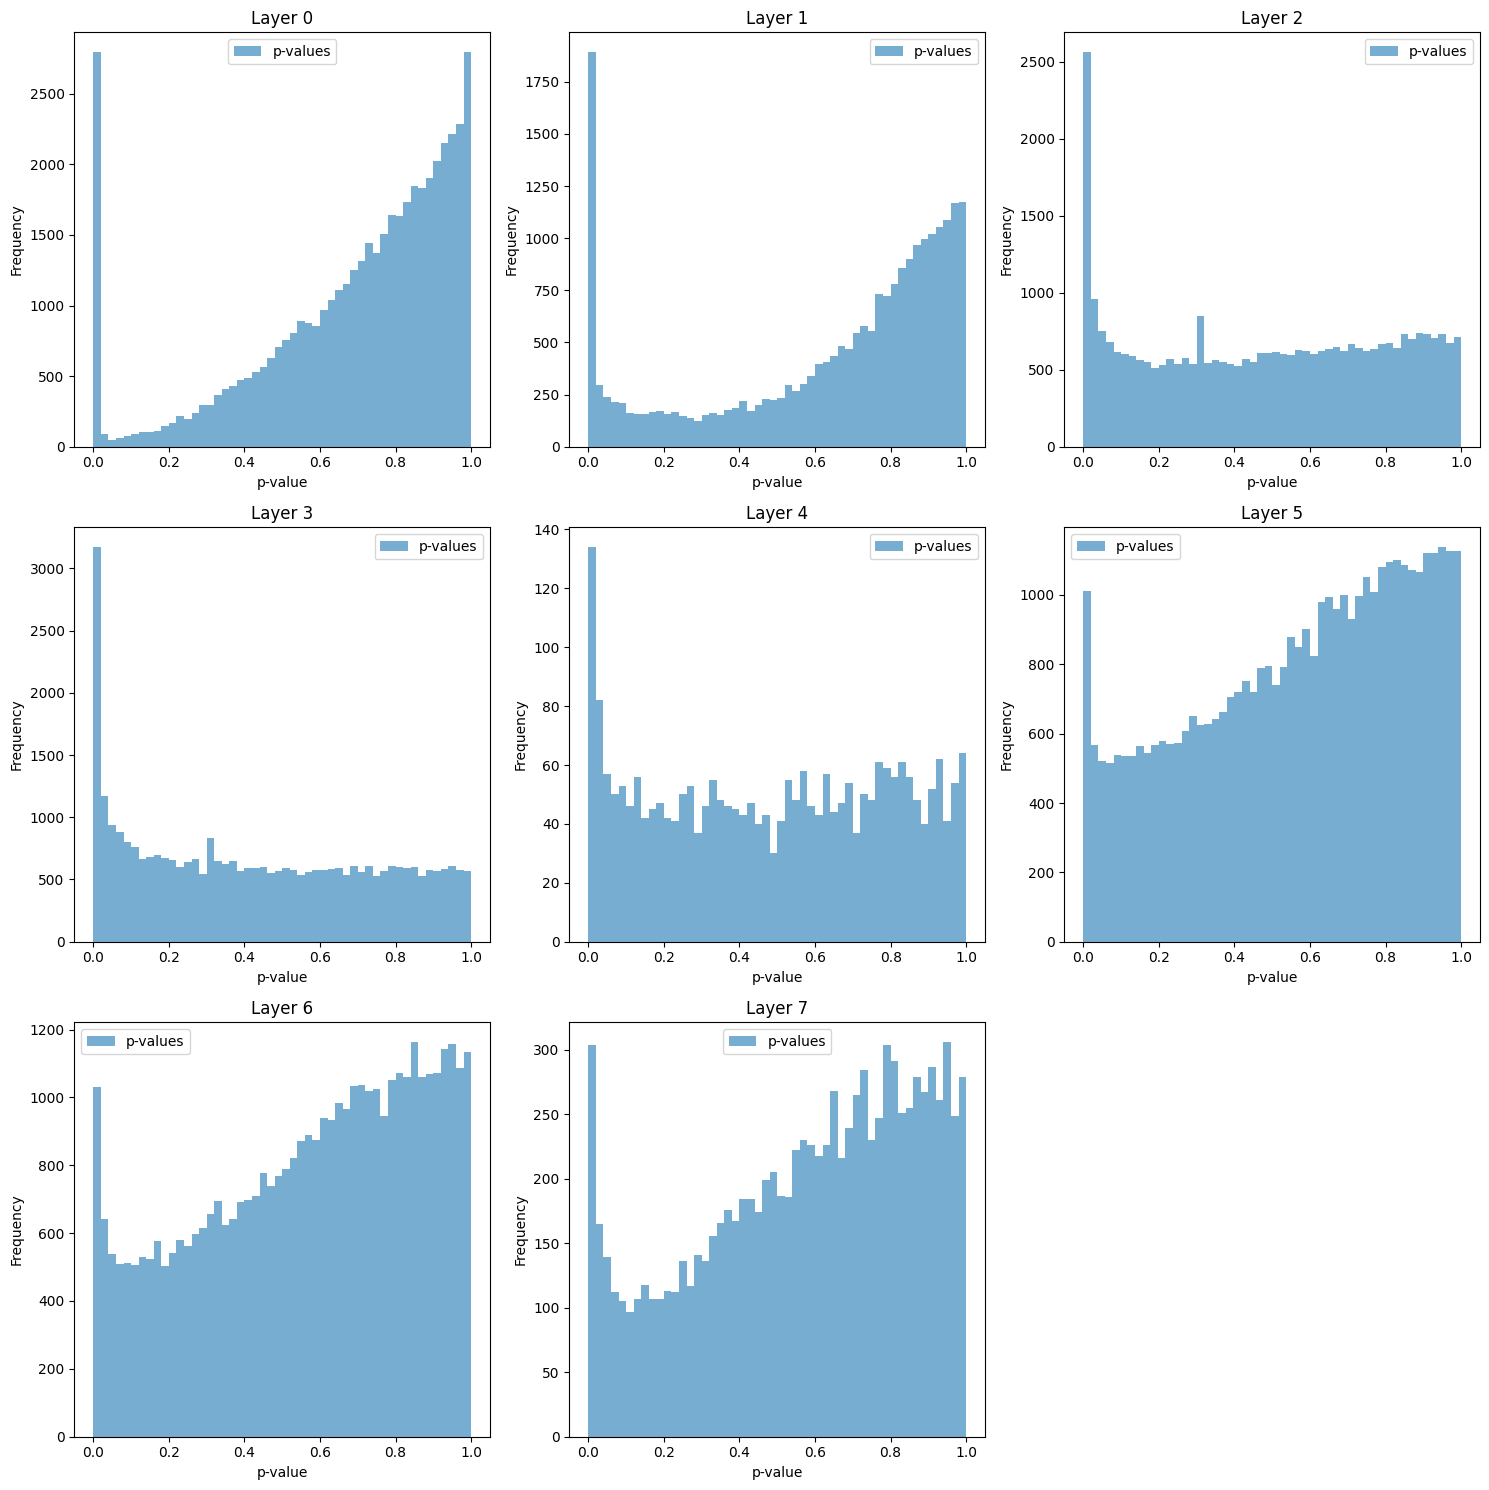

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Load activations
def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_wb/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True)

# Perform two-sample t-tests comparing neuron activations
def perform_two_sample_t_tests(background_activations, original_activations):
    t_test_results = {}
    for layer in background_activations.keys():
        wp_activations = np.vstack(background_activations[layer])
        wo_activations = np.vstack(original_activations[layer])

        # Perform two-sample t-test for each neuron
        ttest_result = ttest_ind(wp_activations, wo_activations, axis=0)

        t_test_results[layer] = {
            'ttest': ttest_result,
            'wp_means': np.mean(wp_activations, axis=0),
            'wo_means': np.mean(wo_activations, axis=0)
        }
    return t_test_results

# Print t-test results with percentages of neurons below or equal to specific p-values
def print_t_test_results(t_test_results):
    for layer, results in t_test_results.items():
        wp_means = results['wp_means']
        wo_means = results['wo_means']
        ttest = results['ttest']

        # Calculate the percentage of neurons below or equal to specific p-value thresholds
        p_values = ttest.pvalue
        below_or_equal_0_05 = np.mean(p_values <= 0.05) * 100
        below_or_equal_0_02 = np.mean(p_values <= 0.02) * 100

        print(f"Layer {layer}:")
        print("  WP Activations:")
        print(f"    Mean: {wp_means.mean():.4f}")
        print("  WO Activations:")
        print(f"    Mean: {wo_means.mean():.4f}")
        print("  T-Test:")
        print(f"    T-statistic: {ttest.statistic.mean():.4f}")
        print(f"    P-value: {ttest.pvalue.mean():.4f}")
        print(f"    Percentage of neurons with p-value <= 0.05: {below_or_equal_0_05:.2f}%")
        print(f"    Percentage of neurons with p-value <= 0.02: {below_or_equal_0_02:.2f}%")
        print("-" * 50)

# Plot the p-values to visualize significance
def plot_p_values(t_test_results):
    num_layers = len(t_test_results)
    num_cols = 3
    num_rows = (num_layers + num_cols - 1) // num_cols

    plt.figure(figsize=(15, 5 * num_rows))
    for idx, (layer, results) in enumerate(t_test_results.items()):
        p_values = results['ttest'].pvalue

        ax = plt.subplot(num_rows, num_cols, idx + 1)
        ax.hist(p_values, bins=50, alpha=0.6, label='p-values')
        ax.set_title(f'Layer {layer}')
        ax.set_xlabel('p-value')
        ax.set_ylabel('Frequency')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]  # Adjusted to match the custom model layers

# Load activations for both original and center_patch conditions
original_activations = {layer: load_activations('original', f'activations.npy_{layer}.npy') for layer in layers_of_interest}
center_patch_activations = {layer: load_activations('center_patch', f'activations.npy_{layer}.npy') for layer in layers_of_interest}

# Perform two-sample t-tests
t_test_results = perform_two_sample_t_tests(original_activations, center_patch_activations)

# Print t-test results
print_t_test_results(t_test_results)

# Plot p-values
plot_p_values(t_test_results)


### Center (spur ft.) vs. Left Patch

#### Correlation

Computing activations and saving to activations.npy


<ipython-input-20-2b5c5a70d946>:191: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])


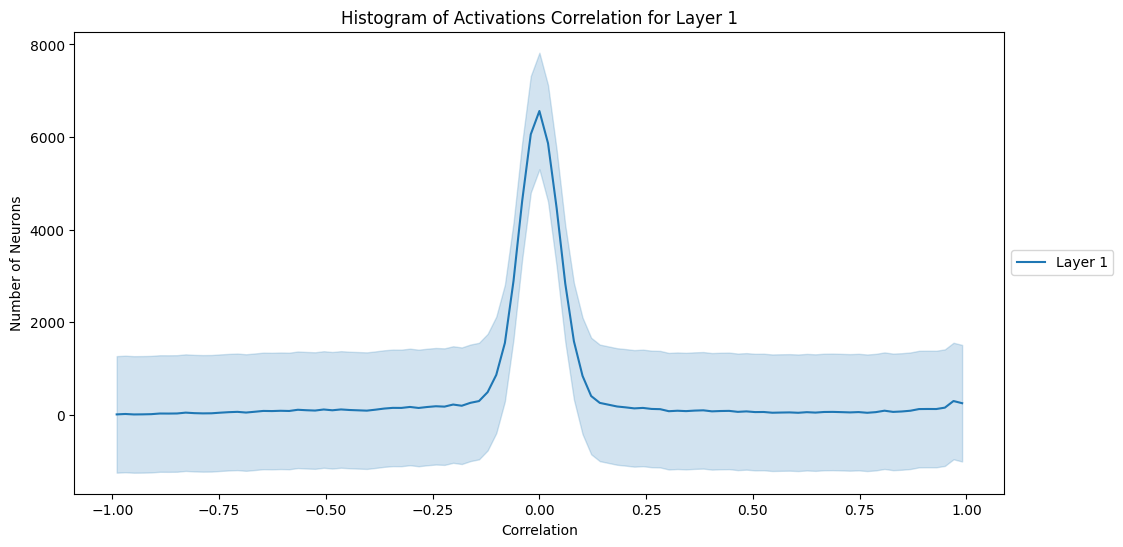

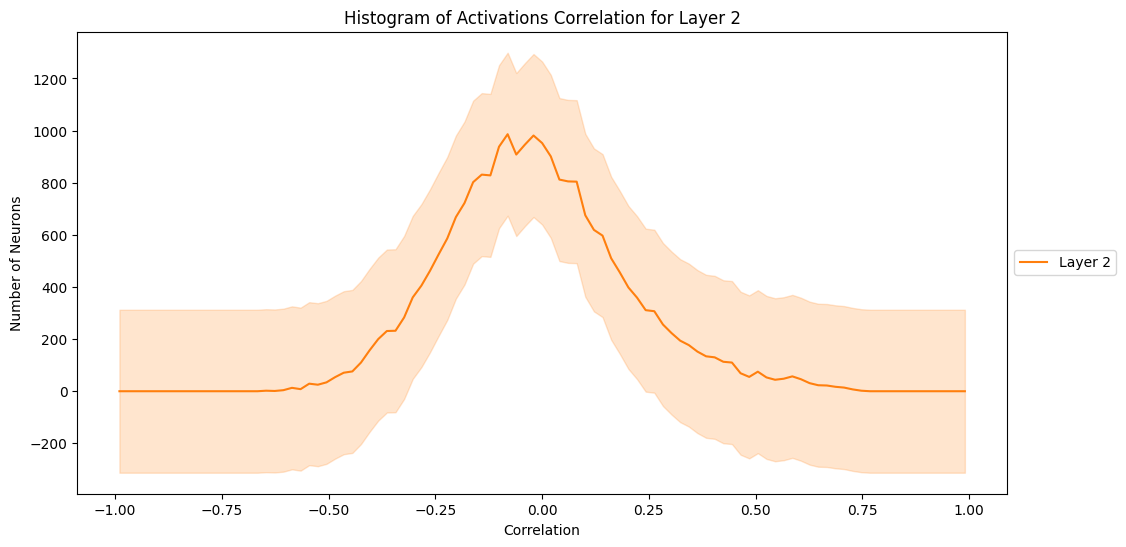

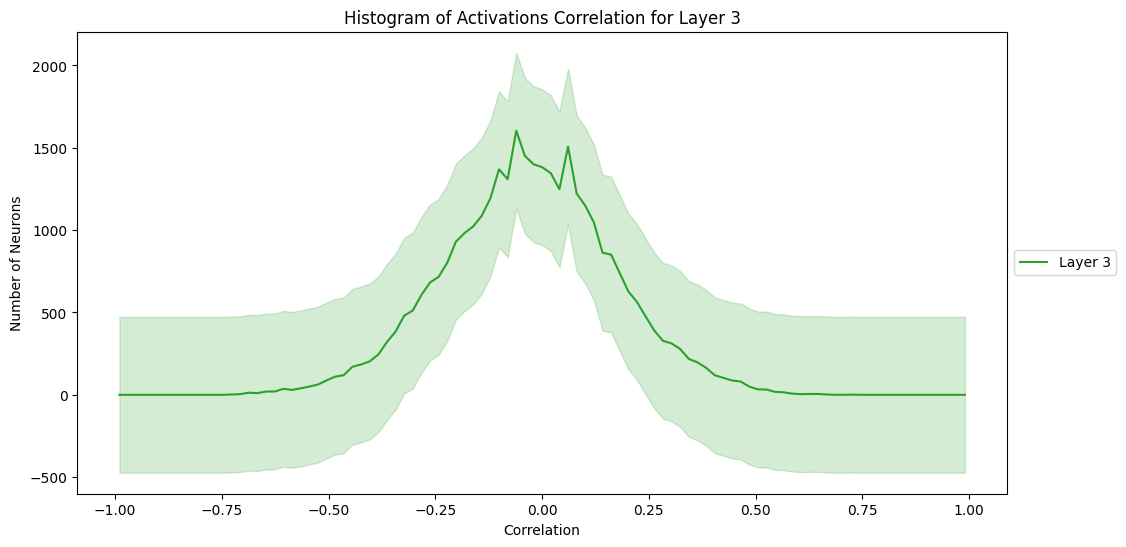

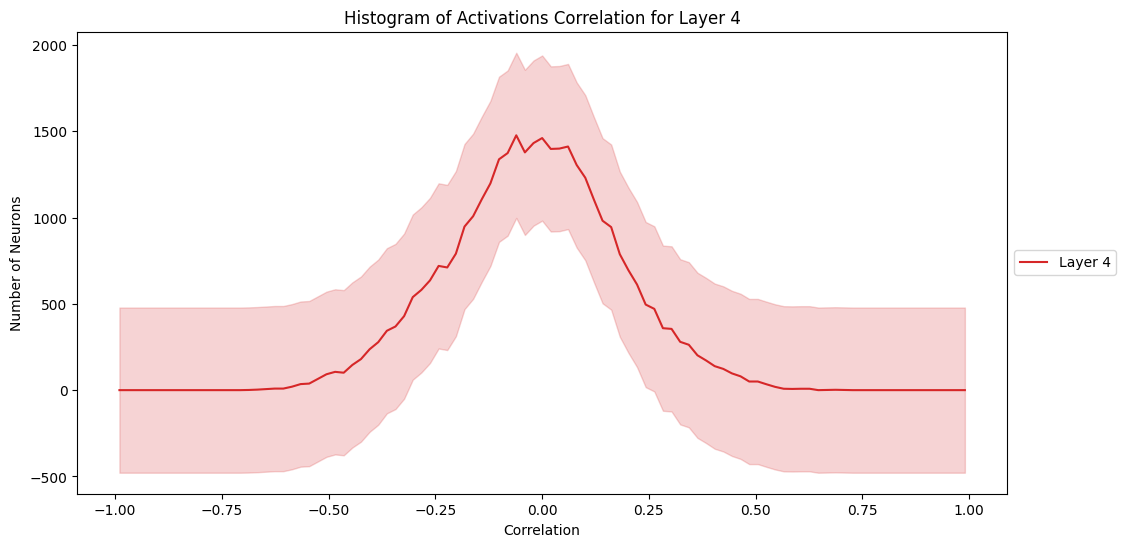

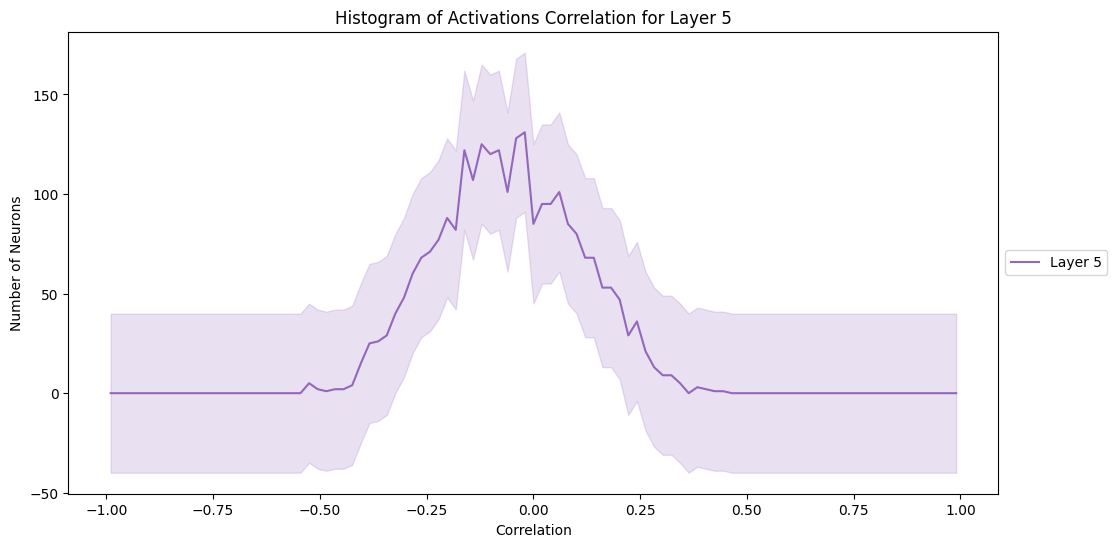

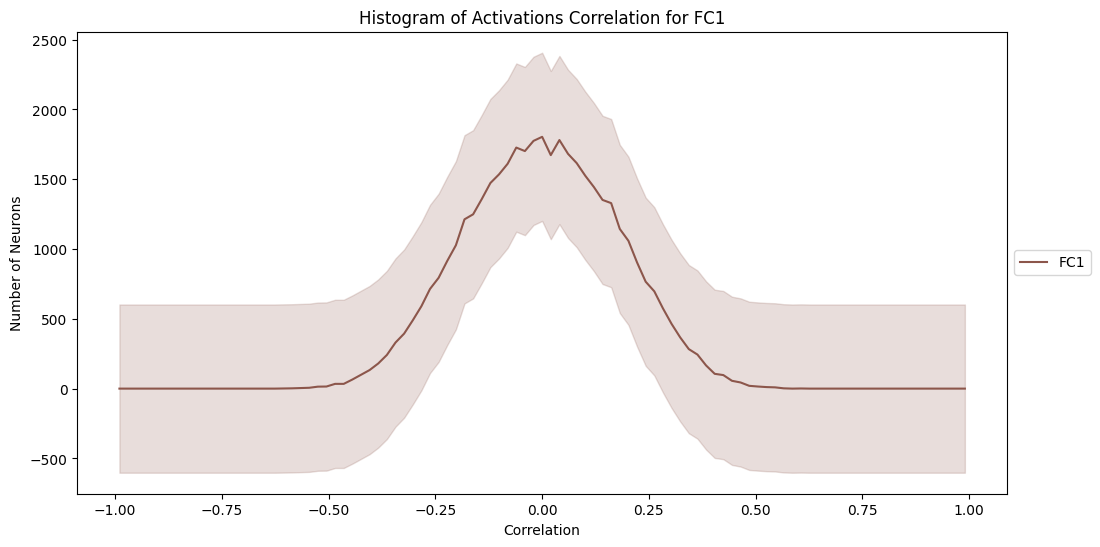

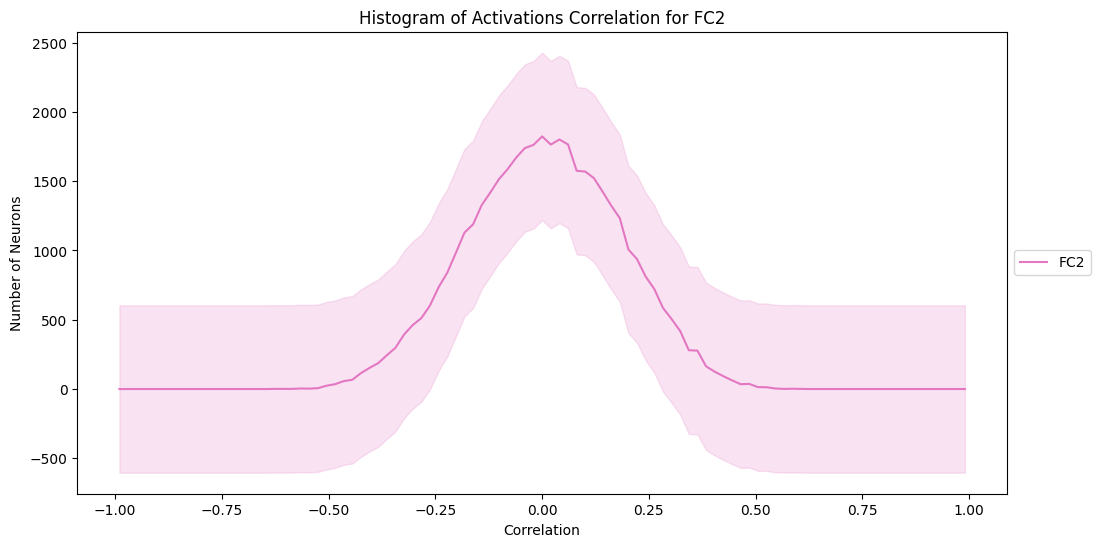

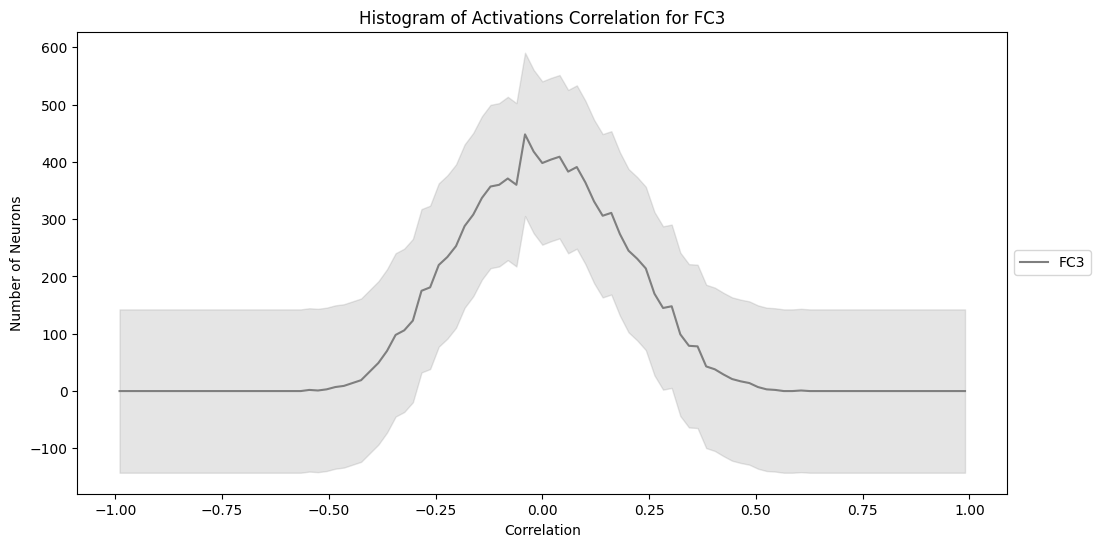

<ipython-input-20-2b5c5a70d946>:229: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])


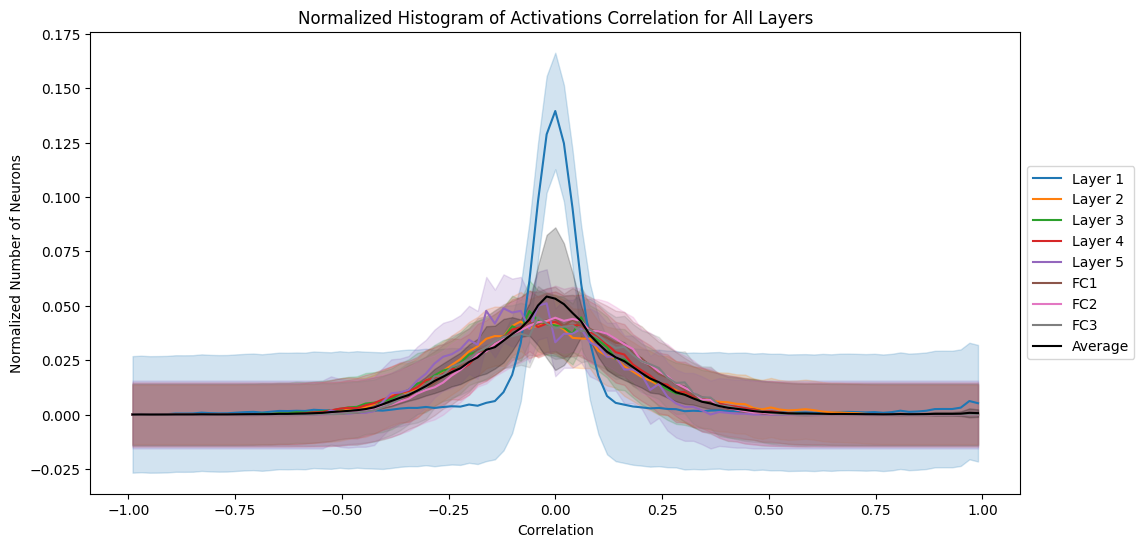

In [ ]:
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import gc
from scipy.stats import pearsonr
from torch.utils.data import DataLoader, Dataset

def load_model(model_path):
    model = AlexNet()
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocessing function
preprocess = transforms.Compose([
    transforms.Resize((64, 64)),  # Match the resize shape in MnistDataset
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Match the normalization values in MnistDataset
])


class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image


def preprocess_and_extract_activations(model, dataloader, layer):
    activations = []
    with torch.no_grad():
        for image_tensor in dataloader:
            image_tensor = image_tensor.to(device)

            # Extract activations according to the AlexNet model's structure
            if layer == 0:  # After Layer 1
                tensor = model.layer1(image_tensor)
            elif layer == 1:  # After Layer 2
                tensor = model.layer2(model.layer1(image_tensor))
            elif layer == 2:  # After Layer 3
                tensor = model.layer3(model.layer2(model.layer1(image_tensor)))
            elif layer == 3:  # After Layer 4
                tensor = model.layer4(model.layer3(model.layer2(model.layer1(image_tensor))))
            elif layer == 4:  # After Layer 5
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
            elif layer == 5:  # After FC1
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc1(tensor)
            elif layer == 6:  # After FC2
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc2(model.fc1(tensor))
            elif layer == 7:  # After FC3 (Output)
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc3(model.fc2(model.fc1(tensor)))

            activation = tensor.cpu().numpy()
            activations.append(activation)

            # Clear memory
            del tensor
            torch.cuda.empty_cache()
            gc.collect()

    return activations



def process_images_in_folder(model, folder_path, layer, batch_size=10):
    all_layer_activations = []

    image_paths = [os.path.join(root, file)
                   for root, dirs, files in os.walk(folder_path)
                   for file in files if file.endswith('.png')]

    dataset = ImageDataset(image_paths=image_paths, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Process in smaller batches to avoid memory issues
    for i, batch in enumerate(dataloader):
        batch_activations = preprocess_and_extract_activations(model, [batch], layer)
        all_layer_activations.extend(batch_activations)
        torch.cuda.empty_cache()
        gc.collect()

    return all_layer_activations

def flatten_and_align_activations(activations_list):
    # Flatten activations and find the maximum length
    flat_activations = [act.flatten() for act in activations_list]
    max_length = max(len(act) for act in flat_activations)

    # Pad or truncate activations to the maximum length
    aligned_activations = []
    for activation in flat_activations:
        if len(activation) < max_length:
            padded_activation = np.pad(activation, (0, max_length - len(activation)), 'constant')
        else:
            padded_activation = activation[:max_length]
        aligned_activations.append(padded_activation)
    return np.vstack(aligned_activations)

def save_activations(all_layer_activations, folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_wb/{folder_name}/{filename}'
    os.makedirs(os.path.dirname(drive_path), exist_ok=True)
    np.save(drive_path, all_layer_activations)

def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_wb/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

def compute_activations_for_layers(model_paths, patch_folder, no_patch_folder, layers, activations_file='activations.npy'):
    if os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_wb/center_patch/{activations_file}') and \
       os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_wb/left_patch/{activations_file}'):
        print(f"Loading activations from {activations_file}")
        wp_activations = load_activations('center_patch', activations_file)
        wo_activations = load_activations('left_patch', activations_file)
        return {layer: {'wp': wp_activations[layer], 'wo': wo_activations[layer]} for layer in layers}

    print(f"Computing activations and saving to {activations_file}")
    all_layer_activations = {layer: {'wp': [], 'wo': []} for layer in layers}

    for model_path in model_paths:
        model = load_model(model_path)
        for layer in layers:
            wp_activations = process_images_in_folder(model, patch_folder, layer)
            wo_activations = process_images_in_folder(model, no_patch_folder, layer)
            all_layer_activations[layer]['wp'].append(flatten_and_align_activations(wp_activations))
            all_layer_activations[layer]['wo'].append(flatten_and_align_activations(wo_activations))
        del model  # Free model resources after use
        torch.cuda.empty_cache()
        gc.collect()

    for layer in layers:
        save_activations(all_layer_activations[layer]['wp'], 'center_patch', f'{activations_file}_{layer}.npy')
        save_activations(all_layer_activations[layer]['wo'], 'left_patch', f'{activations_file}_{layer}.npy')

    return all_layer_activations

def compute_avg_std_activations(all_layer_activations, layers):
    layer_avg_std = {layer: {'wp_avg': None, 'wo_avg': None, 'wp_std': None, 'wo_std': None} for layer in layers}

    for layer in layers:
        wp_all_models_layer_activations = np.stack(all_layer_activations[layer]['wp'], axis=0)
        wo_all_models_layer_activations = np.stack(all_layer_activations[layer]['wo'], axis=0)

        wp_avg = np.mean(wp_all_models_layer_activations, axis=0)
        wo_avg = np.mean(wo_all_models_layer_activations, axis=0)
        wp_std = np.std(wp_all_models_layer_activations, axis=0)
        wo_std = np.std(wo_all_models_layer_activations, axis=0)

        layer_avg_std[layer]['wp_avg'] = wp_avg
        layer_avg_std[layer]['wo_avg'] = wo_avg
        layer_avg_std[layer]['wp_std'] = wp_std
        layer_avg_std[layer]['wo_std'] = wo_std

    return layer_avg_std

def plot_histogram_for_layer(layer_avg_std, layer, layer_name, color):
    wp_avg = layer_avg_std[layer]['wp_avg']
    wo_avg = layer_avg_std[layer]['wo_avg']
    wp_std = layer_avg_std[layer]['wp_std']
    wo_std = layer_avg_std[layer]['wo_std']

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
    combined_activations = np.vstack((wo_avg, wp_avg))

    A = []
    for ii in range(combined_activations.shape[1]):
        A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

    B = np.histogram(A, bins=x)

    bin_means = B[0]
    bin_stds = np.std(bin_means)

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(xaxis, bin_means, '-', color=color, label=layer_name)
    ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=color, alpha=0.2)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Histogram of Activations Correlation for {layer_name}')
    plt.xlabel('Correlation')
    plt.ylabel('Number of Neurons')
    plt.show()

def plot_combined_histogram(layer_avg_std, layer_names, colors):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    all_layer_bin_means = []

    for idx, (layer, layer_name) in enumerate(layer_names.items()):
        wp_avg = layer_avg_std[layer]['wp_avg']
        wo_avg = layer_avg_std[layer]['wo_avg']
        wp_std = layer_avg_std[layer]['wp_std']
        wo_std = layer_avg_std[layer]['wo_std']

        patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
        combined_activations = np.vstack((wo_avg, wp_avg))

        A = []
        for ii in range(combined_activations.shape[1]):
            A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

        B = np.histogram(A, bins=x)

        bin_means = B[0] / np.sum(B[0])  # Normalize the bin counts
        bin_stds = np.std(bin_means)

        all_layer_bin_means.append(bin_means)

        ax.plot(xaxis, bin_means, '-', color=colors[idx], label=layer_name)
        ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=colors[idx], alpha=0.2)

    # Compute average and standard deviation of the normalized histograms across layers
    all_layer_bin_means = np.array(all_layer_bin_means)
    avg_bin_means = np.mean(all_layer_bin_means, axis=0)
    std_bin_means = np.std(all_layer_bin_means, axis=0)

    ax.plot(xaxis, avg_bin_means, '-', color='black', label='Average')
    ax.fill_between(xaxis, avg_bin_means - std_bin_means, avg_bin_means + std_bin_means, color='black', alpha=0.2)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Normalized Histogram of Activations Correlation for All Layers')
    plt.xlabel('Correlation')
    plt.ylabel('Normalized Number of Neurons')
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]  # Adjusted to match the custom model layers
layer_names = {
    0: "Layer 1",
    1: "Layer 2",
    2: "Layer 3",
    3: "Layer 4",
    4: "Layer 5",
    5: "FC1",
    6: "FC2",
    7: "FC3"
}
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']

olp_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_left/test/class_2'
cp_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_center/test/class_2'

model_paths = [
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_wb_cp_lp_cl0_cl2_1train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_wb_cp_lp_cl0_cl2_11train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_wb_cp_lp_cl0_cl2_111train.pt"
]

all_layer_activations = compute_activations_for_layers(model_paths, olp_mnist_folder_path, cp_mnist_folder_path, layers_of_interest)
layer_avg_std = compute_avg_std_activations(all_layer_activations, layers_of_interest)

# Plot histograms for each layer
for idx, (layer, layer_name) in enumerate(layer_names.items()):
    plot_histogram_for_layer(layer_avg_std, layer, layer_name, colors[idx])

# Plot combined histogram for all layers
plot_combined_histogram(layer_avg_std, layer_names, colors)


#### Two sample t-test

Layer 0:
  WP Activations:
    Mean: 1.9318
  WO Activations:
    Mean: 1.9454
  T-Test:
    T-statistic: nan
    P-value: nan
    Percentage of neurons with p-value <= 0.05: 16.15%
    Percentage of neurons with p-value <= 0.02: 14.52%
--------------------------------------------------
Layer 1:
  WP Activations:
    Mean: 1.6933
  WO Activations:
    Mean: 1.6732
  T-Test:
    T-statistic: nan
    P-value: nan
    Percentage of neurons with p-value <= 0.05: 27.54%
    Percentage of neurons with p-value <= 0.02: 21.10%
--------------------------------------------------
Layer 2:
  WP Activations:
    Mean: 0.5352
  WO Activations:
    Mean: 0.5146
  T-Test:
    T-statistic: nan
    P-value: nan
    Percentage of neurons with p-value <= 0.05: 31.12%
    Percentage of neurons with p-value <= 0.02: 23.64%
--------------------------------------------------
Layer 3:
  WP Activations:
    Mean: 0.2613
  WO Activations:
    Mean: 0.2520
  T-Test:
    T-statistic: nan
    P-value: nan
    Perce

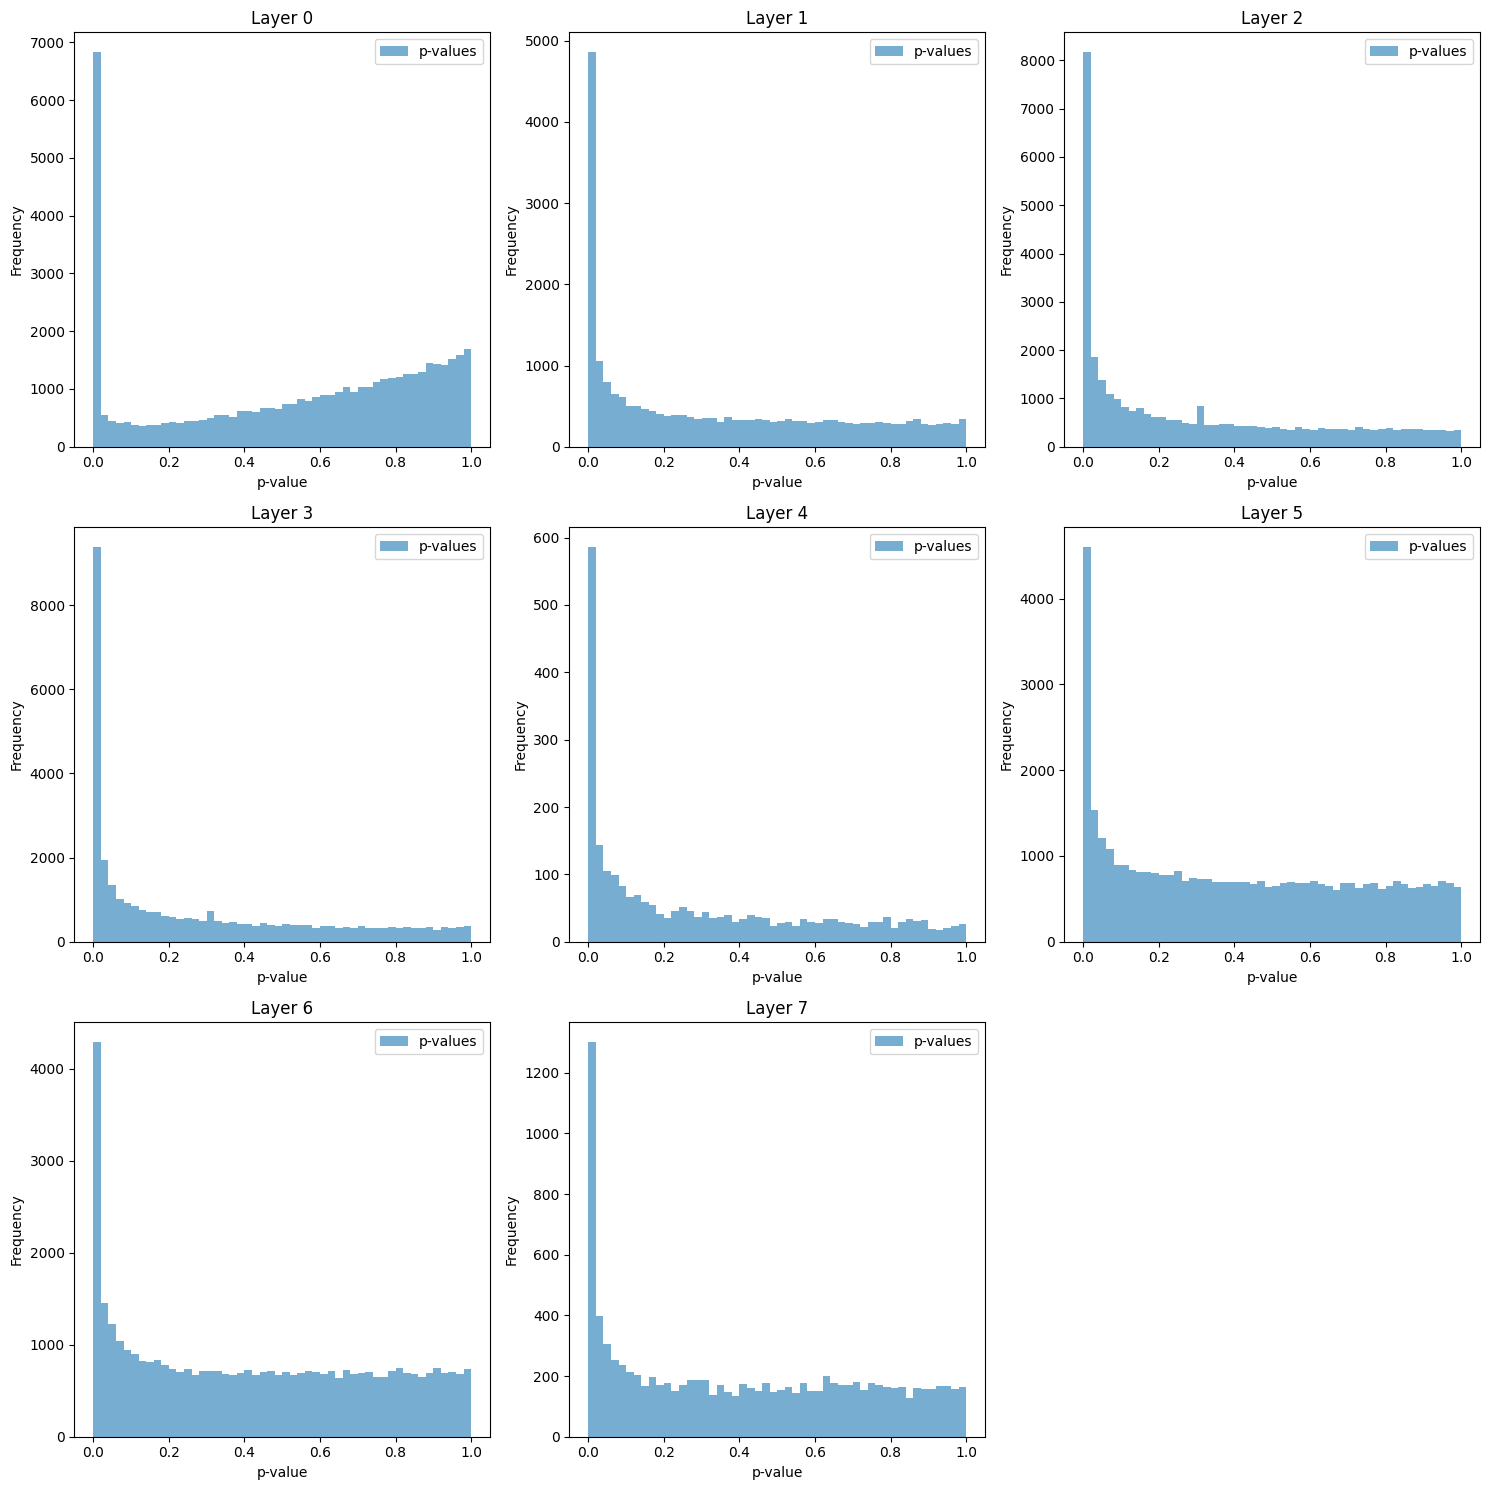

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Load activations
def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_wb/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True)

# Perform two-sample t-tests comparing neuron activations
def perform_two_sample_t_tests(background_activations, original_activations):
    t_test_results = {}
    for layer in background_activations.keys():
        wp_activations = np.vstack(background_activations[layer])
        wo_activations = np.vstack(original_activations[layer])

        # Perform two-sample t-test for each neuron
        ttest_result = ttest_ind(wp_activations, wo_activations, axis=0)

        t_test_results[layer] = {
            'ttest': ttest_result,
            'wp_means': np.mean(wp_activations, axis=0),
            'wo_means': np.mean(wo_activations, axis=0)
        }
    return t_test_results

# Print t-test results with percentages of neurons below or equal to specific p-values
def print_t_test_results(t_test_results):
    for layer, results in t_test_results.items():
        wp_means = results['wp_means']
        wo_means = results['wo_means']
        ttest = results['ttest']

        # Calculate the percentage of neurons below or equal to specific p-value thresholds
        p_values = ttest.pvalue
        below_or_equal_0_05 = np.mean(p_values <= 0.05) * 100
        below_or_equal_0_02 = np.mean(p_values <= 0.02) * 100

        print(f"Layer {layer}:")
        print("  WP Activations:")
        print(f"    Mean: {wp_means.mean():.4f}")
        print("  WO Activations:")
        print(f"    Mean: {wo_means.mean():.4f}")
        print("  T-Test:")
        print(f"    T-statistic: {ttest.statistic.mean():.4f}")
        print(f"    P-value: {ttest.pvalue.mean():.4f}")
        print(f"    Percentage of neurons with p-value <= 0.05: {below_or_equal_0_05:.2f}%")
        print(f"    Percentage of neurons with p-value <= 0.02: {below_or_equal_0_02:.2f}%")
        print("-" * 50)

# Plot the p-values to visualize significance
def plot_p_values(t_test_results):
    num_layers = len(t_test_results)
    num_cols = 3
    num_rows = (num_layers + num_cols - 1) // num_cols

    plt.figure(figsize=(15, 5 * num_rows))
    for idx, (layer, results) in enumerate(t_test_results.items()):
        p_values = results['ttest'].pvalue

        ax = plt.subplot(num_rows, num_cols, idx + 1)
        ax.hist(p_values, bins=50, alpha=0.6, label='p-values')
        ax.set_title(f'Layer {layer}')
        ax.set_xlabel('p-value')
        ax.set_ylabel('Frequency')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]  # Adjusted to match the custom model layers

# Load activations for both left_patch and center_patch conditions
left_patch_activations = {layer: load_activations('left_patch', f'activations.npy_{layer}.npy') for layer in layers_of_interest}
center_patch_activations = {layer: load_activations('center_patch', f'activations.npy_{layer}.npy') for layer in layers_of_interest}

# Perform two-sample t-tests
t_test_results = perform_two_sample_t_tests(left_patch_activations, center_patch_activations)

# Print t-test results
print_t_test_results(t_test_results)

# Plot p-values
plot_p_values(t_test_results)
